In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
pip install shap

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 540.5/540.5 kB 6.7 MB/s eta 0:00:00


In [ ]:
pip install -U kaleido

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.9/79.9 MB 8.7 MB/s eta 0:00:00


In [ ]:
pip install keras-tuner --upgrade

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 4.1 MB/s eta 0:00:00


Import Libraries

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import warnings
import random
import shap
import plotly.graph_objects as go
import plotly.figure_factory as ff
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import f1_score, confusion_matrix, classification_report, make_scorer, cohen_kappa_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, brier_score_loss, roc_curve, auc
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.model_selection import GridSearchCV
from sklearn.calibration import calibration_curve
from sklearn.manifold import TSNE
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense, Dropout
from keras.layers import GRU, LSTM, Dropout, Dense, BatchNormalization
from keras.optimizers import Adam, Adagrad
from keras.models import load_model
from statsmodels.graphics.mosaicplot import mosaic
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import EditedNearestNeighbours
from collections import Counter, defaultdict
from matplotlib.backends.backend_pdf import PdfPages

In [4]:
# Ignore all warnings
warnings.filterwarnings("ignore")

# Pre-Processing

In [ ]:
df_train = pd.read_csv("/content/drive/MyDrive/Thesis/Datasets/browsing_train.csv", header = 0, sep = ',')

df_train.head(10)

FileNotFoundError: [Errno 2] No such file or directory: '/content/drive/MyDrive/Thesis/Datasets/browsing_train.csv'

In [ ]:
df_train.shape

(36079307, 6)

In [ ]:
# create a column 'addcart' which is True if a session contains at least one add event and False otherwise
target_action = 'add'
df_train['addcart'] = df_train.groupby("session_id_hash")["product_action"].transform(lambda x: (x == target_action).any())

print(df_train['addcart'].value_counts())

# only keep sessions which feature at least an add event
df_train = df_train[df_train['addcart']]

# Display the result
df_train.head()

In [ ]:
df_train = pd.read_csv("/content/drive/MyDrive/Thesis/Datasets/training_set_add_cart.csv")

In [ ]:
df_train.head()

session_id_hash     event_type  \
0  8256e7aaf7ade5e68787f3118077de97ae8eec18f47f97...  event_product   
1  8256e7aaf7ade5e68787f3118077de97ae8eec18f47f97...       pageview   
2  8256e7aaf7ade5e68787f3118077de97ae8eec18f47f97...       pageview   
3  8256e7aaf7ade5e68787f3118077de97ae8eec18f47f97...       pageview   
4  8256e7aaf7ade5e68787f3118077de97ae8eec18f47f97...  event_product   

  product_action                                   product_sku_hash  \
0         detail  293231f99098fc9552a19111d8ed7b6188bf0721b1a501...   
1            NaN                                                NaN   
2            NaN                                                NaN   
3            NaN                                                NaN   
4         detail  36e8246f800db10613eef89c81513df909ec8171a875f0...   

   server_timestamp_epoch_ms  \
0              1551545503415   
1              1551545503415   
2              1551545510494   
3              1551545514312   
4              1551545514312   

                                          hashed_url  addcart  
0  4e8321996f16f2734a5af4b4c780b4c4669fb316cf24ad...     True  
1  4e8321996f16f2734a5af4b4c780b4c4669fb316cf24ad...     True  
2  744ac6435f90719fdec0276541a5c481138cc1f2f51106...     True  
3  15c3f072fa3c3caa710d9cc114fa017f37deb117ec158c...     True  
4  15c3f072fa3c3caa710d9cc114fa017f37deb117ec158c...     True

In [ ]:
df_train['product_action'] = df_train['product_action'].fillna('view')

In [ ]:
# you can check whether you successfully filtered out sessions with no add to cart by computing the mean
# of the 'addcart' column. It should yield 1.
df_train["addcart"].mean()

1.0

In [ ]:
# Label the sessions (1: conversions; 0: cart-abandonement)
# create a column 'convert' which is True if a session contains at least a purchase event and False otherwise
target_action = 'purchase'
df_train['convert'] = df_train.groupby("session_id_hash")["product_action"].transform(lambda x: (x == target_action).any())

df_train.head(10)

session_id_hash     event_type  \
0  8256e7aaf7ade5e68787f3118077de97ae8eec18f47f97...  event_product   
1  8256e7aaf7ade5e68787f3118077de97ae8eec18f47f97...       pageview   
2  8256e7aaf7ade5e68787f3118077de97ae8eec18f47f97...       pageview   
3  8256e7aaf7ade5e68787f3118077de97ae8eec18f47f97...       pageview   
4  8256e7aaf7ade5e68787f3118077de97ae8eec18f47f97...  event_product   
5  8256e7aaf7ade5e68787f3118077de97ae8eec18f47f97...  event_product   
6  8256e7aaf7ade5e68787f3118077de97ae8eec18f47f97...       pageview   
7  8256e7aaf7ade5e68787f3118077de97ae8eec18f47f97...       pageview   
8  8256e7aaf7ade5e68787f3118077de97ae8eec18f47f97...       pageview   
9  8256e7aaf7ade5e68787f3118077de97ae8eec18f47f97...  event_product   

  product_action                                   product_sku_hash  \
0         detail  293231f99098fc9552a19111d8ed7b6188bf0721b1a501...   
1           view                                                NaN   
2           view                                                NaN   
3           view                                                NaN   
4         detail  36e8246f800db10613eef89c81513df909ec8171a875f0...   
5            add  36e8246f800db10613eef89c81513df909ec8171a875f0...   
6           view                                                NaN   
7           view                                                NaN   
8           view                                                NaN   
9       purchase  36e8246f800db10613eef89c81513df909ec8171a875f0...   

   server_timestamp_epoch_ms  \
0              1551545503415   
1              1551545503415   
2              1551545510494   
3              1551545514312   
4              1551545514312   
5              1551545686640   
6              1551545760235   
7              1551545777947   
8              1551546521904   
9              1551546521904   

                                          hashed_url  addcart  convert  
0  4e8321996f16f2734a5af4b4c780b4c4669fb316cf24ad...     True     True  
1  4e8321996f16f2734a5af4b4c780b4c4669fb316cf24ad...     True     True  
2  744ac6435f90719fdec0276541a5c481138cc1f2f51106...     True     True  
3  15c3f072fa3c3caa710d9cc114fa017f37deb117ec158c...     True     True  
4  15c3f072fa3c3caa710d9cc114fa017f37deb117ec158c...     True     True  
5  83b4fdad686c1be4eba335f70d23ae202b84b6153e109e...     True     True  
6  0ad6fab1eb3ac76010ea2fa6399a4e993b00f6501c88a2...     True     True  
7  e93e5c83aab0987e41d8fd65a30b54d2ce87491b4a7f9b...     True     True  
8  e396b36a40f2c41d259a45b80e10cd113eb0bf7540b73f...     True     True  
9  e396b36a40f2c41d259a45b80e10cd113eb0bf7540b73f...     True     True

In [ ]:
# filter sessions which are either too short (<5) or too long (>100)
df_train['nevents'] = df_train.groupby('session_id_hash')['event_type'].transform("count")
condition1 = df_train['nevents'] >= 5
condition2 = df_train['nevents'] <= 155
combined_condition = condition1 & condition2

# Apply the combined condition to filter the DataFrame
df_train = df_train[combined_condition]

df_train.shape

(5782587, 9)

In [ ]:
# Checking if the conditions have been applied
df_train["nevents"].min()

5

In [ ]:
df_train["nevents"].max()

155

In [ ]:
action_counts = df_train['product_action'].value_counts()
action_counts

product_action
view        3876587
detail      1271046
add          305362
remove       263754
purchase      65838
Name: count, dtype: int64

In [ ]:
# 5 symbolize actions (map actions to integers by inverse frequency, so the most frequent event to 1, the next
# most frequent to 2, and so on...)
# Create a Counter for the actions
action_counts = Counter(df_train['product_action'])

# Create a symbol-to-index mapping based on inverse frequency
symbol2idx_inverse = {
    symbol: idx for idx, symbol in enumerate(sorted(action_counts, key=action_counts.get, reverse=True), 1)
}

# Symbolize actions and create a new column 'product_action_symb'
df_train['product_action_symb'] = df_train['product_action'].map(symbol2idx_inverse)

df_train.shape

(5782587, 10)

In [ ]:
# 1: view, 2: detail, 3: add, 4: remove, 5: purchase

In [ ]:
df_train['conversion'] = np.where((df_train['addcart'] == True) & (df_train['convert'] == True), 1,
                            np.where((df_train['addcart'] == True) & (df_train['convert'] == False), 0, np.nan))

In [ ]:
df_train["date"] = pd.to_datetime(df_train["server_timestamp_epoch_ms"], unit = "ms")
df_train["week_day"] = df_train["date"].dt.weekday
df_train['weekend'] = np.where(df_train["week_day"] >= 5, True, False)
df_train["month"] = df_train["date"].dt.month
df_train["hour"] = df_train["date"].dt.hour

In [ ]:
df_train['session_duration'] = df_train.groupby('session_id_hash')['server_timestamp_epoch_ms'].transform(
    lambda x: x.max() - x.min()
)
# Convert the session duration from ms to sec
df_train['session_duration'] = (df_train['session_duration'] / 1000).round()

In [ ]:
df_train['unique_products_viewed'] = df_train.groupby('session_id_hash')['product_sku_hash'].transform("nunique")

In [ ]:
df_train['avg_dwell_time'] = df_train["session_duration"] / df_train["nevents"]

In [ ]:
df_train.head()

session_id_hash     event_type  \
0  8256e7aaf7ade5e68787f3118077de97ae8eec18f47f97...  event_product   
1  8256e7aaf7ade5e68787f3118077de97ae8eec18f47f97...       pageview   
2  8256e7aaf7ade5e68787f3118077de97ae8eec18f47f97...       pageview   
3  8256e7aaf7ade5e68787f3118077de97ae8eec18f47f97...       pageview   
4  8256e7aaf7ade5e68787f3118077de97ae8eec18f47f97...  event_product   

  product_action                                   product_sku_hash  \
0         detail  293231f99098fc9552a19111d8ed7b6188bf0721b1a501...   
1           view                                                NaN   
2           view                                                NaN   
3           view                                                NaN   
4         detail  36e8246f800db10613eef89c81513df909ec8171a875f0...   

   server_timestamp_epoch_ms  \
0              1551545503415   
1              1551545503415   
2              1551545510494   
3              1551545514312   
4              1551545514312   

                                          hashed_url  addcart  convert  \
0  4e8321996f16f2734a5af4b4c780b4c4669fb316cf24ad...     True     True   
1  4e8321996f16f2734a5af4b4c780b4c4669fb316cf24ad...     True     True   
2  744ac6435f90719fdec0276541a5c481138cc1f2f51106...     True     True   
3  15c3f072fa3c3caa710d9cc114fa017f37deb117ec158c...     True     True   
4  15c3f072fa3c3caa710d9cc114fa017f37deb117ec158c...     True     True   

   nevents  product_action_symb  conversion                    date  week_day  \
0       13                    2         1.0 2019-03-02 16:51:43.415         5   
1       13                    1         1.0 2019-03-02 16:51:43.415         5   
2       13                    1         1.0 2019-03-02 16:51:50.494         5   
3       13                    1         1.0 2019-03-02 16:51:54.312         5   
4       13                    2         1.0 2019-03-02 16:51:54.312         5   

   weekend  month  hour  session_duration  unique_products_viewed  \
0     True      3    16            1107.0                       2   
1     True      3    16            1107.0                       2   
2     True      3    16            1107.0                       2   
3     True      3    16            1107.0                       2   
4     True      3    16            1107.0                       2   

   avg_dwell_time  
0       85.153846  
1       85.153846  
2       85.153846  
3       85.153846  
4       85.153846

In [ ]:
df_train.to_csv("/content/drive/MyDrive/Thesis/Datasets/df_train_processed.csv", index = False)

# Exploratory Data Analysis

In [ ]:
df_train = pd.read_csv("/content/drive/MyDrive/Thesis/Datasets/df_train_processed.csv")

In [ ]:
df_train.head()

session_id_hash     event_type  \
0  8256e7aaf7ade5e68787f3118077de97ae8eec18f47f97...  event_product   
1  8256e7aaf7ade5e68787f3118077de97ae8eec18f47f97...       pageview   
2  8256e7aaf7ade5e68787f3118077de97ae8eec18f47f97...       pageview   
3  8256e7aaf7ade5e68787f3118077de97ae8eec18f47f97...       pageview   
4  8256e7aaf7ade5e68787f3118077de97ae8eec18f47f97...  event_product   

  product_action                                   product_sku_hash  \
0         detail  293231f99098fc9552a19111d8ed7b6188bf0721b1a501...   
1           view                                                NaN   
2           view                                                NaN   
3           view                                                NaN   
4         detail  36e8246f800db10613eef89c81513df909ec8171a875f0...   

   server_timestamp_epoch_ms  \
0              1551545503415   
1              1551545503415   
2              1551545510494   
3              1551545514312   
4              1551545514312   

                                          hashed_url  addcart  convert  \
0  4e8321996f16f2734a5af4b4c780b4c4669fb316cf24ad...     True     True   
1  4e8321996f16f2734a5af4b4c780b4c4669fb316cf24ad...     True     True   
2  744ac6435f90719fdec0276541a5c481138cc1f2f51106...     True     True   
3  15c3f072fa3c3caa710d9cc114fa017f37deb117ec158c...     True     True   
4  15c3f072fa3c3caa710d9cc114fa017f37deb117ec158c...     True     True   

   nevents  product_action_symb  conversion                     date  \
0       13                    2         1.0  2019-03-02 16:51:43.415   
1       13                    1         1.0  2019-03-02 16:51:43.415   
2       13                    1         1.0  2019-03-02 16:51:50.494   
3       13                    1         1.0  2019-03-02 16:51:54.312   
4       13                    2         1.0  2019-03-02 16:51:54.312   

   week_day  weekend  month  hour  session_duration  unique_products_viewed  \
0         5     True      3    16            1107.0                       2   
1         5     True      3    16            1107.0                       2   
2         5     True      3    16            1107.0                       2   
3         5     True      3    16            1107.0                       2   
4         5     True      3    16            1107.0                       2   

   avg_dwell_time  
0       85.153846  
1       85.153846  
2       85.153846  
3       85.153846  
4       85.153846

## Counts and Distributions

In [ ]:
action_counts = df_train['product_action'].value_counts()
action_counts

product_action
view        3876587
detail      1271046
add          305362
remove       263754
purchase      65838
Name: count, dtype: int64

In [ ]:
# First, ensure the 'conversion' column is treated as an integer for proper grouping
df_train['conversion'] = df_train['conversion'].astype(int)

# Function to calculate percentages
def calculate_action_percentages(group):
    action_counts = group['product_action'].value_counts(normalize=True) * 100
    return action_counts

# Group by 'conversion' and apply the function
action_percentages_by_conversion = df_train.groupby('conversion').apply(calculate_action_percentages)

# Display the results
print(action_percentages_by_conversion)

conversion  product_action
0           view              66.738113
            detail            24.005816
            add                5.581363
            remove             3.674708
1           view              67.808944
            detail            16.797544
            remove             6.829846
            add                4.511294
            purchase           4.052372
Name: proportion, dtype: float64


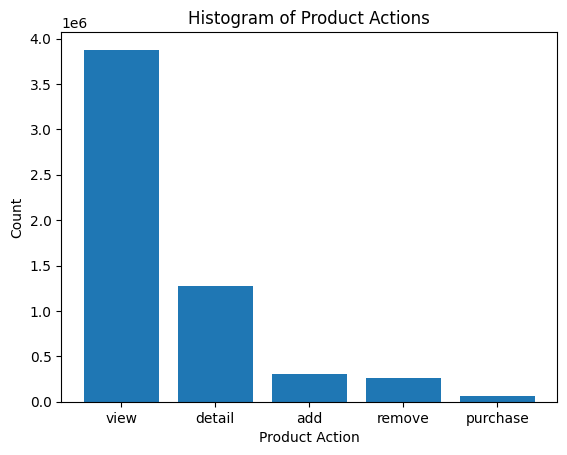

In [ ]:
action_counts = {
    'view': 3876587,
    'detail': 1271046,
    'add': 305362,
    'remove': 263754,
    'purchase': 65838
}

# Create a histogram
plt.bar(action_counts.keys(), action_counts.values())

# Adding labels and title
plt.xlabel('Product Action')
plt.ylabel('Count')
plt.title('Histogram of Product Actions')

# Display the plot
plt.show()

In [ ]:
conversion_counts = df_train['conversion'].value_counts()
conversion_counts

conversion
0.0    153788
1.0     45603
Name: count, dtype: int64

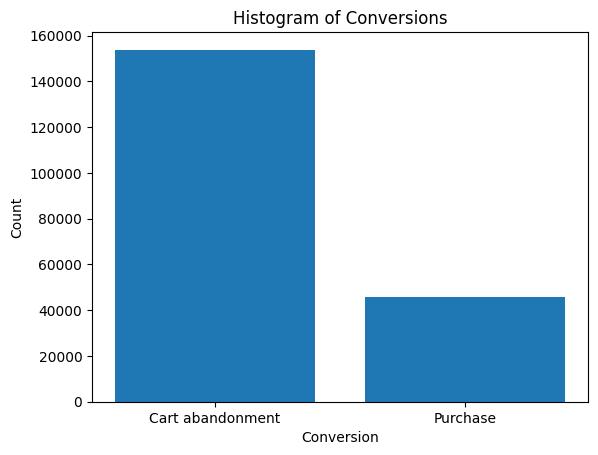

In [ ]:
# Given data
conversion_counts = {
    0.0: 153788.0,
    1.0: 45603.0
}

# Create a histogram
plt.bar(conversion_counts.keys(), conversion_counts.values())

# Adding labels and title
plt.xlabel('Conversion')
plt.ylabel('Count')
plt.title('Histogram of Conversions')

# Set custom x-axis tick labels
plt.xticks(list(conversion_counts.keys()), ['Cart abandonment', 'Purchase'])

# Display the plot
plt.show()

In [ ]:
df_train["date"].min()

'2019-01-15 05:02:57.856'

In [ ]:
df_train["date"].max()

'2019-04-15 03:58:30.415'

In [ ]:
df_train = df_train.groupby('session_id_hash').agg({'product_action_symb': list, 'nevents': 'first', 'week_day': 'first', 'weekend': 'first', 'hour': 'first', 'session_duration': 'first', 'conversion': 'first', 'unique_products_viewed': 'first', 'avg_dwell_time': 'first'}).reset_index()
df_train.head()

session_id_hash  \
0  00000114e1075962f022114fcfc17f2d874e694ac5d201...   
1  000010504025397b03290c7457e0e7ef7ae93529f21eae...   
2  0000913afa22ba9c31efb992bcf6388b0bbfe28056bef3...   
3  00010d84aca1294479304044207fd268f63228844779c6...   
4  0001368d732951035a7ef7ef42b345a5c50b7d66966749...   

                                 product_action_symb  nevents  week_day  \
0  [1, 2, 3, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 2, 1, ...       18         1   
1  [2, 1, 2, 1, 2, 1, 1, 2, 1, 1, 1, 2, 2, 1, 2, ...       81         3   
2  [1, 1, 1, 2, 1, 1, 2, 1, 1, 1, 1, 2, 1, 1, 1, ...      139         4   
3  [1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, ...       41         6   
4   [1, 2, 3, 1, 1, 2, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1]       16         3   

   weekend  hour  session_duration  conversion  unique_products_viewed  \
0    False    20            3479.0         0.0                       3   
1    False    12            2024.0         0.0                      10   
2    False    14            3647.0         0.0                      23   
3     True    18            2612.0         0.0                       3   
4    False     3             265.0         0.0                       1   

   avg_dwell_time  
0      193.277778  
1       24.987654  
2       26.237410  
3       63.707317  
4       16.562500

In [ ]:
df_train = df_train.rename(columns={'product_action_symb': 'session'})

In [ ]:
df_train["nevents"].sum()

5782587

In [ ]:
session_duration = df_train.groupby('conversion')['session_duration']
print(session_duration.describe())

               count         mean          std   min    25%     50%     75%  \
conversion                                                                    
0.0         153788.0   866.485441   967.220532   1.0  222.0   532.5  1173.0   
1.0          45603.0  1354.101046  1093.827045  44.0  573.0  1022.0  1806.0   

                max  
conversion           
0.0         15951.0  
1.0         10486.0  


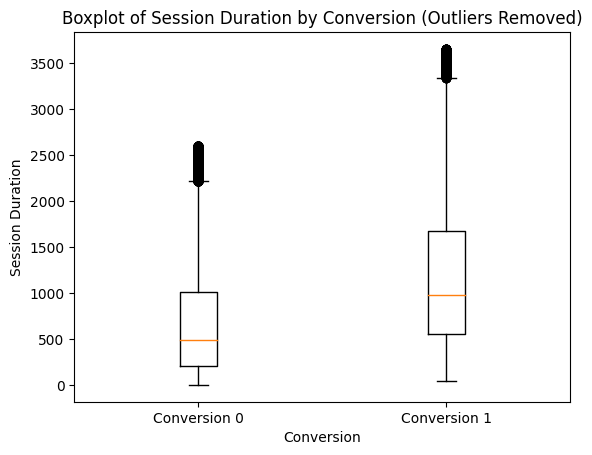

In [ ]:
# Obtain summary statistics for each conversion group
session_duration_stats = df_train.groupby('conversion')['session_duration'].describe()

# Extract specific statistics for each conversion
conversion_0_stats = session_duration_stats.loc[0]
conversion_1_stats = session_duration_stats.loc[1]

# Define lower and upper percentiles (e.g., 10th and 90th percentiles)
lower_percentile = 10
upper_percentile = 90

# Calculate lower and upper bounds for each conversion group
conversion_0_lower_bound = conversion_0_stats['25%'] - 1.5 * (conversion_0_stats['75%'] - conversion_0_stats['25%'])
conversion_0_upper_bound = conversion_0_stats['75%'] + 1.5 * (conversion_0_stats['75%'] - conversion_0_stats['25%'])
conversion_1_lower_bound = conversion_1_stats['25%'] - 1.5 * (conversion_1_stats['75%'] - conversion_1_stats['25%'])
conversion_1_upper_bound = conversion_1_stats['75%'] + 1.5 * (conversion_1_stats['75%'] - conversion_1_stats['25%'])

# Filter out data points outside of the bounds
filtered_conversion_0 = df_train[(df_train['conversion'] == 0) & (df_train['session_duration'] >= conversion_0_lower_bound) & (df_train['session_duration'] <= conversion_0_upper_bound)]
filtered_conversion_1 = df_train[(df_train['conversion'] == 1) & (df_train['session_duration'] >= conversion_1_lower_bound) & (df_train['session_duration'] <= conversion_1_upper_bound)]

# Create boxplot
plt.boxplot([filtered_conversion_0['session_duration'], filtered_conversion_1['session_duration']], labels=['Conversion 0', 'Conversion 1'])
plt.title('Boxplot of Session Duration by Conversion (Outliers Removed)')
plt.xlabel('Conversion')
plt.ylabel('Session Duration')
plt.show()


In [ ]:
session_events = df_train.groupby('conversion')['nevents']
print(session_events.describe())

               count       mean        std  min   25%   50%   75%    max
conversion                                                              
0.0         153788.0  27.036628  24.047066  5.0  11.0  19.0  35.0  155.0
1.0          45603.0  35.626560  27.341102  5.0  16.0  27.0  46.0  155.0


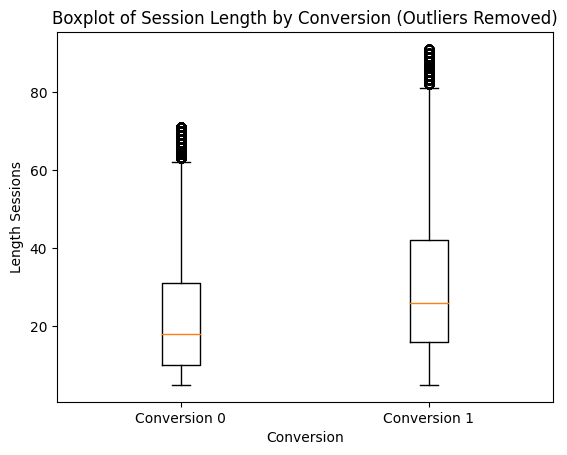

In [ ]:
# Obtain summary statistics for each conversion group
session_duration_stats = df_train.groupby('conversion')['nevents'].describe()

# Extract specific statistics for each conversion
conversion_0_stats = session_duration_stats.loc[0]
conversion_1_stats = session_duration_stats.loc[1]

# Define lower and upper percentiles (e.g., 10th and 90th percentiles)
lower_percentile = 10
upper_percentile = 90

# Calculate lower and upper bounds for each conversion group
conversion_0_lower_bound = conversion_0_stats['25%'] - 1.5 * (conversion_0_stats['75%'] - conversion_0_stats['25%'])
conversion_0_upper_bound = conversion_0_stats['75%'] + 1.5 * (conversion_0_stats['75%'] - conversion_0_stats['25%'])
conversion_1_lower_bound = conversion_1_stats['25%'] - 1.5 * (conversion_1_stats['75%'] - conversion_1_stats['25%'])
conversion_1_upper_bound = conversion_1_stats['75%'] + 1.5 * (conversion_1_stats['75%'] - conversion_1_stats['25%'])

# Filter out data points outside of the bounds
filtered_conversion_0 = df_train[(df_train['conversion'] == 0) & (df_train['nevents'] >= conversion_0_lower_bound) & (df_train['nevents'] <= conversion_0_upper_bound)]
filtered_conversion_1 = df_train[(df_train['conversion'] == 1) & (df_train['nevents'] >= conversion_1_lower_bound) & (df_train['nevents'] <= conversion_1_upper_bound)]

# Create boxplot
plt.boxplot([filtered_conversion_0['nevents'], filtered_conversion_1['nevents']], labels=['Conversion 0', 'Conversion 1'])
plt.title('Boxplot of Session Length by Conversion (Outliers Removed)')
plt.xlabel('Conversion')
plt.ylabel('Length Sessions')
plt.show()


In [ ]:
avg_dwell_time = df_train.groupby('conversion')['avg_dwell_time']
print(avg_dwell_time.describe())

               count       mean        std       min        25%        50%  \
conversion                                                                   
0.0         153788.0  35.320980  36.129066  0.166667  14.400000  23.666667   
1.0          45603.0  45.374278  33.372904  2.794118  23.511111  35.952381   

                  75%         max  
conversion                         
0.0         42.138332  748.400000  
1.0         55.939338  413.777778  


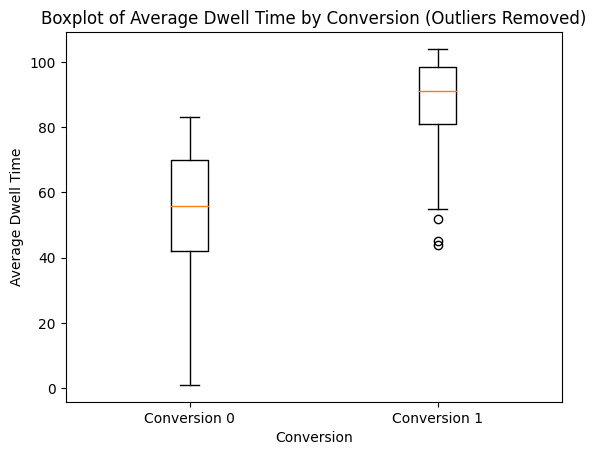

In [ ]:
# Obtain summary statistics for each conversion group
avg_dwell_time_stats = df_train.groupby('conversion')['avg_dwell_time'].describe()

# Extract specific statistics for each conversion
conversion_0_stats = avg_dwell_time_stats.loc[0]
conversion_1_stats = avg_dwell_time_stats.loc[1]

# Define lower and upper percentiles (e.g., 10th and 90th percentiles)
lower_percentile = 10
upper_percentile = 90

# Calculate lower and upper bounds for each conversion group
conversion_0_lower_bound = conversion_0_stats['25%'] - 1.5 * (conversion_0_stats['75%'] - conversion_0_stats['25%'])
conversion_0_upper_bound = conversion_0_stats['75%'] + 1.5 * (conversion_0_stats['75%'] - conversion_0_stats['25%'])
conversion_1_lower_bound = conversion_1_stats['25%'] - 1.5 * (conversion_1_stats['75%'] - conversion_1_stats['25%'])
conversion_1_upper_bound = conversion_1_stats['75%'] + 1.5 * (conversion_1_stats['75%'] - conversion_1_stats['25%'])

# Filter out data points outside of the bounds
filtered_conversion_0 = df_train[(df_train['conversion'] == 0) & (df_train['session_duration'] >= conversion_0_lower_bound) & (df_train['session_duration'] <= conversion_0_upper_bound)]
filtered_conversion_1 = df_train[(df_train['conversion'] == 1) & (df_train['session_duration'] >= conversion_1_lower_bound) & (df_train['session_duration'] <= conversion_1_upper_bound)]

# Create boxplot
plt.boxplot([filtered_conversion_0['session_duration'], filtered_conversion_1['session_duration']], labels=['Conversion 0', 'Conversion 1'])
plt.title('Boxplot of Average Dwell Time by Conversion (Outliers Removed)')
plt.xlabel('Conversion')
plt.ylabel('Average Dwell Time')
plt.show()

In [ ]:
unique_products_viewed = df_train.groupby('conversion')['unique_products_viewed']
print(unique_products_viewed.describe())

               count      mean       std  min  25%  50%  75%   max
conversion                                                        
0.0         153788.0  4.534138  4.562628  1.0  2.0  3.0  6.0  61.0
1.0          45603.0  4.244041  4.399762  1.0  1.0  3.0  5.0  53.0


In [ ]:
week_day = df_train.groupby('conversion')['week_day'].value_counts()
print(week_day)

conversion  week_day
0.0         6           23108
            3           22530
            4           22507
            0           22162
            5           21941
            1           21896
            2           19644
1.0         0            6975
            1            6948
            4            6606
            6            6499
            2            6245
            5            6235
            3            6095
Name: count, dtype: int64


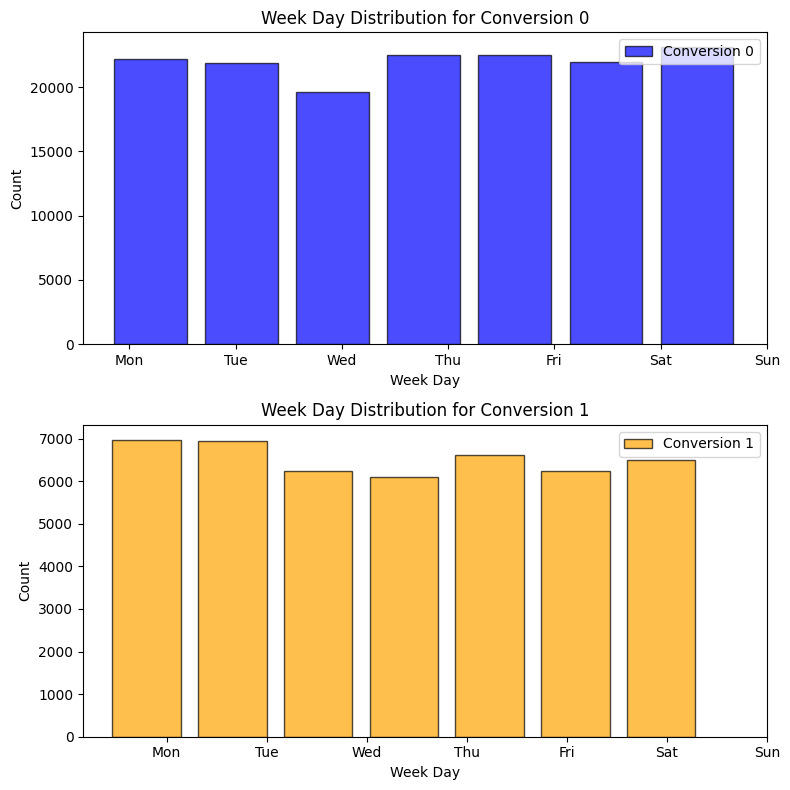

In [ ]:
# Separate data for conversion 0 and 1
conversion_0_data = df_train[df_train['conversion'] == 0]['week_day']
conversion_1_data = df_train[df_train['conversion'] == 1]['week_day']

# Plot histograms
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(8, 8))

# Calculate the positions for each bar
positions_0 = np.arange(7) - 0.2
positions_1 = np.arange(7) + 0.2

# Plot histograms with manually centered bars
axes[0].hist(conversion_0_data, bins=7, color='blue', alpha=0.7, rwidth=0.8, edgecolor='black', align='left', label='Conversion 0')
axes[0].set_xticks(positions_0)
axes[0].set_xticklabels(['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'])
axes[0].set_title('Week Day Distribution for Conversion 0')
axes[0].set_xlabel('Week Day')
axes[0].set_ylabel('Count')
axes[0].legend()

axes[1].hist(conversion_1_data, bins=7, color='orange', alpha=0.7, rwidth=0.8, edgecolor='black', align='left', label='Conversion 1')
axes[1].set_xticks(positions_1)
axes[1].set_xticklabels(['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'])
axes[1].set_title('Week Day Distribution for Conversion 1')
axes[1].set_xlabel('Week Day')
axes[1].set_ylabel('Count')
axes[1].legend()

plt.tight_layout()
plt.show()

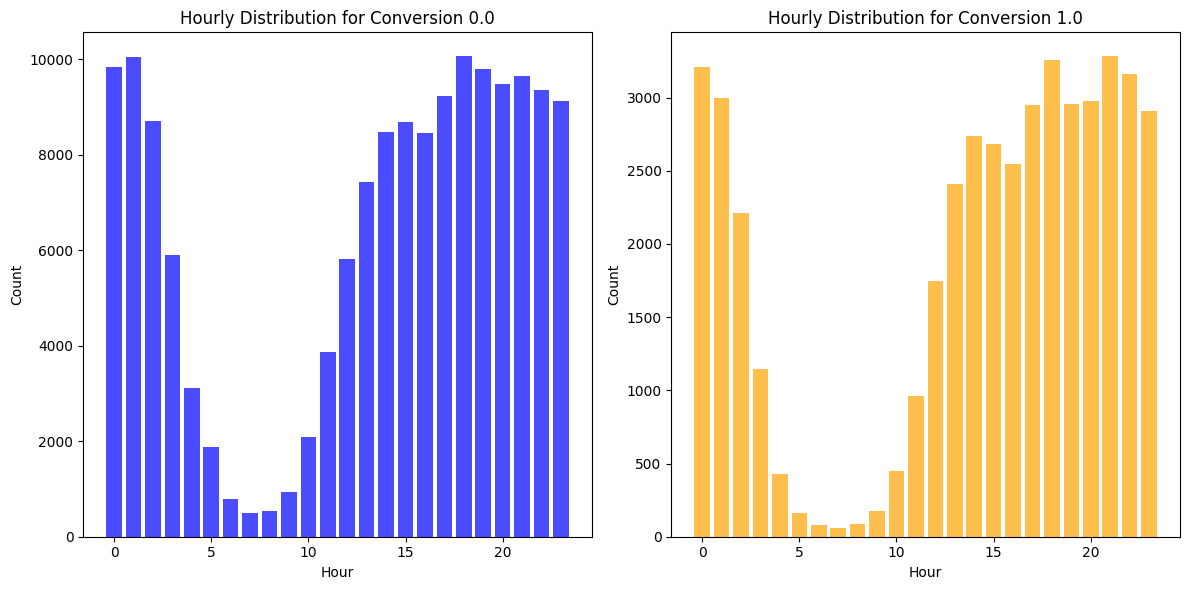

In [ ]:
hour_data = df_train.groupby('conversion')['hour'].value_counts()
# Extract data for conversion 0.0 and 1.0
conversion_0_data = {key[1]: value for key, value in hour_data.items() if key[0] == 0.0}
conversion_1_data = {key[1]: value for key, value in hour_data.items() if key[0] == 1.0}

# Plot histograms
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.bar(conversion_0_data.keys(), conversion_0_data.values(), color='blue', alpha=0.7)
plt.title('Hourly Distribution for Conversion 0.0')
plt.xlabel('Hour')
plt.ylabel('Count')

plt.subplot(1, 2, 2)
plt.bar(conversion_1_data.keys(), conversion_1_data.values(), color='orange', alpha=0.7)
plt.title('Hourly Distribution for Conversion 1.0')
plt.xlabel('Hour')
plt.ylabel('Count')

plt.tight_layout()
plt.show()

## Heatmaps Transition Sequences

In [ ]:
def filter_actions_before_purchase(group, target):
    purchase_indices = group.index[group['product_action'].eq(target)]
    if not purchase_indices.empty:
        first_purchase_index = purchase_indices.min()
        return group.loc[:first_purchase_index - 1]
    else:
        return group

target_action = 'purchase'
df_train = df_train.groupby('session_id_hash', group_keys=False).apply(
    filter_actions_before_purchase, target_action).reset_index()

In [ ]:
df_train = df_train.groupby('session_id_hash').agg({'product_action_symb': list, 'nevents': 'first', 'week_day': 'first', 'weekend': 'first', 'hour': 'first', 'session_duration': 'first', 'conversion': 'first', 'unique_products_viewed': 'first', 'avg_dwell_time': 'first'}).reset_index()
df_train = df_train.rename(columns={'product_action_symb': 'session'})
df_train.head()

session_id_hash  \
0  00000114e1075962f022114fcfc17f2d874e694ac5d201...   
1  000010504025397b03290c7457e0e7ef7ae93529f21eae...   
2  0000913afa22ba9c31efb992bcf6388b0bbfe28056bef3...   
3  00010d84aca1294479304044207fd268f63228844779c6...   
4  0001368d732951035a7ef7ef42b345a5c50b7d66966749...   

                                             session  nevents  week_day  \
0  [1, 2, 3, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 2, 1, ...       18         1   
1  [2, 1, 2, 1, 2, 1, 1, 2, 1, 1, 1, 2, 2, 1, 2, ...       81         3   
2  [1, 1, 1, 2, 1, 1, 2, 1, 1, 1, 1, 2, 1, 1, 1, ...      139         4   
3  [1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, ...       41         6   
4   [1, 2, 3, 1, 1, 2, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1]       16         3   

   weekend  hour  session_duration  conversion  unique_products_viewed  \
0    False    20            3479.0         0.0                       3   
1    False    12            2024.0         0.0                      10   
2    False    14            3647.0         0.0                      23   
3     True    18            2612.0         0.0                       3   
4    False     3             265.0         0.0                       1   

   avg_dwell_time  
0      193.277778  
1       24.987654  
2       26.237410  
3       63.707317  
4       16.562500

In [ ]:
df_train.to_csv("/content/drive/MyDrive/Thesis/Datasets/df_train_processed_trimmed.csv", index = False)

In [ ]:
df_train = pd.read_csv("/content/drive/MyDrive/Thesis/Datasets/df_train_processed_trimmed.csv")

In [ ]:
symbolised_sessions = df_train["session"]
labels = df_train["conversion"]

buy_sessions, ca_sessions = [], []
for session, label in zip(symbolised_sessions, labels):
    if label == 1:
        buy_sessions.append(session)
    else:
        ca_sessions.append(session)

buy_sessions = [[int(num) for num in item.strip("[]").split(', ')] for item in buy_sessions]
ca_sessions = [[int(num) for num in item.strip("[]").split(', ')] for item in ca_sessions]

In [ ]:
# proportion of events in the two classes
events_buy = Counter([event for session in buy_sessions for event in session])
events_ca = Counter([event for session in ca_sessions for event in session])

def normalise(d):
    tot = sum(d.values())
    return {event: count/tot for event, count in d.items()}

events_buy = normalise(events_buy)
events_ca = normalise(events_ca)

for event, prop in events_buy.items():
    print('{}: {}'.format(event, prop - events_ca [event]))

1: 0.016508049351535603
2: -0.05873085629542735
3: -0.002387014126106972
4: 0.044609821069998765


In [ ]:
# bigram transitions in the two classes

def get_transitions(sessions):
    n_events = len(set(item for session in sessions for item in session))
    transitions = np.zeros((n_events, n_events))
    for session in sessions:
        for i, event in enumerate(session):
            try:
                transitions[event-1, session[i+1]-1] += 1
            except IndexError:
                pass

    row_sums = transitions.sum(axis=1)

    return transitions / row_sums[:, np.newaxis]

transitions_buy = get_transitions(buy_sessions)
transitions_ca = get_transitions(ca_sessions)

In [ ]:
transitions_buy[:7]

array([[0.67279063, 0.23537825, 0.04341376, 0.04841736],
       [0.77443372, 0.10652207, 0.10826887, 0.01077534],
       [0.80804898, 0.04214676, 0.04488158, 0.10492268],
       [0.42462335, 0.00109104, 0.0355015 , 0.53878411]])

In [ ]:
transitions_ca[:7]

array([[0.6143655 , 0.31501073, 0.04391765, 0.02670611],
       [0.79190228, 0.10816802, 0.09158685, 0.00834285],
       [0.76599459, 0.09767202, 0.04904338, 0.08729001],
       [0.54288602, 0.00183646, 0.09597167, 0.35930584]])

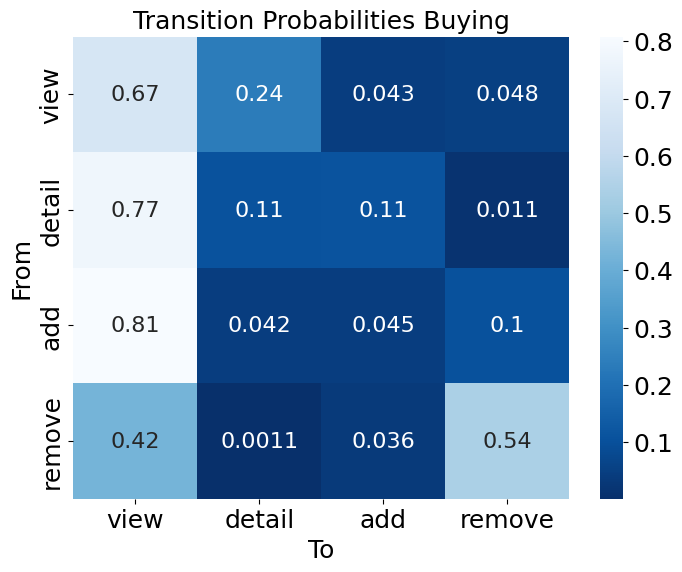

In [ ]:
# Define the actions for labeling
actions = ["view", "detail", "add", "remove"]

# Create a figure object for more control over the save functionality
plt.figure(figsize=(8, 6))
ax = sns.heatmap(transitions_buy, cmap='Blues_r', xticklabels=actions, yticklabels=actions, annot=True, annot_kws={"size": 16})  # Increase annotation text size

# Set title and labels with increased font sizes
ax.set_title('Transition Probabilities Buying', fontsize=18)  # Increase title font size
plt.xlabel('To', fontsize=18)  # Increase x-axis label font size
plt.ylabel('From', fontsize=18)  # Increase y-axis label font size

# Increase tick labels font size
ax.tick_params(axis='both', which='major', labelsize=18)

# Increase color bar size and font size
cbar = ax.collections[0].colorbar
cbar.ax.tick_params(labelsize=18)  # Increase color bar tick labels font size

# Save the figure to a PDF file
plt.savefig('heatmap_buying_sessions.pdf', format='pdf')

# Display the plot
plt.show()

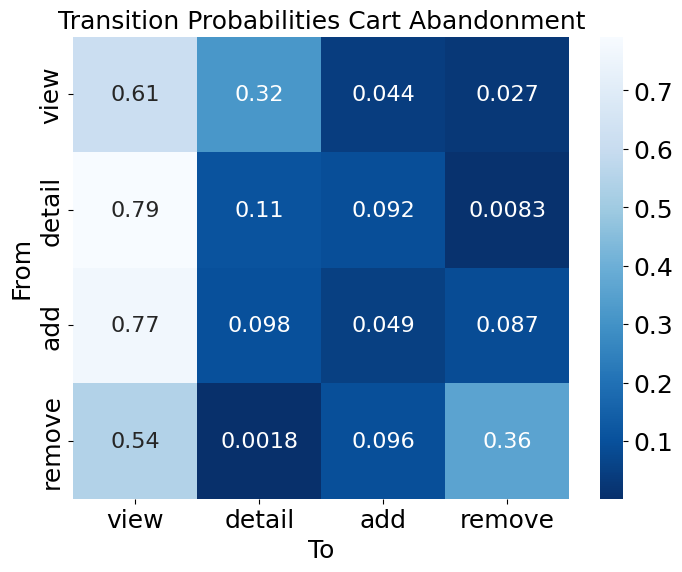

In [ ]:
# Define the actions for labeling
actions = ["view", "detail", "add", "remove"]

# Create a figure object for more control over the save functionality
plt.figure(figsize=(8, 6))
ax = sns.heatmap(transitions_ca, cmap='Blues_r', xticklabels=actions, yticklabels=actions, annot=True, annot_kws={"size": 16})  # Increase annotation text size

# Set title and labels with increased font sizes
ax.set_title('Transition Probabilities Cart Abandonment', fontsize=18)  # Increase title font size
plt.xlabel('To', fontsize=18)  # Increase x-axis label font size
plt.ylabel('From', fontsize=18)  # Increase y-axis label font size

# Increase tick labels font size
ax.tick_params(axis='both', which='major', labelsize=18)

# Increase color bar size and font size
cbar = ax.collections[0].colorbar
cbar.ax.tick_params(labelsize=18)  # Increase color bar tick labels font size

# Save the figure to a PDF file
plt.savefig('heatmap_ca_sessions.pdf', format='pdf')

# Display the plot
plt.show()

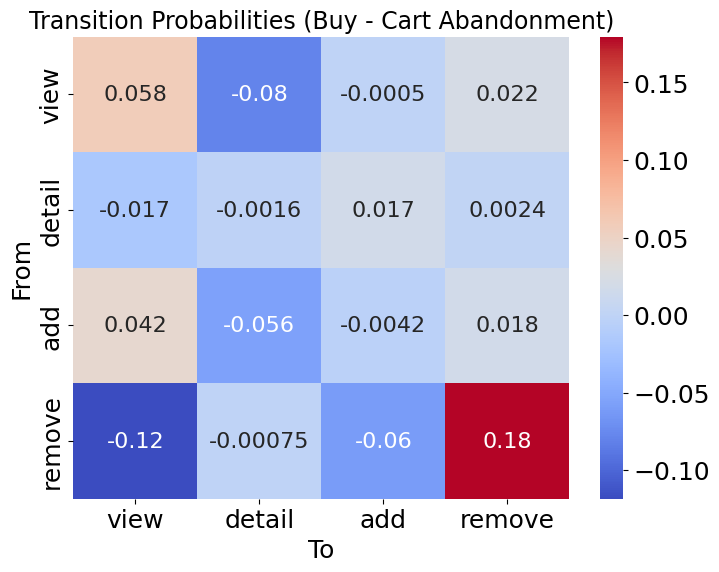

In [ ]:
# Define the actions for labeling
actions = ["view", "detail", "add", "remove"]

# Create a figure object for more control over the save functionality
plt.figure(figsize=(8, 6))
ax = sns.heatmap(transitions_buy - transitions_ca, cmap='coolwarm', xticklabels=actions, yticklabels=actions, annot=True, annot_kws={"size": 16})  # Increase annotation text size

# Set title and labels with increased font sizes
ax.set_title('Transition Probabilities (Buy - Cart Abandonment)', fontsize=17)  # Increase title font size
plt.xlabel('To', fontsize=18)  # Increase x-axis label font size
plt.ylabel('From', fontsize=18)  # Increase y-axis label font size

# Increase tick labels font size
ax.tick_params(axis='both', which='major', labelsize=18)

# Increase color bar size and font size
cbar = ax.collections[0].colorbar
cbar.ax.tick_params(labelsize=18)  # Increase color bar tick labels font size

# Save the figure to a PDF file
plt.savefig('heatmap_buy_ca_sessions.pdf', format='pdf')

# Display the plot
plt.show()

## Profile Matrices

In [ ]:
df_train = pd.read_csv("/content/drive/MyDrive/Thesis/Datasets/df_train_processed_trimmed.csv")

In [ ]:
df_train = df_train[["session_id_hash", "session", "conversion"]]

In [ ]:
df_train.head()

session_id_hash  \
0  00000114e1075962f022114fcfc17f2d874e694ac5d201...   
1  000010504025397b03290c7457e0e7ef7ae93529f21eae...   
2  0000913afa22ba9c31efb992bcf6388b0bbfe28056bef3...   
3  00010d84aca1294479304044207fd268f63228844779c6...   
4  0001368d732951035a7ef7ef42b345a5c50b7d66966749...   

                                             session  conversion  
0  [1, 2, 3, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 2, 1, ...         0.0  
1  [2, 1, 2, 1, 2, 1, 1, 2, 1, 1, 1, 2, 2, 1, 2, ...         0.0  
2  [1, 1, 1, 2, 1, 1, 2, 1, 1, 1, 1, 2, 1, 1, 1, ...         0.0  
3  [1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, ...         0.0  
4   [1, 2, 3, 1, 1, 2, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1]         0.0

In [ ]:
symbolised_sessions = df_train["session"]
labels = df_train["conversion"]

buy_sessions, ca_sessions = [], []
for session, label in zip(symbolised_sessions, labels):
    if label == 1:
        buy_sessions.append(session)
    else:
        ca_sessions.append(session)

In [ ]:
# Given input sequences
sequences = ca_sessions

max_length = 30

# Convert strings to lists of integers
sequences = [[int(x) for x in seq.strip('[]').split(', ')] for seq in sequences]
sequences = pad_sequences(sequences, maxlen= max_length, padding='post', truncating='post')

# Define mapping from numerical representation to labels
mapping = {0:"padding", 1: "view", 2: "detail", 3: "add", 4: "remove"}

# Initialize the profile matrix
profile_matrix_ca = np.zeros((5, max_length), dtype=float)  # 4 rows for "view", "detail", "add", "remove"

# Populate the profile matrix
for i in range(max_length):
    count_per_position = {0:0, 1: 0, 2: 0, 3: 0, 4: 0}
    for seq in sequences:
        if i < len(seq):  # Check if index is within the sequence length
            num = seq[i]  # numerical representation
            if num in mapping:
                count_per_position[num] += 1

    # Normalize counts at each position
    total_count = sum(count_per_position.values())
    for num, count in count_per_position.items():
        if total_count > 0:
            profile_matrix_ca[list(mapping.keys()).index(num), i] = count / total_count

print("Profile Matrix:")
print(profile_matrix_ca)


Profile Matrix:
[[0.         0.         0.         0.         0.         0.04491898
  0.08867402 0.13169428 0.17234765 0.21194762 0.24799074 0.28452805
  0.31759955 0.35059953 0.38027024 0.40999948 0.43727079 0.46372929
  0.48827607 0.51228314 0.53400135 0.55467267 0.57414753 0.59340131
  0.61141962 0.62792936 0.64374333 0.65956382 0.67374568 0.68754389]
 [0.77525555 0.72553125 0.64012147 0.6785835  0.63463339 0.62345567
  0.57922595 0.57012901 0.53396884 0.51551486 0.49248316 0.47060239
  0.44879965 0.43287513 0.40874451 0.39213073 0.37120582 0.35790179
  0.33922673 0.32542851 0.30934143 0.29702578 0.28532785 0.2719653
  0.26061851 0.25064374 0.23793144 0.22739746 0.21843057 0.20896299]
 [0.21934741 0.26493615 0.20118605 0.24202799 0.22979036 0.23875075
  0.21950347 0.2126889  0.20108851 0.19539236 0.17949385 0.17615809
  0.16504539 0.15600047 0.15081801 0.14406196 0.13786511 0.12972404
  0.12493823 0.11795459 0.11330533 0.10853903 0.10205608 0.09929253
  0.09299815 0.08922023 0.08611

In [ ]:
print((profile_matrix_ca[0][25]+ profile_matrix_ca[1][25] + profile_matrix_ca[2][25] + profile_matrix_ca[3][25] + profile_matrix_ca[4][25]))

1.0


In [ ]:
# Given input sequences
sequences = buy_sessions

max_length = 30

# Convert strings to lists of integers
sequences = [[int(x) for x in seq.strip('[]').split(', ')] for seq in sequences]
sequences = pad_sequences(sequences, maxlen= max_length, padding='post', truncating='post')

# Define mapping from numerical representation to labels
mapping = {0:"padding", 1: "view", 2: "detail", 3: "add", 4: "remove"}


# Initialize the profile matrix
profile_matrix_buy = np.zeros((5, max_length), dtype=float)  # 4 rows for "view", "detail", "add", "remove"

# Populate the profile matrix
for i in range(max_length):
    count_per_position = {0:0, 1: 0, 2: 0, 3: 0, 4: 0}
    for seq in sequences:
        if i < len(seq):  # Check if index is within the sequence length
            num = seq[i]  # numerical representation
            if num in mapping:
                count_per_position[num] += 1

    # Normalize counts at each position
    total_count = sum(count_per_position.values())
    for num, count in count_per_position.items():
        if total_count > 0:
            profile_matrix_buy[list(mapping.keys()).index(num), i] = count / total_count

print("Profile Matrix:")
print(profile_matrix_buy)

Profile Matrix:
[[0.00000000e+00 3.07158999e-04 6.80137783e-04 2.10623313e-03
  1.55773492e-02 4.16200443e-02 7.06904495e-02 1.01186950e-01
  1.33394765e-01 1.65514820e-01 1.97700695e-01 2.30413129e-01
  2.60690230e-01 2.93117444e-01 3.23613945e-01 3.53912986e-01
  3.82149674e-01 4.08806687e-01 4.35046842e-01 4.59817021e-01
  4.83797363e-01 5.05144913e-01 5.25636806e-01 5.46128700e-01
  5.64536300e-01 5.83009719e-01 5.99662125e-01 6.16358411e-01
  6.32001580e-01 6.46043134e-01]
 [8.16143399e-01 7.66076483e-01 6.99576559e-01 7.19388315e-01
  6.78755567e-01 6.63485377e-01 6.36740604e-01 6.21623994e-01
  5.97248733e-01 5.76712960e-01 5.48937010e-01 5.32438184e-01
  5.09269620e-01 4.87527151e-01 4.61681915e-01 4.44766230e-01
  4.21970644e-01 4.04111543e-01 3.84848285e-01 3.66287106e-01
  3.50073499e-01 3.33113934e-01 3.20169376e-01 3.05952303e-01
  2.93775642e-01 2.81598982e-01 2.69159043e-01 2.57179842e-01
  2.44652142e-01 2.34011277e-01]
 [1.74576011e-01 2.19311525e-01 1.58318524e-01 1.9

In [ ]:
print((profile_matrix_buy[0][25]+ profile_matrix_buy[1][25] + profile_matrix_buy[2][25] + profile_matrix_buy[3][25] + profile_matrix_buy[4][25]))

1.0


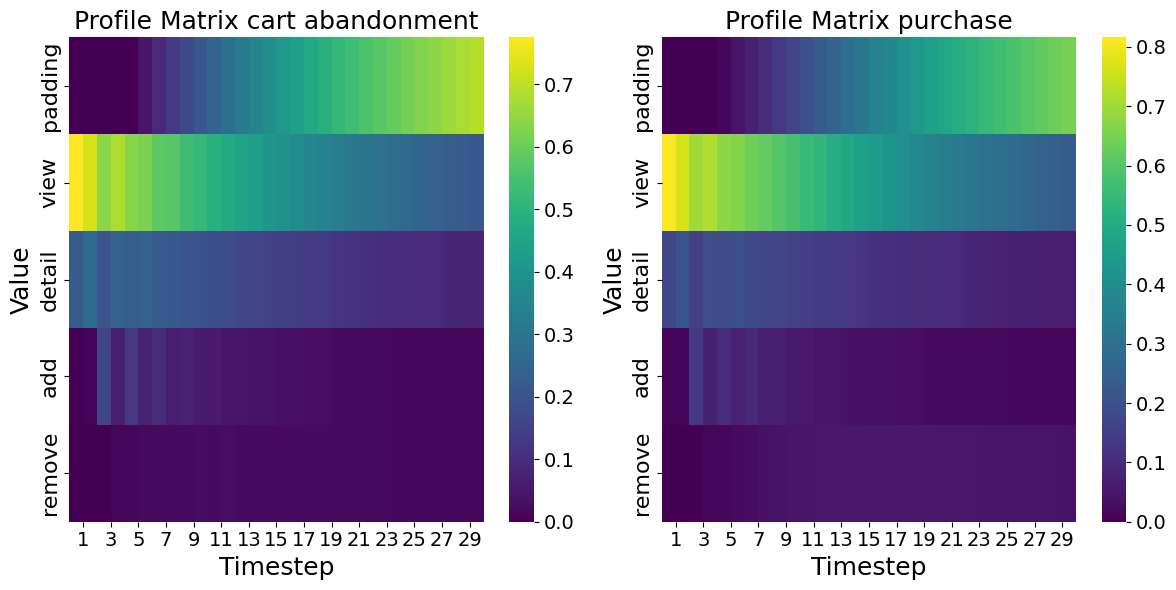

In [ ]:
# Plotting heatmaps
plt.figure(figsize=(12, 6))

yticklabels = ["padding", "view", "detail", "add", "remove"]

# Plot heatmap for profile matrix 1
plt.subplot(1, 2, 1)
ax1 = sns.heatmap(profile_matrix_ca, cmap='viridis', fmt=".2f", cbar=True, yticklabels=yticklabels)
plt.title('Profile Matrix cart abandonment', fontsize=18)
plt.xlabel('Timestep', fontsize=18)
plt.ylabel('Value', fontsize=18)
ticks = np.arange(1, 31, 2)
plt.xticks(ticks, ticks, fontsize=14)
plt.yticks(fontsize=16)
cbar = ax1.collections[0].colorbar
cbar.ax.tick_params(labelsize=14)  # Increase color bar tick labels font size

# Plot heatmap for profile matrix 2
plt.subplot(1, 2, 2)
ax2 = sns.heatmap(profile_matrix_buy, cmap='viridis', fmt=".2f", cbar=True, yticklabels=yticklabels)
plt.title('Profile Matrix purchase', fontsize=18)
plt.xlabel('Timestep', fontsize=18)
plt.ylabel('Value', fontsize=18)
ticks = np.arange(1, 31, 2)
plt.xticks(ticks, ticks, fontsize=14)
plt.yticks(fontsize=16)
cbar = ax2.collections[0].colorbar
cbar.ax.tick_params(labelsize=14)  # Increase color bar tick labels font size

plt.tight_layout()

plt.savefig('heatmap_plots.pdf', format='pdf', bbox_inches='tight')
plt.show()

In [ ]:
profile_matrix_ca1 = profile_matrix_ca[:, :30]
profile_matrix = profile_matrix_buy - profile_matrix_ca1

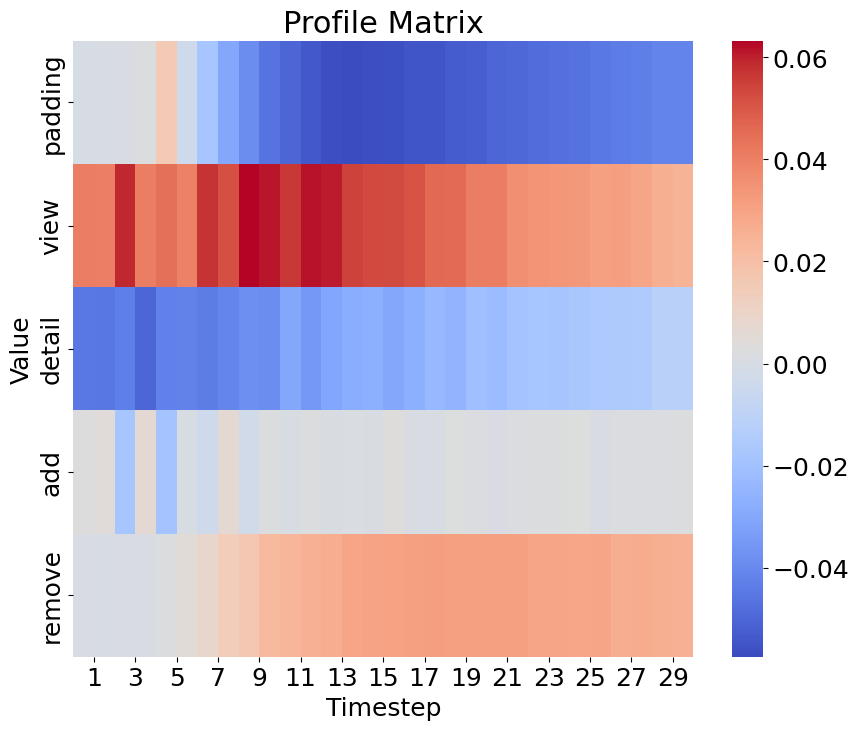

In [ ]:
# Plotting the heatmap
plt.figure(figsize=(10, 8))  # Adjust the figure size as needed
ax = sns.heatmap(profile_matrix, cmap='coolwarm', fmt=".2f", cbar=True, yticklabels=yticklabels)

# Set title and labels with increased font sizes
plt.title('Profile Matrix', fontsize=22)
plt.xlabel('Timestep', fontsize=18)
plt.ylabel('Value', fontsize=18)

# Set custom x-ticks to display every second timestep starting from 1 to 30
ticks = np.arange(1, 31, 2)
plt.xticks(ticks, ticks, fontsize=18)
plt.yticks(fontsize=18)

# Increase the font size of the color bar tick labels
cbar = ax.collections[0].colorbar
cbar.ax.tick_params(labelsize=18)  # Increase color bar tick labels font size

# Save the plot to a PDF file
plt.savefig('heatmap_plots_conc.pdf', format='pdf', bbox_inches='tight')

# Show the plot
plt.show()

In [ ]:
def initialize_motifs(sequences, k):
    if any(len(seq) < k for seq in sequences):
        raise ValueError("All sequences must have length greater than or equal to k.")
    motifs = []
    for seq in sequences:
        seq = seq.strip('[]').split(', ')  # Remove brackets and split by comma
        start = random.randint(0, len(seq) - k)
        motifs.append([int(base) for base in seq[start:start+k]])  # Convert elements to integers
    return motifs

def calculate_profile_matrix(motifs):
    profile_matrix = []
    num_bases = max(max(motif) for motif in motifs)

    for i in range(len(motifs[0])):
        column = [motif[i] for motif in motifs]
        counts = {base: column.count(base) for base in range(1, num_bases + 1)}
        total_count = sum(counts.values())
        profile_matrix.append({base: counts[base] / total_count for base in range(1, num_bases + 1)})
    return profile_matrix

def sample_position(profile_matrix, sequence, k):
    probabilities = []
    for i in range(len(sequence) - k + 1):
        motif = sequence[i:i+k]
        prob = 1.0
        for j, base in enumerate(motif):
            prob *= profile_matrix[j][base]
        probabilities.append(prob)

    # Check if the sum of probabilities is zero
    if sum(probabilities) == 0:
        return random.randint(0, len(sequence) - k)

    # Normalize probabilities
    probabilities = [p / sum(probabilities) for p in probabilities]

    # Sample a position based on probabilities
    return random.choices(range(len(probabilities)), weights=probabilities)[0]

def gibbs_sampler(sequences, k, num_iterations):
    if any(len(seq) < k for seq in sequences):
        raise ValueError("All sequences must have length greater than or equal to k.")

    motifs = initialize_motifs(sequences, k)
    for _ in range(num_iterations):
        # Check if there are sequences available for sampling
        if len(sequences) == 0:
            break

        i = random.randint(0, len(sequences) - 1)
        motifs.pop(i)
        profile_matrix = calculate_profile_matrix(motifs)
        new_position = sample_position(profile_matrix, sequences[i], k)
        motifs.insert(i, sequences[i][new_position:new_position+k])
    return motifs



# Example usage:
sequences = ca_sessions

k = 8  # Length of motif
num_iterations = 50  # Number of sampling iterations
motifs = gibbs_sampler(sequences, k, num_iterations)
print("Discovered motifs:", motifs)


ValueError: empty range for randrange() (0, -1, -1)

## t-SNE

In [ ]:
# Convert strings to lists of integers
max_length = 30
symbolised_sessions = [[int(x) for x in seq.strip('[]').split(', ')] for seq in symbolised_sessions]
symbolised_sessions = pad_sequences(symbolised_sessions, maxlen= max_length, padding='post', truncating='post')

In [ ]:
# Get the total number of instances
total_instances = len(symbolised_sessions)
sample_size = 10000

# Generate random indices for sampling
random_indices = np.random.choice(total_instances, sample_size, replace=False)

# Sample sessions and labels using the random indices
sampled_sessions = symbolised_sessions[random_indices]
sampled_labels = labels[random_indices]

In [ ]:
tsne = TSNE(perplexity=30, learning_rate=200)

# Fit and transform the data to reduce dimensionality
X_embedded = tsne.fit_transform(sampled_sessions)

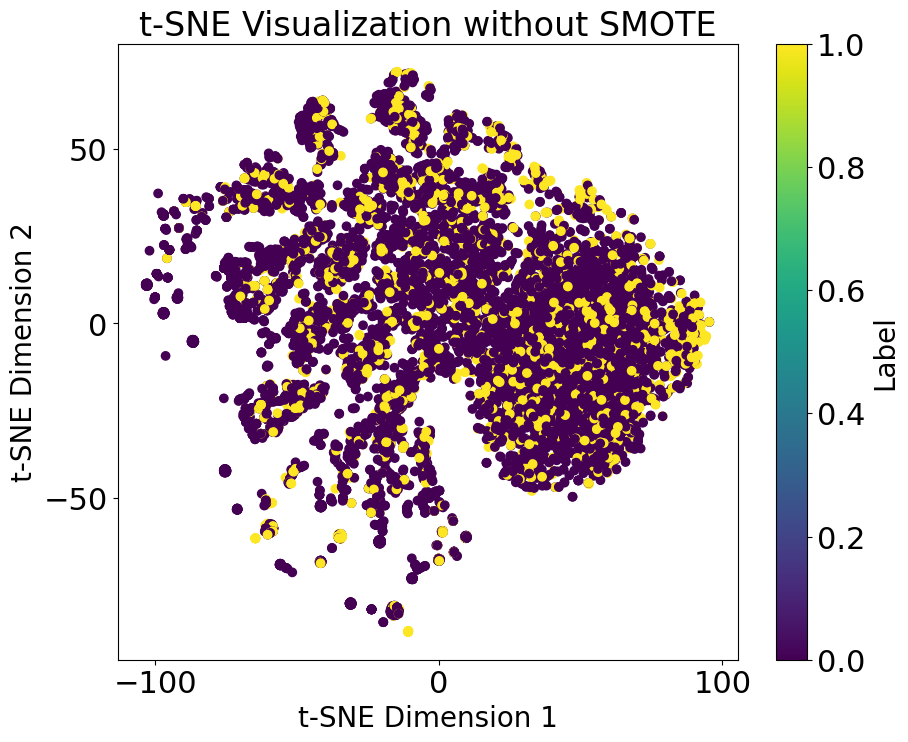

In [ ]:
# Plot the embedded data
plt.figure(figsize=(10, 8))
scatter = plt.scatter(X_embedded[:, 0], X_embedded[:, 1], marker='o', c=sampled_labels)
plt.title('t-SNE Visualization without SMOTE', fontsize=24)  # Increase title font size
plt.xlabel('t-SNE Dimension 1', fontsize=20)  # Increase x-axis label font size
plt.ylabel('t-SNE Dimension 2', fontsize=20)  # Increase y-axis label font size
plt.xticks(fontsize=22)  # Increase x-axis tick font size
plt.yticks(fontsize=22)  # Increase y-axis tick font size

# Create a colorbar with increased font size
cbar = plt.colorbar(scatter)
cbar.set_label('Label', fontsize=20)  # Set colorbar label font size
cbar.ax.tick_params(labelsize=22)  # Set colorbar tick label font size

# Save the plot to a PDF file
plt.savefig('t_SNE_without_SMOTE.pdf', format='pdf')
plt.show()

## Clickstream trajectory

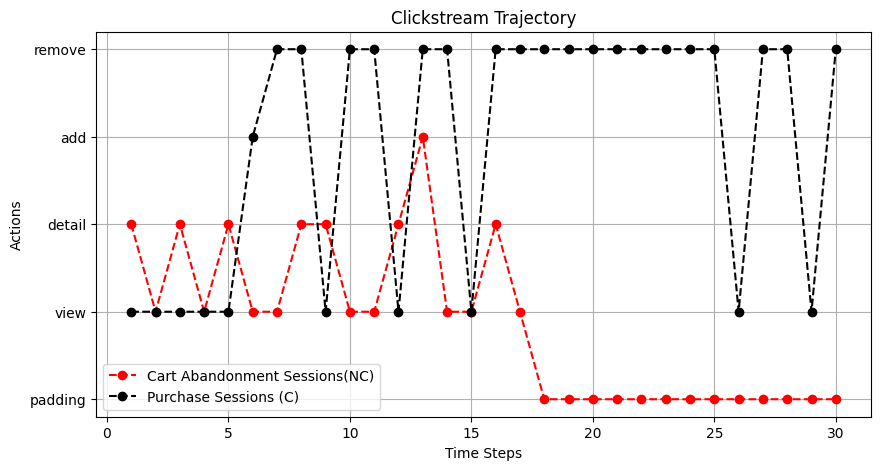

In [ ]:
cart_abandonment = [2, 1, 2, 1, 2, 1, 1, 2, 2, 1, 1, 2, 3, 1, 1, 2, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
purchase_sessions = [1, 1, 1, 1, 1, 3, 4, 4, 1, 4, 4, 1, 4, 4, 1, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 1, 4, 4, 1, 4]

# Create custom x-axis values starting from 1 to 30
time_steps = list(range(1, 31))  # Generate a list from 1 to 30

# Create a figure and a set of subplots
fig, ax = plt.subplots(figsize=(10, 5))

# Plotting both sequences with the new time_steps array
ax.plot(time_steps, cart_abandonment, marker='o', linestyle='dashed', label='Cart Abandonment Sessions(NC)', color='red')
ax.plot(time_steps, purchase_sessions, marker='o', linestyle='dashed', label='Purchase Sessions (C)', color='black')

# Adding title and labels
ax.set_title('Clickstream Trajectory')
ax.set_xlabel('Time Steps')
ax.set_ylabel('Actions')

# Setting custom y-axis labels
y_ticks = [0, 1, 2, 3, 4]
y_labels = ['padding', 'view', 'detail', 'add', 'remove']
plt.yticks(y_ticks, y_labels)

# Adding grid for better readability
ax.grid(True)

# Adding a legend to identify the plots
ax.legend()

# Show the plot
plt.show()

# Optionally, save the plot to a PDF file
fig.savefig('clickstream_trajectory.pdf')


## Distribution Events

In [ ]:
sequences_train = X['session'].tolist()
sequences_train = [[int(num) for num in item.strip("[]").split(', ')] for item in sequences_train]
# Pad sequences to a fixed length
max_length = 30  # Choose the maximum length you want
padded_sequences_train = pad_sequences(sequences_train, maxlen= max_length, padding='post', truncating='post')
# Convert padded sequences to NumPy array
sequences_train = np.array(padded_sequences_train)

In [ ]:
symbolised_sessions = sequences_train
labels = y

buy_sessions, ca_sessions = [], []
for session, label in zip(symbolised_sessions, labels):
    if label == 1:
        buy_sessions.append(session)
    else:
        ca_sessions.append(session)

In [ ]:
buy_sessions[:2]

[array([1, 1, 1, 1, 2, 3, 4, 1, 2, 1, 1, 1, 4, 4, 4, 1, 1, 4, 1, 4, 1, 4,
        4, 4, 4, 4, 4, 4, 1, 0], dtype=int32),
 array([1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 3, 4, 1, 4, 3, 4, 1, 4, 1,
        4, 4, 4, 1, 1, 4, 1, 1], dtype=int32)]

In [ ]:
# Convert numerical events to string labels if necessary
event_dict = {0: 'padding', 1: 'view', 2: 'detail', 3: 'add', 4: 'remove'}
buy_labels = np.vectorize(event_dict.get)(buy_sessions)
ca_labels = np.vectorize(event_dict.get)(ca_sessions)

# Create DataFrame for the mosaic plot
df_buy = pd.DataFrame({'Event': buy_labels, 'Session Type': 'Buy Sessions'})
df_ca = pd.DataFrame({'Event': ca_labels, 'Session Type': 'CA Sessions'})
df = pd.concat([df_buy, df_ca])

# Define color scheme
color_scheme = {
    'padding': '#fb9a99',  # light red
    'remove': '#33a02c',   # green
    'add': '#b2df8a',      # light green
    'detail': '#1f78b4',   # blue
    'view': '#a6cee3'      # light blue
}

# Function to return properties based on the event
def props(key):
    return {'color': color_scheme[key[1]], 'edgecolor': 'black'}

# Create a mosaic plot with custom properties
plt.figure(figsize=(10, 6))  # Adjust the figure size as necessary
mosaic(df, ['Session Type', 'Event'], properties=props, labelizer=lambda k: '')
plt.title('Event Distribution in Sessions')

# Save the plot to a PDF file
# plt.savefig('event_distribution_sessions.pdf')

# Show the plot on screen
plt.show()

ValueError: Per-column arrays must each be 1-dimensional

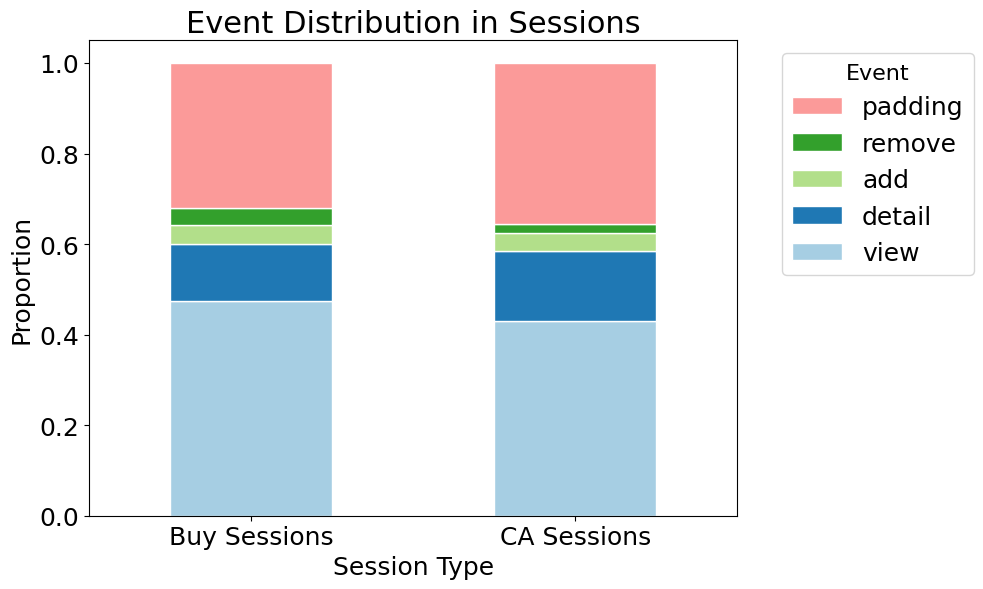

In [ ]:
# Define the actions for labeling
event_dict = {0: 'padding', 1: 'view', 2: 'detail', 3: 'add', 4: 'remove'}

# Properly flatten all session arrays into one single array
buy_flattened = np.concatenate(buy_sessions)  # Flatten all buy_sessions into one array
ca_flattened = np.concatenate(ca_sessions)    # Flatten all ca_sessions into one array

# Convert numerical events to string labels
buy_labels = np.vectorize(event_dict.get)(buy_flattened)
ca_labels = np.vectorize(event_dict.get)(ca_flattened)

# Create DataFrames for the mosaic plot
df_buy = pd.DataFrame({'Event': buy_labels, 'Session Type': ['Buy Sessions'] * len(buy_labels)})
df_ca = pd.DataFrame({'Event': ca_labels, 'Session Type': ['CA Sessions'] * len(ca_labels)})
df = pd.concat([df_buy, df_ca])

# Calculate the proportion of each event type within each session type
session_event_counts = df.groupby(['Session Type', 'Event']).size().unstack(fill_value=0)
session_event_proportions = session_event_counts.div(session_event_counts.sum(axis=1), axis=0)

# Define color scheme
color_scheme = {
    'view': '#a6cee3',      # light blue
    'detail': '#1f78b4',    # blue
    'add': '#b2df8a',       # light green
    'remove': '#33a02c',    # green
    'padding': '#fb9a99',   # light red
}

# Ensure the columns are ordered as per the desired legend order
order = ['view', 'detail', 'add', 'remove', 'padding']
session_event_proportions = session_event_proportions[order]

# Plot the stacked bar chart
fig, ax = plt.subplots(figsize=(10, 6))

bars = session_event_proportions.plot(kind='bar', stacked=True, ax=ax, color=[color_scheme[event] for event in order], edgecolor='white')

# Increase font sizes
ax.set_title('Event Distribution in Sessions', fontsize=22)
ax.set_xlabel('Session Type', fontsize=18)
ax.set_ylabel('Proportion', fontsize=18)
ax.tick_params(axis='both', which='major', labelsize=18)

# Create custom legend with increased font size
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles[::-1], labels[::-1], title='Event', bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=18, title_fontsize=16)

plt.xticks(rotation=0)
plt.tight_layout()

# Save the plot to a PDF file
plt.savefig('event_distribution_sessions.pdf', format='pdf')

plt.show()

# Models without adressing class imbalance

Train - Test Split

In [50]:
df_train = pd.read_csv("/content/drive/MyDrive/Thesis/Datasets/df_train_processed_trimmed.csv")

In [51]:
df_train.head()

session_id_hash  \
0  00000114e1075962f022114fcfc17f2d874e694ac5d201...   
1  000010504025397b03290c7457e0e7ef7ae93529f21eae...   
2  0000913afa22ba9c31efb992bcf6388b0bbfe28056bef3...   
3  00010d84aca1294479304044207fd268f63228844779c6...   
4  0001368d732951035a7ef7ef42b345a5c50b7d66966749...   

                                             session  nevents  week_day  \
0  [1, 2, 3, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 2, 1, ...       18         1   
1  [2, 1, 2, 1, 2, 1, 1, 2, 1, 1, 1, 2, 2, 1, 2, ...       81         3   
2  [1, 1, 1, 2, 1, 1, 2, 1, 1, 1, 1, 2, 1, 1, 1, ...      139         4   
3  [1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, ...       41         6   
4   [1, 2, 3, 1, 1, 2, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1]       16         3   

   weekend  hour  session_duration  conversion  unique_products_viewed  \
0    False    20            3479.0         0.0                       3   
1    False    12            2024.0         0.0                      10   
2    False    14            3647.0         0.0                      23   
3     True    18            2612.0         0.0                       3   
4    False     3             265.0         0.0                       1   

   avg_dwell_time  
0      193.277778  
1       24.987654  
2       26.237410  
3       63.707317  
4       16.562500

In [52]:
X = df_train[["session_id_hash", "session"]]  # Features
y = df_train["conversion"]  # Target variable

# Splitting the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## Markov Chain

In [8]:
df_train = pd.read_csv("/content/drive/MyDrive/Thesis/Datasets/df_train_processed.csv")

In [9]:
df_train.head()

session_id_hash     event_type  \
0  8256e7aaf7ade5e68787f3118077de97ae8eec18f47f97...  event_product   
1  8256e7aaf7ade5e68787f3118077de97ae8eec18f47f97...       pageview   
2  8256e7aaf7ade5e68787f3118077de97ae8eec18f47f97...       pageview   
3  8256e7aaf7ade5e68787f3118077de97ae8eec18f47f97...       pageview   
4  8256e7aaf7ade5e68787f3118077de97ae8eec18f47f97...  event_product   

  product_action                                   product_sku_hash  \
0         detail  293231f99098fc9552a19111d8ed7b6188bf0721b1a501...   
1           view                                                NaN   
2           view                                                NaN   
3           view                                                NaN   
4         detail  36e8246f800db10613eef89c81513df909ec8171a875f0...   

   server_timestamp_epoch_ms  \
0              1551545503415   
1              1551545503415   
2              1551545510494   
3              1551545514312   
4              1551545514312   

                                          hashed_url  addcart  convert  \
0  4e8321996f16f2734a5af4b4c780b4c4669fb316cf24ad...     True     True   
1  4e8321996f16f2734a5af4b4c780b4c4669fb316cf24ad...     True     True   
2  744ac6435f90719fdec0276541a5c481138cc1f2f51106...     True     True   
3  15c3f072fa3c3caa710d9cc114fa017f37deb117ec158c...     True     True   
4  15c3f072fa3c3caa710d9cc114fa017f37deb117ec158c...     True     True   

   nevents  product_action_symb  conversion                     date  \
0       13                    2         1.0  2019-03-02 16:51:43.415   
1       13                    1         1.0  2019-03-02 16:51:43.415   
2       13                    1         1.0  2019-03-02 16:51:50.494   
3       13                    1         1.0  2019-03-02 16:51:54.312   
4       13                    2         1.0  2019-03-02 16:51:54.312   

   week_day  weekend  month  hour  session_duration  unique_products_viewed  \
0         5     True      3    16            1107.0                       2   
1         5     True      3    16            1107.0                       2   
2         5     True      3    16            1107.0                       2   
3         5     True      3    16            1107.0                       2   
4         5     True      3    16            1107.0                       2   

   avg_dwell_time  
0       85.153846  
1       85.153846  
2       85.153846  
3       85.153846  
4       85.153846

In [10]:
df_train = df_train.groupby('session_id_hash').agg({'product_action_symb': list, 'conversion': 'first'}).reset_index()

In [11]:
df_train = df_train.rename(columns={'product_action_symb': 'session'})
df_train.head(10)

session_id_hash  \
0  00000114e1075962f022114fcfc17f2d874e694ac5d201...   
1  000010504025397b03290c7457e0e7ef7ae93529f21eae...   
2  0000913afa22ba9c31efb992bcf6388b0bbfe28056bef3...   
3  00010d84aca1294479304044207fd268f63228844779c6...   
4  0001368d732951035a7ef7ef42b345a5c50b7d66966749...   
5  0001c180fb742f96ff388ba8f67a568e6fa66aed30d0d2...   
6  00024a2cbef8be2015bf16d355226c4b4d60b4e5216dea...   
7  0002629c632e1d3211649ba4498194a13a280c35c6bd57...   
8  00029b95dceb71ae63445fb5fdc844104aabd047793277...   
9  0002cc06d46d4835503b88e9eed2c8fc1ae97f5cc262a9...   

                                             session  conversion  
0  [1, 2, 3, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 2, 1, ...         0.0  
1  [2, 1, 2, 1, 2, 1, 1, 2, 1, 1, 1, 2, 2, 1, 2, ...         0.0  
2  [1, 1, 1, 2, 1, 1, 2, 1, 1, 1, 1, 2, 1, 1, 1, ...         0.0  
3  [1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, ...         0.0  
4   [1, 2, 3, 1, 1, 2, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1]         0.0  
5  [1, 1, 1, 1, 2, 3, 4, 1, 2, 1, 1, 1, 4, 4, 4, ...         1.0  
6  [1, 2, 2, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...         0.0  
7  [1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 3, 4, ...         1.0  
8  [1, 1, 1, 1, 2, 1, 1, 2, 1, 1, 2, 1, 1, 1, 1, ...         0.0  
9  [1, 2, 2, 1, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, ...         0.0

In [12]:
df_train.shape

(199391, 3)

In [13]:
X = df_train[["session_id_hash", "session"]]  # Features
y = df_train["conversion"]  # Target variable

# Splitting the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [14]:
sequences_train = X_train['session'].tolist()
sequences_test = X_test['session'].tolist()

# Pad sequences to a fixed length
max_length = 30
padded_sequences_train = pad_sequences(sequences_train, maxlen= max_length, padding='post', truncating='post')
padded_sequences_test = pad_sequences(sequences_test, maxlen= max_length, padding='post', truncating='post')

# Convert padded sequences to NumPy array
sequences_train = np.array(padded_sequences_train)
labels_train = np.array(y_train)
sequences_test = np.array(padded_sequences_test)
labels_test = np.array(y_test)

In [15]:
def get_transitions(sessions):
    n_events = len(set(item for session in sessions for item in session if item != 0))
    transitions = np.zeros((n_events, n_events))
    for session in sessions:
        for i, event in enumerate(session):
            # If the event is not 0 and there is a next event in the session
            if event != 0 and i < len(session) - 1:
                transitions[event - 1, session[i + 1] - 1] += 1
    row_sums = transitions.sum(axis=1)
    return transitions / row_sums[:, np.newaxis]

# Example usage
transitions_session = get_transitions(sequences_train)

In [16]:
transitions_session[:7]

array([[6.02924715e-01, 2.78256787e-01, 4.88495781e-02, 2.26616328e-02,
        4.73072864e-02],
       [7.63370598e-01, 1.03243505e-01, 1.09265995e-01, 5.78581093e-03,
        1.83340914e-02],
       [7.46728958e-01, 7.78434276e-02, 4.78785936e-02, 8.21284803e-02,
        4.54205408e-02],
       [5.20335446e-01, 1.70167159e-03, 7.28710302e-02, 3.86918752e-01,
        1.81731004e-02],
       [6.93037058e-01, 3.87232195e-03, 0.00000000e+00, 3.61899247e-05,
        3.03054430e-01]])

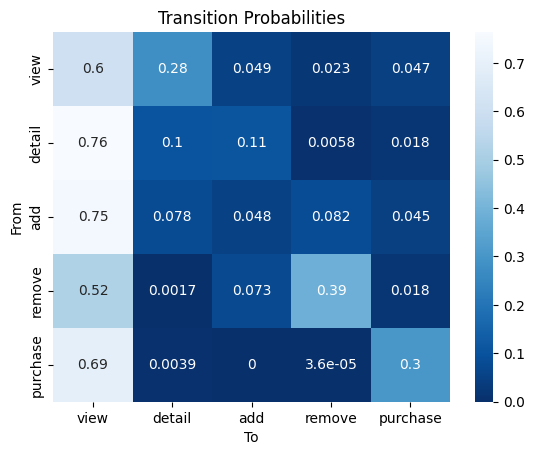

In [17]:
%matplotlib inline
actions = ["view", "detail", "add", "remove", "purchase"]
ax = sns.heatmap(transitions_session, cmap='Blues_r',xticklabels = actions, yticklabels = actions, annot = True)
# We read the heatmap as a conditional probability from the row event to the column event
ax.set_title('Transition Probabilities')
plt.xlabel('To')
plt.ylabel('From')

# Save the figure to a PDF file
# plt.savefig('transition_matrix.pdf', format='pdf')

# Display the plot
plt.show()

In [18]:
class MarkovChain:
    def __init__(self, transition_matrix, actions):
        self.transition_matrix = transition_matrix
        self.actions = actions

    def predict_purchase_probability(self, sequence):
        final_state = sequence[-1]  # Last action in the sequence
        purchase_probability = self.transition_matrix[final_state - 1][self.actions.index(5)]
        return purchase_probability

actions = [1, 2, 3, 4, 5]
# Example usage:
transition_matrix = np.array([[6.02924715e-01, 2.78256787e-01, 4.88495781e-02, 2.26616328e-02, 4.73072864e-02],
                              [7.63370598e-01, 1.03243505e-01, 1.09265995e-01, 5.78581093e-03, 1.83340914e-02],
                              [7.46728958e-01, 7.78434276e-02, 4.78785936e-02, 8.21284803e-02, 4.54205408e-02],
                              [5.20335446e-01, 1.70167159e-03, 7.28710302e-02, 3.86918752e-01, 1.81731004e-02],
                              [6.93037058e-01, 3.87232195e-03, 0.00000000e+00, 3.61899247e-05, 3.03054430e-01]])

markov_model = MarkovChain(transition_matrix, actions)

# Example clickstream sequence
clickstream_sequence = [1, 2, 3, 4, 4, 5]

# Predict purchase probability
purchase_probability = markov_model.predict_purchase_probability(clickstream_sequence)
print("Probability of purchase:", purchase_probability)

Probability of purchase: 0.30305443


In [19]:
def predict_df(df):
    predictions = []
    true_labels = []
    for index, row in df.iterrows():
        sequence = row['session']
        purchase_probability = markov_model.predict_purchase_probability(sequence)
        predicted_label = 1 if purchase_probability > random.random() else 0
        predictions.append(predicted_label)
        true_labels.append(row['conversion'])
    return predictions, true_labels

data = {'session': X_train["session"], 'conversion': y_train}
X_train = pd.DataFrame(data)

# Make predictions on the dataframe
predicted_labels, true_labels = predict_df(X_train)

# Calculate F1 score
f1 = f1_score(true_labels, predicted_labels)
print("F1 Score:", f1)

F1 Score: 0.17355787082541554


In [20]:
def predict_df(df):
    predictions = []
    true_labels = []
    for index, row in df.iterrows():
        sequence = row['session']
        purchase_probability = markov_model.predict_purchase_probability(sequence)
        predicted_label = 1 if purchase_probability > random.random() else 0
        predictions.append(predicted_label)
        true_labels.append(row['conversion'])
    return predictions, true_labels

data = {'session': X_test["session"], 'conversion': y_test}
X_test = pd.DataFrame(data)

# Make predictions on the dataframe
predicted_labels_mv, true_labels = predict_df(X_test)

# Calculate F1 score
f1 = f1_score(true_labels, predicted_labels_mv)
print("F1 Score:", f1)


F1 Score: 0.16442239546420978


### Error Analysis

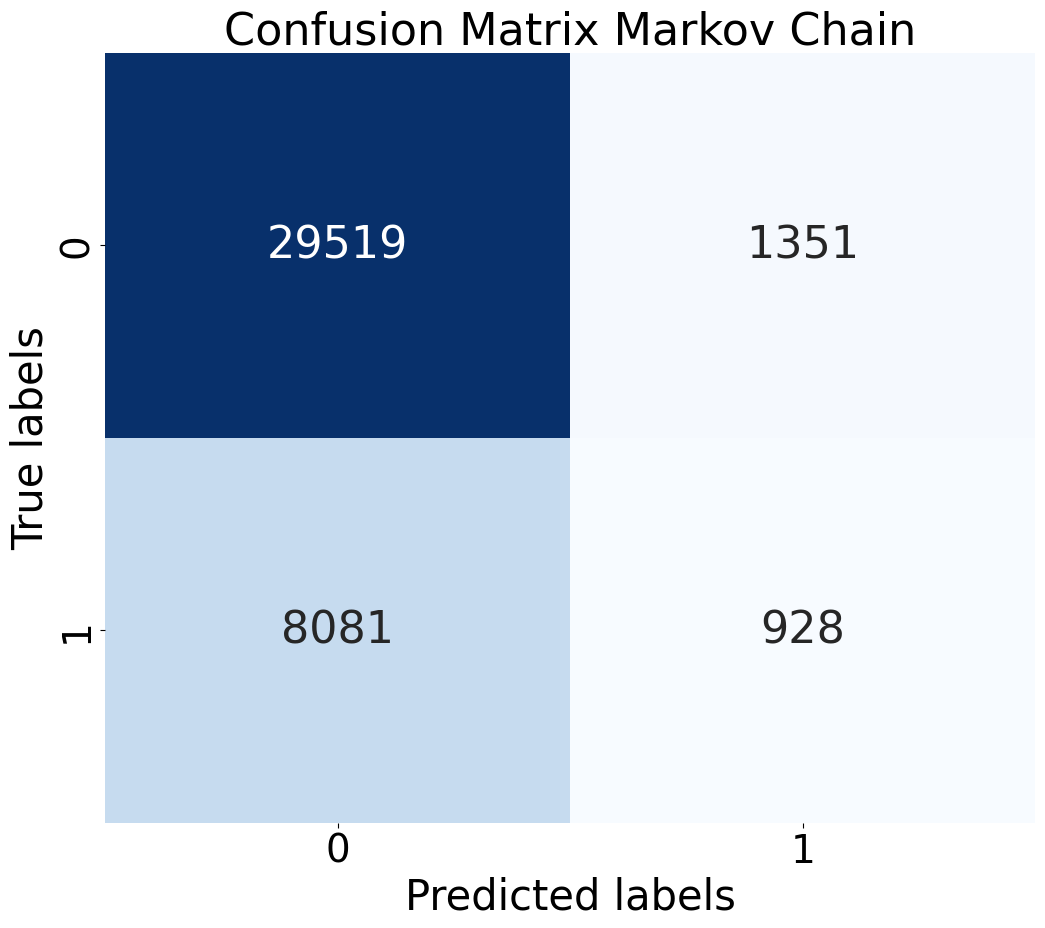

In [22]:
conf_matrix = confusion_matrix(true_labels, predicted_labels_mv)

# Plot confusion matrix
plt.figure(figsize=(12, 10))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False, annot_kws={"size": 32})
plt.xlabel('Predicted labels', fontsize=30)
plt.ylabel('True labels', fontsize=30)
plt.title('Confusion Matrix Markov Chain', fontsize=32)
plt.xticks(fontsize=28)
plt.yticks(fontsize=28)
plt.savefig('Confusion_Matrix_MV.pdf', format='pdf')
plt.show()

In [ ]:
# Compute confusion matrix and classification report
conf_matrix = confusion_matrix(y_test, y_pred_binary_GRU)
cr_error = classification_report(y_test, y_pred_binary_GRU)
print(cr_error)

# Plot confusion matrix
plt.figure(figsize=(12, 10))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False, annot_kws={"size": 32})
plt.xlabel('Predicted labels', fontsize=30)
plt.ylabel('True labels', fontsize=30)
plt.title('Confusion Matrix GRU', fontsize=32)
plt.xticks(fontsize=28)
plt.yticks(fontsize=28)
plt.savefig('Confusion_Matrix_GRU.pdf', format='pdf')
plt.show()

## Markov Chain Second Order

In [ ]:
class SecondOrderMarkovChain:
    def __init__(self, num_states):
        self.num_states = num_states
        self.transition_matrix = np.zeros((num_states, num_states, num_states))

    def train(self, sequences):
        for sequence in sequences:
            trimmed_sequence = np.trim_zeros(sequence, 'b')
            for i in range(2, len(trimmed_sequence)):
                self.transition_matrix[trimmed_sequence[i-2]-1, trimmed_sequence[i-1]-1, trimmed_sequence[i]-1] += 1

        # Normalize transition probabilities
        for i in range(self.num_states):
            for j in range(self.num_states):
                total = np.sum(self.transition_matrix[i, j])
                if total > 0:
                    self.transition_matrix[i, j] /= total

    def predict_probability(self, sequence):
        if len(sequence) < 2:
            return 0
        prev_prev_state = sequence[-2] - 1
        prev_state = sequence[-1] - 1
        probabilities = self.transition_matrix[prev_prev_state, prev_state]
        return np.sum(probabilities)  # Sum of probabilities to next states

def create_and_train_model(sequences, num_states):
    model = SecondOrderMarkovChain(num_states)
    model.train(sequences)
    return model

# Split your data based on the labels
sequences_label_0 = sequences_train[labels_train == 0]
sequences_label_1 = sequences_train[labels_train == 1]

num_states = 5  # Assuming 5 possible states, adjust as needed

# Train two separate models
model_0 = create_and_train_model(sequences_label_0, num_states)
model_1 = create_and_train_model(sequences_label_1, num_states)

# Function to predict label for a new sequence
def predict_sequence_label(sequence, model_0, model_1):
    probability_0 = model_0.predict_probability(sequence)
    probability_1 = model_1.predict_probability(sequence)
    return 0 if probability_0 > probability_1 else 1

# Predict and evaluate on the test set
predicted_labels = [predict_sequence_label(seq, model_0, model_1) for seq in sequences_test]
f1 = f1_score(labels_test, predicted_labels)
print("F1 Score:", f1)

F1 Score: 0.3359620350338474


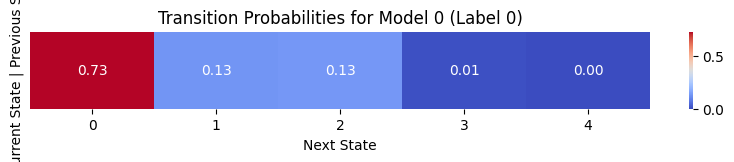

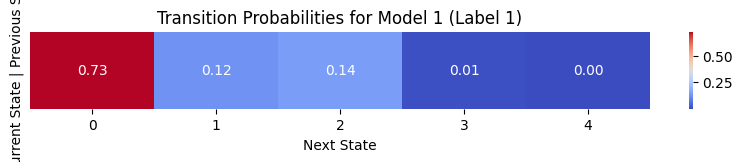

In [ ]:
def display_transition_matrix(matrix_slice, title):
    # Reshape the matrix slice (1D array) into a 2D array for heatmap display
    matrix_slice_2d = matrix_slice.reshape(-1, len(matrix_slice))
    plt.figure(figsize=(10, 1))  # Adjust figure size to fit the elongated shape of the matrix slice
    sns.heatmap(matrix_slice_2d, annot=True, fmt=".2f", cmap='coolwarm', yticklabels=False)
    plt.title(title)
    plt.xlabel('Next State')
    plt.ylabel('Current State | Previous State')
    plt.show()

# Example state indices
i, j = 0, 1  # Indices for the previous and current state
display_transition_matrix(model_0.transition_matrix[i, j], "Transition Probabilities for Model 0 (Label 0)")
display_transition_matrix(model_1.transition_matrix[i, j], "Transition Probabilities for Model 1 (Label 1)")

In [ ]:
i, j, k = 1, 2, 3  # Example states
print(f"Probability of transitioning from ({i+1}, {j+1}) to {k+1} in model 0: {model_0.transition_matrix[i, j, k]:.4f}")
print(f"Probability of transitioning from ({i+1}, {j+1}) to {k+1} in model 1: {model_1.transition_matrix[i, j, k]:.4f}")


Probability of transitioning from (2, 3) to 4 in model 0: 0.0648
Probability of transitioning from (2, 3) to 4 in model 1: 0.0821


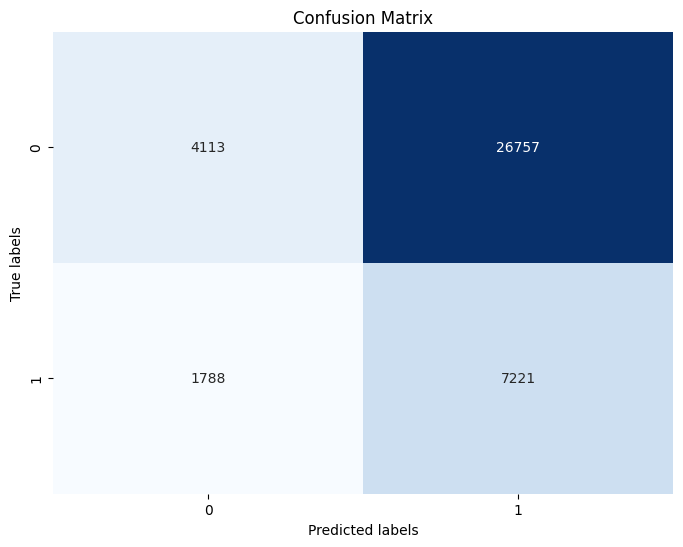

In [ ]:
conf_matrix = confusion_matrix(labels_test, predicted_labels)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

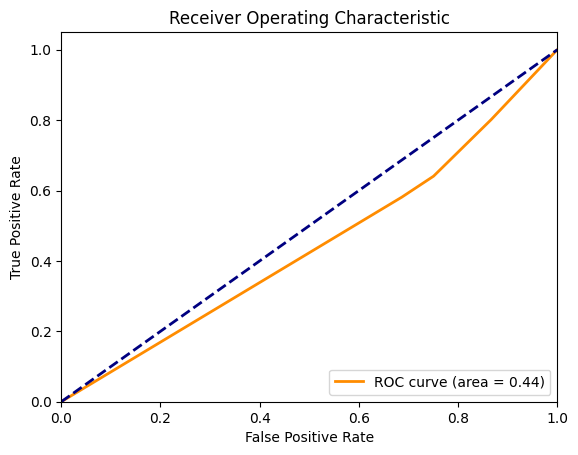

In [ ]:
import numpy as np
from sklearn.metrics import roc_curve, auc, f1_score
import matplotlib.pyplot as plt

class SecondOrderMarkovChain:
    def __init__(self, num_states):
        self.num_states = num_states
        self.transition_matrix = np.zeros((num_states, num_states, num_states))

    def train(self, sequences):
        for sequence in sequences:
            trimmed_sequence = np.trim_zeros(sequence, 'b')
            for i in range(2, len(trimmed_sequence)):
                self.transition_matrix[trimmed_sequence[i-2]-1, trimmed_sequence[i-1]-1, trimmed_sequence[i]-1] += 1

        # Normalize transition probabilities
        for i in range(self.num_states):
            for j in range(self.num_states):
                total = np.sum(self.transition_matrix[i, j])
                if total > 0:
                    self.transition_matrix[i, j] /= total

    def predict_probability(self, sequence):
        if len(sequence) < 2:
            return 0
        prev_prev_state = sequence[-2] - 1
        prev_state = sequence[-1] - 1
        probabilities = self.transition_matrix[prev_prev_state, prev_state]
        return np.sum(probabilities)  # Sum of probabilities to next states

def create_and_train_model(sequences, num_states):
    model = SecondOrderMarkovChain(num_states)
    model.train(sequences)
    return model

# Assuming sequences_train and labels_train are defined
num_states = 5  # Adjust the number of states as needed

# Train two separate models for the two classes
model_0 = create_and_train_model(sequences_train[labels_train == 0], num_states)
model_1 = create_and_train_model(sequences_train[labels_train == 1], num_states)

# Modify prediction function to return probabilities
def predict_sequence_probability(sequence, model_0, model_1):
    probability_0 = model_0.predict_probability(sequence)
    probability_1 = model_1.predict_probability(sequence)
    return probability_1 / (probability_0 + probability_1) if (probability_0 + probability_1) > 0 else 0

# Generate probabilities for the test set
probabilities = [predict_sequence_probability(seq, model_0, model_1) for seq in sequences_test]

# Calculate ROC curve and AUC
fpr, tpr, thresholds = roc_curve(labels_test, probabilities)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()


In [ ]:
probabilities[:5]

[1.0, 1.0, 0.49999999999999994, 1.0, 0.5]

## GRU

In [53]:
X_train.head()

session_id_hash  \
317     006663e8030ec06f59b5f7b9401fc5a85fedfba541296a...   
150615  c0ea26f06f885f2e647ff6c945f64621596170c285f857...   
191502  f5d3c2a190d0fe44b3f5cb6b093dd8e1092ac9d7f29fe4...   
181330  e8b5f2ba42ff1168c314d7220983403053457ddf968c7b...   
147450  bce118d59635f73d6afa0816e5fa154d7a4ce65f651a42...   

                                                  session  
317     [1, 1, 2, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, ...  
150615  [1, 2, 2, 1, 1, 2, 1, 2, 1, 2, 1, 2, 3, 1, 2, ...  
191502  [1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 2, 1, 1, 1, ...  
181330  [1, 2, 3, 4, 1, 4, 1, 4, 4, 1, 4, 4, 4, 4, 4, ...  
147450  [1, 1, 1, 1, 2, 1, 1, 1, 1, 2, 3, 1, 2, 1, 1, ...

In [54]:
sequences_train = X_train['session'].tolist()
sequences_test = X_test['session'].tolist()
sequences_train = [[int(num) for num in item.strip("[]").split(', ')] for item in sequences_train]
sequences_test = [[int(num) for num in item.strip("[]").split(', ')] for item in sequences_test]

# Pad sequences to a fixed length
max_length = 30  # Choose the maximum length you want
padded_sequences_train = pad_sequences(sequences_train, maxlen= max_length, padding='post', truncating='post')
padded_sequences_test = pad_sequences(sequences_test, maxlen= max_length, padding='post', truncating='post')

# Convert padded sequences to NumPy array
sequences_train = np.array(padded_sequences_train)
labels_train = np.array(y_train)
sequences_test = np.array(padded_sequences_test)
labels_test = np.array(y_test)

In [55]:
# Split the data into train, validation, and test sets
X_train, X_val, y_train, y_val = train_test_split(sequences_train, labels_train, test_size=0.25, random_state=42)  # 0.25 x 0.8 = 0.2

# Reshape the input data to match the expected input shape of the GRU layer
X_train_reshaped = np.expand_dims(X_train, axis=-1)
X_val_reshaped = np.expand_dims(X_val, axis=-1)

In [56]:
X_train_reshaped.shape

(119619, 30, 1)

In [57]:
X_val_reshaped.shape

(39874, 30, 1)

In [ ]:
# Define the GRU model with increased complexity and additional techniques
model_GRU = Sequential([
    GRU(32, input_shape=(None, 1)),
    Dropout(0),
    Dense(32, activation='relu'),
    Dense(1, activation='sigmoid')
])

# Compile the model with Adam optimizer and a lower learning rate
optimizer = Adam(learning_rate=0.01)
model_GRU.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
history = model_GRU.fit(X_train_reshaped, y_train, epochs=10, batch_size=128, validation_data=(X_val_reshaped, y_val))

Epoch 1/10
935/935 [==============================] - 8s 7ms/step - loss: 0.4928 - accuracy: 0.7772 - val_loss: 0.4413 - val_accuracy: 0.7807
Epoch 2/10
935/935 [==============================] - 7s 7ms/step - loss: 0.4369 - accuracy: 0.7821 - val_loss: 0.4375 - val_accuracy: 0.7825
Epoch 3/10
935/935 [==============================] - 6s 6ms/step - loss: 0.4315 - accuracy: 0.7830 - val_loss: 0.4336 - val_accuracy: 0.7834
Epoch 4/10
935/935 [==============================] - 7s 7ms/step - loss: 0.4290 - accuracy: 0.7841 - val_loss: 0.4289 - val_accuracy: 0.7832
Epoch 5/10
935/935 [==============================] - 5s 6ms/step - loss: 0.4277 - accuracy: 0.7850 - val_loss: 0.4307 - val_accuracy: 0.7876
Epoch 6/10
935/935 [==============================] - 7s 7ms/step - loss: 0.4238 - accuracy: 0.7865 - val_loss: 0.4252 - val_accuracy: 0.7857
Epoch 7/10
935/935 [==============================] - 6s 6ms/step - loss: 0.4229 - accuracy: 0.7870 - val_loss: 0.4262 - val_accuracy: 0.7870
Epoch 

In [ ]:
# 1	batch size: 64;	Dropout: 0.00;	Learning Rate: 0.001 --> 0.52443 (Threshold = 0.23)
# 2	batch size: 128;	Dropout: 0.00;	Learning Rate: 0.001 --> 0.52131 (Threshold = 0.29)
# 3	batch size: 32;	Dropout: 0.00;	Learning Rate: 0.001 --> 0.52541 (Threshold = 0.24)
# 4	batch size: 32;	Dropout: 0.00;	Learning Rate: 0.010 --> 0.51447 (Threshold = 0.27)


# 5	batch size: 128; 	Dropout:0.00; 	Learning Rate: 0.010 --> 0.52750 (Threshold = 0.27)

In [ ]:
model_save_name = 'model_GRU.h5'
path = "/content/drive/MyDrive/Thesis/Models/" + model_save_name
model_GRU.save(path)

In [ ]:
# Load the model from the saved HDF5 file
model_save_name = 'model_GRU.h5'
path = "/content/drive/MyDrive/Thesis/Models/" + model_save_name
model_GRU = load_model(path)

In [ ]:
# Predict labels for the test set
y_pred = model_GRU.predict(X_train_reshaped)
y_pred_binary = (y_pred > 0.27).astype(int)  # Convert probabilities to binary predictions

# Calculate the F1 score
f1 = f1_score(y_train, y_pred_binary)

print("F1 Score:", f1)

3739/3739 [==============================] - 33s 9ms/step
F1 Score: 0.5303180105878378


In [ ]:
# Predict labels for the test set
y_pred = model_GRU.predict(X_val_reshaped)
y_pred_binary = (y_pred > 0.27).astype(int)  # Convert probabilities to binary predictions

# Calculate the F1 score
f1 = f1_score(y_val, y_pred_binary)

print("F1 Score:", f1)

1247/1247 [==============================] - 10s 8ms/step
F1 Score: 0.523914588085711


In [ ]:
# Predict labels for the test set
y_pred = model_GRU.predict(padded_sequences_test)
y_pred_binary_GRU = (y_pred > 0.27).astype(int)  # Convert probabilities to binary predictions

# Calculate the F1 score
f1 = f1_score(y_test, y_pred_binary_GRU)

print("F1 Score:", f1)

1247/1247 [==============================] - 10s 7ms/step
F1 Score: 0.5275088193349846


### Hyperparameter Tuning

In [ ]:
import logging
import pandas as pd
from sklearn.metrics import f1_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dropout, Dense
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from kerastuner import HyperParameters
from kerastuner.tuners import GridSearch

# Suppress TensorFlow logging
logging.getLogger('tensorflow').setLevel(logging.ERROR)

# Define a function to build the model
def build_model(hp):
    model = Sequential()
    model.add(GRU(units=32, input_shape=(None, 1)))
    model.add(Dropout(rate=hp.Float('dropout', min_value=0.0, max_value=0.5, step=0.25)))
    model.add(Dense(units=32, activation="relu"))
    model.add(Dense(1, activation="sigmoid"))
    learning_rate = hp.Choice("learning_rate", [0.001, 0.01])
    batch_size = hp.Choice("batch_size", [128, 64, 32])
    optimizer = Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
    return model

# Initialize a GridSearch tuner
tuner = GridSearch(
    build_model,
    objective='val_loss')

# Perform the search
tuner.search(X_train_reshaped, y_train, epochs=10, validation_data=(X_val_reshaped, y_val))

# Get the best hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
print("Best Hyperparameters:")
print(best_hps.values)

Trial 18 Complete [00h 04m 24s]
val_loss: 0.44654446840286255

Best val_loss So Far: 0.42483192682266235
Total elapsed time: 01h 22m 42s
Best Hyperparameters:
{'dropout': 0.0, 'learning_rate': 0.001, 'batch_size': 64}


In [ ]:
hyperparameters_data = []
for trial in tuner.oracle.get_best_trials(num_trials=len(tuner.oracle.trials)):
    hyperparameters = trial.hyperparameters.values
    val_loss = trial.score
    hyperparameters_data.append({
        'Batch Size': hyperparameters['batch_size'],
        'Dropout': hyperparameters['dropout'],
        'Learning Rate': hyperparameters['learning_rate'],
        'Validation Loss': val_loss
    })

# Create DataFrame
df_results_GRU = pd.DataFrame(hyperparameters_data)

In [ ]:
df_results_GRU

Batch Size  Dropout  Learning Rate  Validation Loss
0           64     0.00          0.001         0.424832
1          128     0.00          0.001         0.424850
2           32     0.00          0.001         0.426645
3           32     0.00          0.010         0.427222
4          128     0.00          0.010         0.428786
5          128     0.25          0.001         0.428916
6           32     0.50          0.001         0.430197
7           32     0.25          0.001         0.430277
8          128     0.50          0.001         0.430381
9           64     0.25          0.001         0.431359
10          64     0.50          0.001         0.432767
11          32     0.25          0.010         0.434273
12          64     0.00          0.010         0.434358
13         128     0.25          0.010         0.436243
14          64     0.25          0.010         0.436990
15          32     0.50          0.010         0.446544
16          64     0.50          0.010         0.457005
17         128     0.50          0.010         0.457728

In [ ]:
df_results_GRU.to_csv("/content/drive/MyDrive/Thesis/Datasets/df_results_GRU.csv", index = False)

NameError: name 'df_results_GRU' is not defined

In [ ]:
df_results_GRU = pd.read_csv("/content/drive/MyDrive/Thesis/Datasets/df_results_GRU.csv")

In [ ]:
results_df = df_results_GRU

In [ ]:
fig = go.Figure(data=
    go.Parcoords(
        line = dict(color = results_df['Validation Loss'], colorscale = 'Tealrose', showscale = True),
        dimensions = list([
            dict(range = [min(results_df['Dropout']), max(results_df['Dropout'])],
                 label = 'Dropout', values = results_df['Dropout']),
            dict(range = [min(results_df['Batch Size']), max(results_df['Batch Size'])],
                 label = 'Batch Size', values = results_df['Batch Size']),
            dict(range = [min(results_df['Learning Rate']), max(results_df['Learning Rate'])],
                 label = 'Learning Rate', values = results_df['Learning Rate']),
            dict(range = [min(results_df['Validation Loss']), max(results_df['Validation Loss'])],
                 label = 'Validation Loss', values = results_df['Validation Loss'])
        ])
    )
)

fig.show()

In [ ]:
# Define hyperparameters and F1 scores
hyperparameters = ['Dropout Rate', 'Batch Size', 'Learning Rate']
vl_scores = ['Validation Loss']

# Create pairplot
fig = ff.create_scatterplotmatrix(
    results_df,
    diag='histogram',
    index='Validation Loss',
    colormap='Rainbow',
    colormap_type='seq',
    height=800,
    width=800
)

# Update layout
fig.update_layout(
    title='Pairplot of Hyperparameters vs Validation loss',
    xaxis=dict(title='Hyperparameters'),
    yaxis=dict(title='Hyperparameters')
)

fig.show()

In [ ]:
import plotly.graph_objects as go
import plotly.io as pio

# Create the contour plot
fig = go.Figure(data=go.Contour(
    x=results_df['Dropout'],
    y=results_df['Learning Rate'],
    z=results_df['Validation Loss'],
    colorscale='Tealrose',  # Choose a colorscale
    colorbar=dict(
        title=dict(text='Validation Loss', font=dict(size=22)),
        thickness=50,  # Increase the thickness of the colorbar
        len=1.1,
        tickfont=dict(size=18)
    ),
))

# Update layout with increased font sizes
fig.update_layout(
    title=dict(text='Contour Plot of Hyperparameters GRU', font=dict(size=22)),
    xaxis=dict(title=dict(text='Dropout Rate', font=dict(size=22)), tickfont=dict(size=18)),
    yaxis=dict(title=dict(text='Learning Rate', font=dict(size=22)), tickfont=dict(size=18))
)

fig.show()
pio.write_image(fig, 'hyperparameters_contour_plot_GRU.pdf')

### SHAP

#### Shapelets

In [ ]:
pip install tslearn

In [ ]:
from tslearn.shapelets import LearningShapelets
model = LearningShapelets(n_shapelets_per_size={3: 2})
model.fit(reshaped_data_train, labels_train)
train_distances = model.transform(reshaped_data_train)
test_distances = model.transform(reshaped_data_test)
shapelets = model.shapelets_as_time_series_

In [ ]:
shapelets[0]

array([[0.53376371],
       [0.30682907],
       [1.88625026]])

In [ ]:
train_distances - test_distances

array([[ 0.        ,  0.        ],
       [ 0.        ,  0.        ],
       [ 0.        ,  0.        ],
       [ 1.0528865 ,  1.46641   ],
       [ 0.        , -0.2665688 ],
       [ 0.        ,  0.        ],
       [ 0.        ,  0.        ],
       [ 0.        ,  0.        ],
       [ 0.        ,  0.        ],
       [ 0.        ,  0.        ],
       [ 0.        , -0.2666855 ],
       [ 0.        ,  0.        ],
       [ 0.        ,  0.        ],
       [ 0.        , -0.40009817],
       [ 0.        ,  0.        ]], dtype=float32)

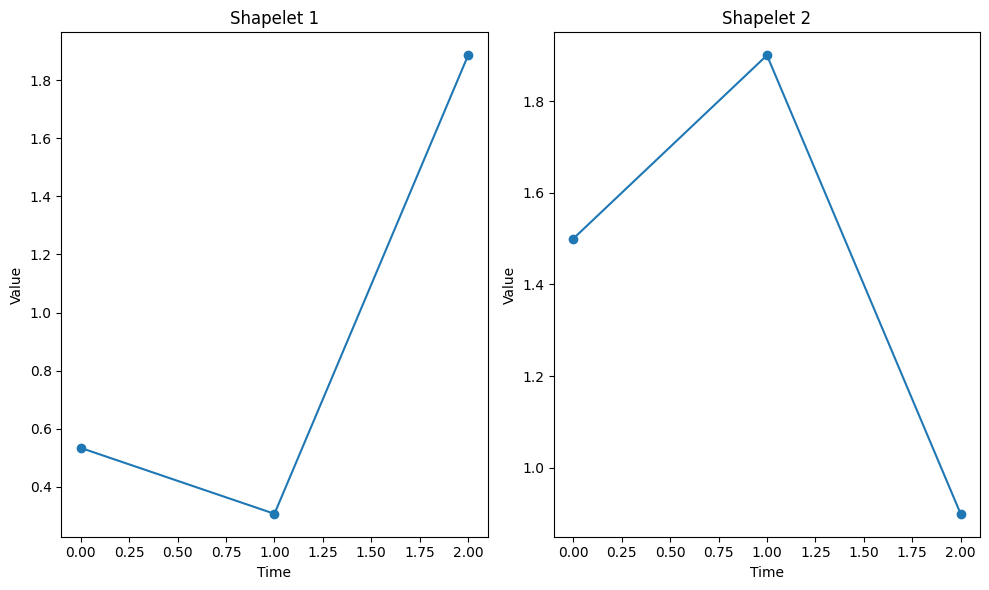

In [ ]:
# Assuming shapelets is a numpy array containing the learned shapelets
# shapelets.shape should be (n_shapelets, shapelet_length, n_features)

# Plot each shapelet
n_shapelets = shapelets.shape[0]
shapelet_length = shapelets.shape[1]

plt.figure(figsize=(10, 6))
for i in range(n_shapelets):
    plt.subplot(n_shapelets // 2, 2, i + 1)
    plt.plot(shapelets[i].flatten(), marker='o')
    plt.title(f"Shapelet {i+1}")
    plt.xlabel("Time")
    plt.ylabel("Value")
plt.tight_layout()
plt.show()

In [ ]:
!git clone https://github.com/mohaseeb/shaplets-python.git
%cd shaplets-python
!pip install .

Cloning into 'shaplets-python'...
remote: Enumerating objects: 411, done.
remote: Total 411 (delta 0), reused 0 (delta 0), pack-reused 411
Receiving objects: 100% (411/411), 375.49 KiB | 11.73 MiB/s, done.
Resolving deltas: 100% (227/227), done.
/content/shaplets-python
Processing /content/shaplets-python
  error: subprocess-exited-with-error
  
  × python setup.py egg_info did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  Preparing metadata (setup.py) ... error
error: metadata-generation-failed

× Encountered error while generating package metadata.
╰─> See above for output.

note: This is an issue with the package mentioned above, not pip.
hint: See above for details.


In [ ]:
reshaped_data_train.shape

(15, 30, 1)

In [ ]:
from shapelets_lts.classification import LtsShapeletClassifier

# create an LtsShapeletClassifier instance
classifier = LtsShapeletClassifier(
    K=10,
    R=3,
    L_min=30,
    epocs=50,
    lamda=0.01,
    eta=0.01,
    shapelet_initialization='segments_centroids',
    plot_loss=True
)

# train the classifier.
# train_data.shape -> (# train samples X time-series length)
# train_label.shape -> (# train samples)
classifier.fit(padded_sequences_train, labels_train)

# evaluate on test data.
# test_data.shape -> (# test samples X time-series length)
prediction = classifier.predict(padded_sequences_test)

# retrieve the learnt shapelets
shapelets = classifier.get_shapelets()

# and plot sample shapelets
from shapelets_lts.util import plot_sample_shapelets
plot_sample_shapelets(shapelets=shapelets, sample_size=36)

Network initialization ...
Using training data to initialize shaplets


ValueError: n_samples=15 should be >= n_clusters=20.

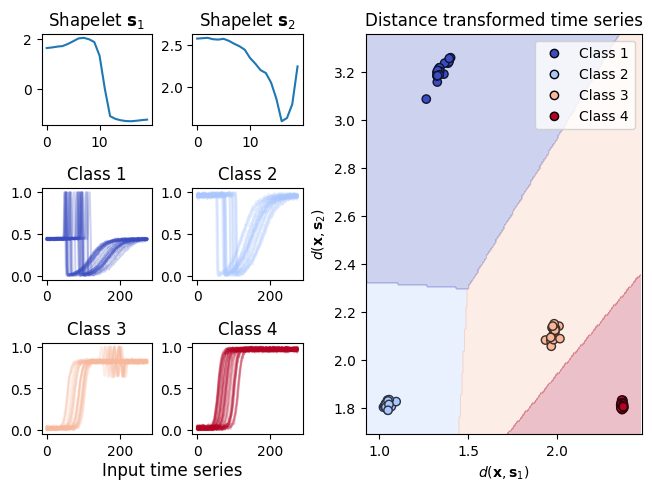

In [ ]:
import numpy
from matplotlib import cm
import matplotlib.pyplot as plt

from tslearn.datasets import CachedDatasets
from tslearn.preprocessing import TimeSeriesScalerMinMax
from tslearn.shapelets import LearningShapelets
from tensorflow.keras.optimizers import Adam

# Set a seed to ensure determinism
numpy.random.seed(42)

# Load the Trace dataset
X_train, y_train, _, _ = CachedDatasets().load_dataset("Trace")

# Normalize the time series
X_train = TimeSeriesScalerMinMax().fit_transform(X_train)

# Get statistics of the dataset
n_ts, ts_sz = X_train.shape[:2]
n_classes = len(set(y_train))

# We will extract 2 shapelets and align them with the time series
shapelet_sizes = {20: 2}

# Define the model and fit it using the training data
shp_clf = LearningShapelets(n_shapelets_per_size=shapelet_sizes,
                            weight_regularizer=0.0001,
                            optimizer=Adam(learning_rate=0.01),
                            max_iter=300,
                            verbose=0,
                            scale=False,
                            random_state=42)
shp_clf.fit(X_train, y_train)

# We will plot our distances in a 2D space
distances = shp_clf.transform(X_train).reshape((-1, 2))
weights, biases = shp_clf.get_weights('classification')

# Create a grid for our two shapelets on the left and distances on the right
viridis = cm.get_cmap('viridis', 4)
fig = plt.figure(constrained_layout=True)
gs = fig.add_gridspec(3, 9)
fig_ax1 = fig.add_subplot(gs[0, :2])
fig_ax2 = fig.add_subplot(gs[0, 2:4])
fig_ax3a = fig.add_subplot(gs[1, :2])
fig_ax3b = fig.add_subplot(gs[1, 2:4])
fig_ax3c = fig.add_subplot(gs[2, :2])
fig_ax3d = fig.add_subplot(gs[2, 2:4])
fig_ax4 = fig.add_subplot(gs[:, 4:])

# Plot our two shapelets on the left side
fig_ax1.plot(shp_clf.shapelets_[0])
fig_ax1.set_title('Shapelet $\mathbf{s}_1$')

fig_ax2.plot(shp_clf.shapelets_[1])
fig_ax2.set_title('Shapelet $\mathbf{s}_2$')

# Create the time series of each class
for i, subfig in enumerate([fig_ax3a, fig_ax3b, fig_ax3c, fig_ax3d]):
    for k, ts in enumerate(X_train[y_train == i + 1]):
        subfig.plot(ts.flatten(), c=viridis(i / 3), alpha=0.25)
        subfig.set_title('Class {}'.format(i + 1))
fig.text(x=.15, y=.02, s='Input time series', fontsize=12)

# Create a scatter plot of the 2D distances for the time series of each class.
for i, y in enumerate(numpy.unique(y_train)):
    fig_ax4.scatter(distances[y_train == y][:, 0],
                    distances[y_train == y][:, 1],
                    c=[viridis(i / 3)] * numpy.sum(y_train == y),
                    edgecolors='k',
                    label='Class {}'.format(y))

# Create a meshgrid of the decision boundaries
xmin = numpy.min(distances[:, 0]) - 0.1
xmax = numpy.max(distances[:, 0]) + 0.1
ymin = numpy.min(distances[:, 1]) - 0.1
ymax = numpy.max(distances[:, 1]) + 0.1
xx, yy = numpy.meshgrid(numpy.arange(xmin, xmax, (xmax - xmin)/200),
                        numpy.arange(ymin, ymax, (ymax - ymin)/200))
Z = []
for x, y in numpy.c_[xx.ravel(), yy.ravel()]:
    Z.append(numpy.argmax([biases[i] + weights[0][i]*x + weights[1][i]*y
                           for i in range(4)]))
Z = numpy.array(Z).reshape(xx.shape)
cs = fig_ax4.contourf(xx, yy, Z / 3, cmap=viridis, alpha=0.25)

fig_ax4.legend()
fig_ax4.set_xlabel('$d(\mathbf{x}, \mathbf{s}_1)$')
fig_ax4.set_ylabel('$d(\mathbf{x}, \mathbf{s}_2)$')
fig_ax4.set_xlim((xmin, xmax))
fig_ax4.set_ylim((ymin, ymax))
fig_ax4.set_title('Distance transformed time series')
plt.show()

In [ ]:
n_ts

100

IndexError: index 1 is out of bounds for axis 0 with size 1

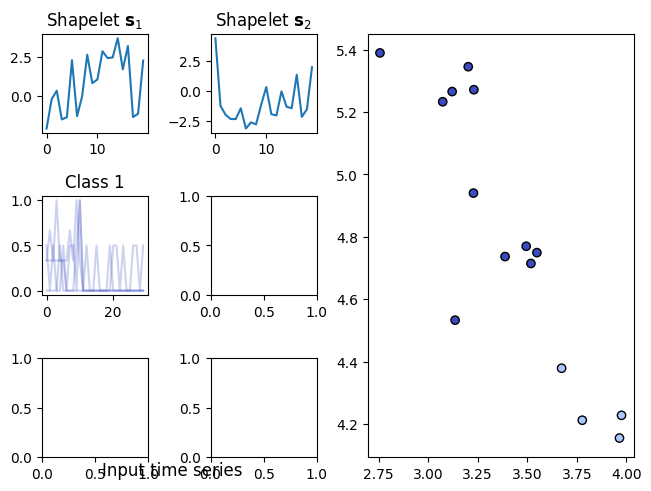

In [ ]:
import numpy
from matplotlib import cm
import matplotlib.pyplot as plt

from tslearn.datasets import CachedDatasets
from tslearn.preprocessing import TimeSeriesScalerMinMax
from tslearn.shapelets import LearningShapelets
from tensorflow.keras.optimizers import Adam

# Set a seed to ensure determinism
numpy.random.seed(42)

# Load the Trace dataset
X_train = reshaped_data_train
y_train = labels_train

# Normalize the time series
X_train = TimeSeriesScalerMinMax().fit_transform(X_train)

# Get statistics of the dataset
n_ts, ts_sz = X_train.shape[:2]
n_classes = len(set(y_train))

# We will extract 2 shapelets and align them with the time series
shapelet_sizes = {20: 2}

# Define the model and fit it using the training data
shp_clf = LearningShapelets(n_shapelets_per_size=shapelet_sizes,
                            weight_regularizer=0.0001,
                            optimizer=Adam(learning_rate=0.01),
                            max_iter=300,
                            verbose=0,
                            scale=False,
                            random_state=42)
shp_clf.fit(X_train, y_train)

# We will plot our distances in a 2D space
distances = shp_clf.transform(X_train).reshape((-1, 2))
weights, biases = shp_clf.get_weights('classification')

# Create a grid for our two shapelets on the left and distances on the right
viridis = cm.get_cmap('coolwarm', 4)
fig = plt.figure(constrained_layout=True)
gs = fig.add_gridspec(3, 9)
fig_ax1 = fig.add_subplot(gs[0, :2])
fig_ax2 = fig.add_subplot(gs[0, 2:4])
fig_ax3a = fig.add_subplot(gs[1, :2])
fig_ax3b = fig.add_subplot(gs[1, 2:4])
fig_ax3c = fig.add_subplot(gs[2, :2])
fig_ax3d = fig.add_subplot(gs[2, 2:4])
fig_ax4 = fig.add_subplot(gs[:, 4:])

# Plot our two shapelets on the left side
fig_ax1.plot(shp_clf.shapelets_[0])
fig_ax1.set_title('Shapelet $\mathbf{s}_1$')

fig_ax2.plot(shp_clf.shapelets_[1])
fig_ax2.set_title('Shapelet $\mathbf{s}_2$')

# Create the time series of each class
for i, subfig in enumerate([fig_ax3a, fig_ax3b, fig_ax3c, fig_ax3d]):
    for k, ts in enumerate(X_train[y_train == i + 1]):
        subfig.plot(ts.flatten(), c=viridis(i / 3), alpha=0.25)
        subfig.set_title('Class {}'.format(i + 1))
fig.text(x=.15, y=.02, s='Input time series', fontsize=12)

# Create a scatter plot of the 2D distances for the time series of each class.
for i, y in enumerate(numpy.unique(y_train)):
    fig_ax4.scatter(distances[y_train == y][:, 0],
                    distances[y_train == y][:, 1],
                    c=[viridis(i / 3)] * numpy.sum(y_train == y),
                    edgecolors='k',
                    label='Class {}'.format(y))

# Create a meshgrid of the decision boundaries
xmin = numpy.min(distances[:, 0]) - 0.1
xmax = numpy.max(distances[:, 0]) + 0.1
ymin = numpy.min(distances[:, 1]) - 0.1
ymax = numpy.max(distances[:, 1]) + 0.1
xx, yy = numpy.meshgrid(numpy.arange(xmin, xmax, (xmax - xmin)/200),
                        numpy.arange(ymin, ymax, (ymax - ymin)/200))
# Z = []
# for x, y in numpy.c_[xx.ravel(), yy.ravel()]:
#     Z.append(numpy.argmax([biases[i] + weights[0][i]*x + weights[1][i]*y
#                            for i in range(4)]))
# Z = numpy.array(Z).reshape(xx.shape)

Z = []
for x, y in numpy.c_[xx.ravel(), yy.ravel()]:
    Z.append(numpy.argmax([biases[i] + weights[i]*x + weights[i]*y
                           for i in range(4)]))
Z = numpy.array(Z).reshape(xx.shape)

cs = fig_ax4.contourf(xx, yy, Z / 3, cmap=viridis, alpha=0.25)

fig_ax4.legend()
fig_ax4.set_xlabel('$d(\mathbf{x}, \mathbf{s}_1)$')
fig_ax4.set_ylabel('$d(\mathbf{x}, \mathbf{s}_2)$')
fig_ax4.set_xlim((xmin, xmax))
fig_ax4.set_ylim((ymin, ymax))
fig_ax4.set_title('Distance transformed time series')
plt.show()

#### Kmeans

In [58]:
# Set a fixed random seed
np.random.seed(42)

sample_size = 200
sample_indices = np.random.choice(len(padded_sequences_test), size=sample_size, replace=False)
subset_X_test_reshaped = padded_sequences_test[sample_indices]

In [ ]:
# Summarize the background data using k-means
background_summary = shap.kmeans(subset_X_test_reshaped, 5)  # You can adjust the number of clusters (K) as needed

# Create an explainer using the Kernel SHAP method with the summarized background data
kernel_explainer = shap.KernelExplainer(model_GRU.predict, background_summary)

# Compute SHAP values for the test data
shap_values_test_kernel_GRU = kernel_explainer.shap_values(subset_X_test_reshaped)

1/1 [==============================] - 0s 336ms/step


  0%|          | 0/200 [00:00<?, ?it/s]

330/330 [==============================] - 1s 4ms/step


In [ ]:
np.save('/content/drive/My Drive/Thesis/Datasets/shap_values_test_kernel_GRU.npy', shap_values_test_kernel_GRU)

In [47]:
file_path = '/content/drive/My Drive/Thesis/Datasets/shap_values_test_kernel_GRU.npy'
shap_values_test_kernel_GRU = np.load(file_path)

In [48]:
# Define feature names based on the time steps in the sequence
# TS = Time Step
feature_names = [f"TS {i+1}" for i in range(subset_X_test_reshaped.shape[1])]

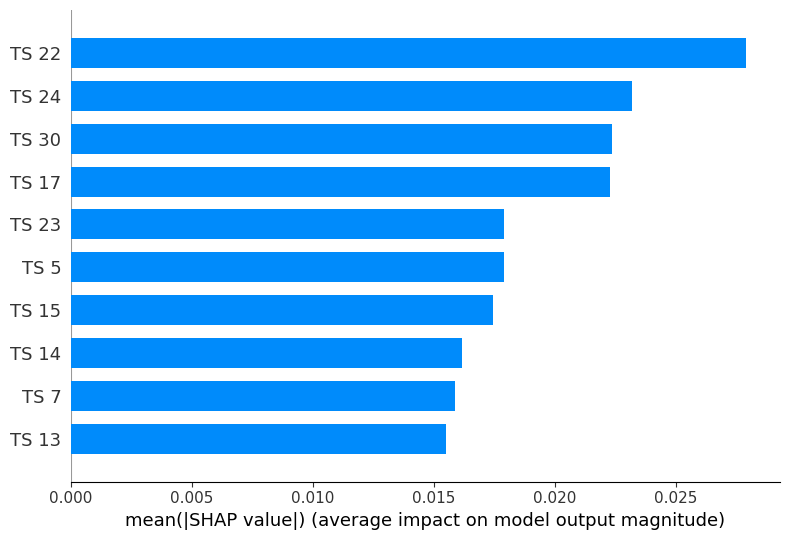

In [49]:
# Reshape the SHAP values matrix to match the shape of the features matrix
shap_values_test_kernel_GRU_reshaped = shap_values_test_kernel_GRU.reshape(shap_values_test_kernel_GRU.shape[0], shap_values_test_kernel_GRU.shape[1], -1)

# Aggregate SHAP values across all features
shap_values_aggregated = np.mean(shap_values_test_kernel_GRU, axis=2)

# Get the mean absolute SHAP values for each feature
mean_abs_shap_values = np.mean(np.abs(shap_values_aggregated), axis=0)

# Sort the features based on their mean absolute SHAP values
sorted_indices = np.argsort(mean_abs_shap_values)[::-1]

# Select only the top ten features
top_ten_indices_GRU = sorted_indices[:10]
top_ten_features = subset_X_test_reshaped[:, top_ten_indices_GRU]
top_ten_feature_names = [feature_names[i] for i in top_ten_indices_GRU]

# Plot the aggregated SHAP values for the top ten features
shap.summary_plot(shap_values_aggregated[:, top_ten_indices_GRU], features=top_ten_features, feature_names=top_ten_feature_names , plot_type='bar')


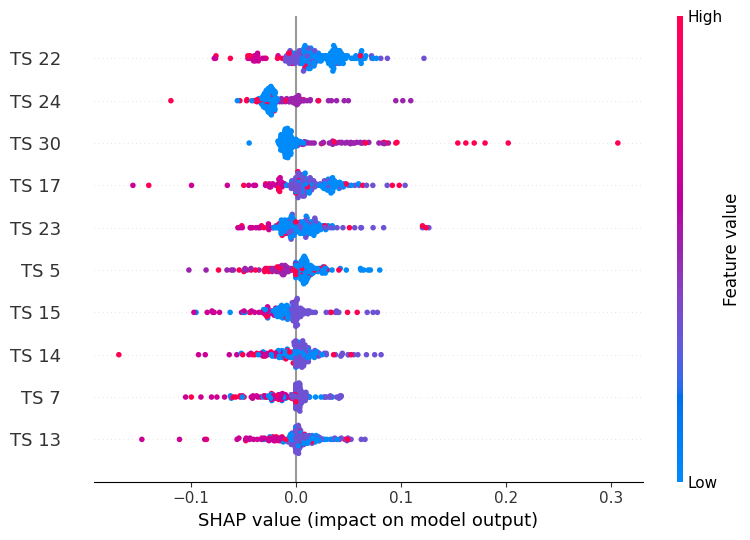

In [ ]:
plt.figure()
shap.summary_plot(shap_values_aggregated[:, top_ten_indices_GRU], features=top_ten_features, feature_names=top_ten_feature_names)
# plt.savefig('shap_summary_plot_GRU.pdf', bbox_inches='tight')
plt.close()

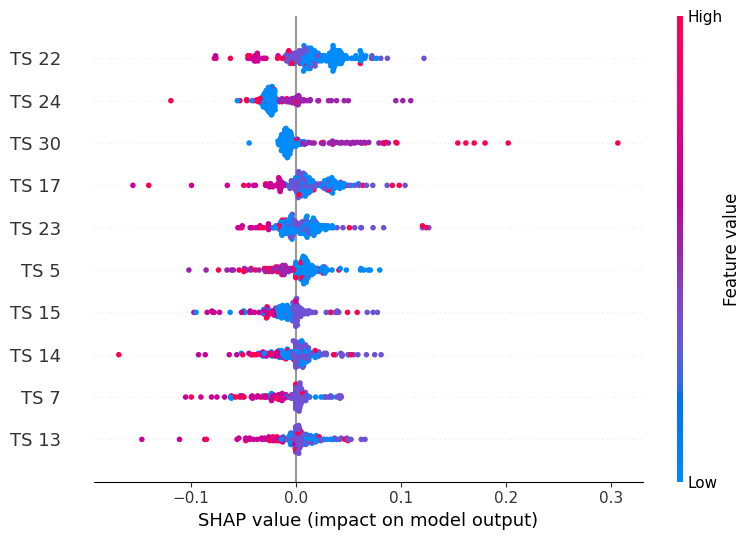

In [ ]:
plt.figure(figsize=(8, 6))

# Generate the SHAP summary plot
shap.summary_plot(shap_values_aggregated[:, top_ten_indices_GRU],
                  features=top_ten_features,
                  feature_names=top_ten_feature_names,
                  show=False)  # Add 'show=False' to prevent automatic display if running in an interactive environment

# Save the plot to a PDF file
plt.savefig('shap_summary_plot_GRU.pdf', bbox_inches='tight')

# Optional: Display the plot in the script or notebook
plt.show()

# Close the plot to free up memory
plt.close()

In [ ]:
# Summarize the background data using k-means
background_summary = shap.kmeans(subset_X_test_reshaped, 5)  # You can adjust the number of clusters (K) as needed

# Create an explainer using the Kernel SHAP method with the summarized background data
kernel_explainer = shap.KernelExplainer(model_GRU.predict, background_summary)

1/1 [==============================] - 0s 19ms/step


In [ ]:
subset_X_test_reshaped[2]

array([1, 1, 1, 1, 1, 1, 1, 1, 2, 3, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 4, 1,
       1, 1, 0, 0, 0, 0, 0, 0], dtype=int32)

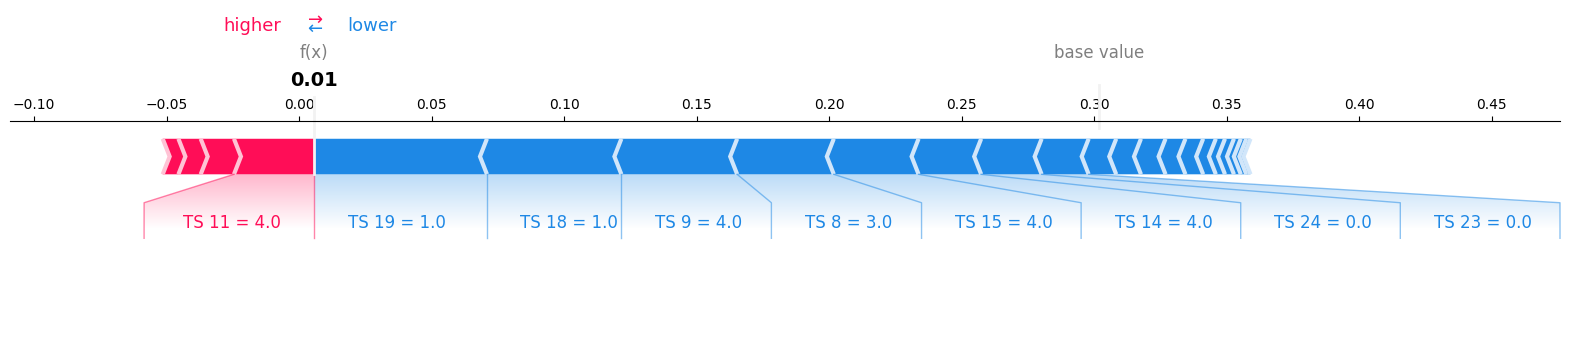

<Figure size 640x480 with 0 Axes>

In [ ]:
# Choose an instance to explain (e.g., the first instance)
instance_index = 10

# Generate force plot for the chosen instance
shap.force_plot(kernel_explainer.expected_value, shap_values_test_kernel_GRU[instance_index][:, 0], subset_X_test_reshaped[instance_index], matplotlib=True, feature_names= feature_names)

1247/1247 [==============================] - 4s 3ms/step


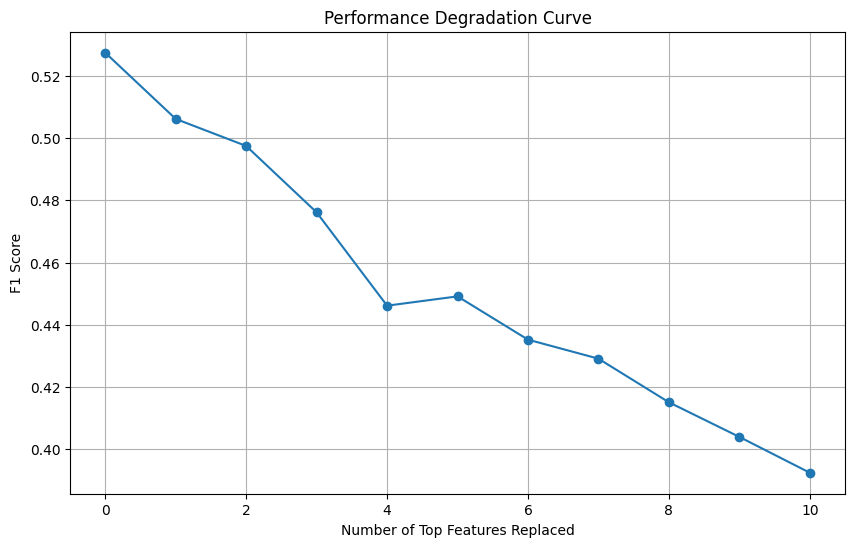

In [ ]:
# Create a copy of the test data to modify
modified_test_set = np.array(padded_sequences_test)

# Store original F1 score with unmodified data
original_pred = model_GRU.predict(padded_sequences_test)
original_f1 = f1_score(y_test, (original_pred > 0.27).astype(int))

# Initialize a list to store F1 scores after each feature modification
f1_scores_GRU = [original_f1]

# Replace each top feature with the majority value found in that feature
for i, feature_idx in enumerate(top_ten_indices_GRU):
    # Find the majority class for the current feature across all test data
    majority_value = np.bincount(modified_test_set[:, feature_idx]).argmax()

    # Replace this feature in all test samples with the majority class
    modified_test_set[:, feature_idx] = majority_value

    # Evaluate the model with the modified test set
    new_predictions = model_GRU.predict(modified_test_set)
    new_f1 = f1_score(y_test, (new_predictions > 0.27).astype(int))

    # Append the new F1 score
    f1_scores_GRU.append(new_f1)

# Plot the performance degradation curve
plt.figure(figsize=(10, 6))
plt.plot(range(len(f1_scores_GRU)), f1_scores_GRU, marker='o')
plt.title('Performance Degradation Curve')
plt.xlabel('Number of Top Features Replaced')
plt.ylabel('F1 Score')
plt.grid(True)
plt.show()

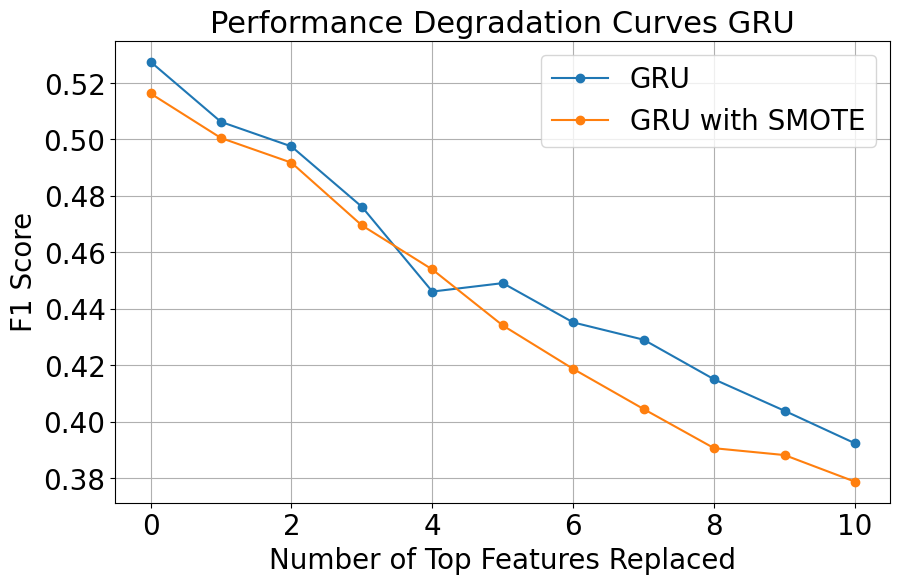

In [ ]:
# Create the plot
plt.figure(figsize=(10, 6))
plt.plot(range(len(f1_scores_GRU)), f1_scores_GRU, marker='o', label='GRU')
plt.plot(range(len(f1_scores_GRU_SMOTE)), f1_scores_GRU_SMOTE, marker='o', label='GRU with SMOTE')

# Adding title and labels with increased font size
plt.title('Performance Degradation Curves GRU', fontsize=22)  # Increase font size for the title
plt.xlabel('Number of Top Features Replaced', fontsize=20)  # Increase font size for x-axis label
plt.ylabel('F1 Score', fontsize=20)  # Increase font size for y-axis label

# Increase font size for tick labels on both axes
plt.xticks(fontsize=20)  # Increase font size for x-axis tick labels
plt.yticks(fontsize=20)  # Increase font size for y-axis tick labels

plt.grid(True)

# Increase font size for the legend
plt.legend(fontsize=20)

# Save the plot to a PDF file
# plt.savefig('Performance Degradation Curves GRU.pdf')
# Show the plot
plt.show()

#### Both classes

In [ ]:
# Filter the dataset for "cart abandonment" sessions (target = 0)
cart_abandonment_sessions = df_train[df_train["conversion"] == 0][["session_id_hash", "session"]]
sequences_train_ca = cart_abandonment_sessions['session'].tolist()
sequences_train_ca = [[int(num) for num in item.strip("[]").split(', ')] for item in sequences_train_ca]
max_length = 30  # Choose the maximum length you want
padded_sequences_ca = pad_sequences(sequences_train_ca, maxlen= max_length, padding='post', truncating='post')

# Filter the dataset for "purchase" sessions (target = 1)
purchase_sessions = df_train[df_train["conversion"] == 1][["session_id_hash", "session"]]
sequences_train_pu = purchase_sessions['session'].tolist()
sequences_train_pu = [[int(num) for num in item.strip("[]").split(', ')] for item in sequences_train_pu]
max_length = 30  # Choose the maximum length you want
padded_sequences_pu = pad_sequences(sequences_train_pu, maxlen= max_length, padding='post', truncating='post')

In [ ]:
# Set a fixed random seed
np.random.seed(42)

sample_size = 100
sample_indices = np.random.choice(len(padded_sequences_ca), size=sample_size, replace=False)
subset_X_test_reshaped_ca = padded_sequences_ca[sample_indices]

sample_indices = np.random.choice(len(padded_sequences_pu), size=sample_size, replace=False)
subset_X_test_reshaped_pu = padded_sequences_pu[sample_indices]

In [ ]:
# Summarize the background data using k-means
background_summary = shap.kmeans(subset_X_test_reshaped_ca, 5)  # You can adjust the number of clusters (K) as needed

# Create an explainer using the Kernel SHAP method with the summarized background data
kernel_explainer = shap.KernelExplainer(model_GRU.predict, background_summary)

# Compute SHAP values for the test data
shap_values_class0 = kernel_explainer.shap_values(subset_X_test_reshaped_ca)

1/1 [==============================] - 0s 296ms/step


  0%|          | 0/100 [00:00<?, ?it/s]

330/330 [==============================] - 1s 2ms/step


In [ ]:
# Summarize the background data using k-means
background_summary = shap.kmeans(subset_X_test_reshaped_pu, 5)  # You can adjust the number of clusters (K) as needed

# Create an explainer using the Kernel SHAP method with the summarized background data
kernel_explainer = shap.KernelExplainer(model_GRU.predict, background_summary)

# Compute SHAP values for the test data
shap_values_class1 = kernel_explainer.shap_values(subset_X_test_reshaped_pu)

1/1 [==============================] - 0s 18ms/step


  0%|          | 0/100 [00:00<?, ?it/s]

329/329 [==============================] - 1s 2ms/step


In [ ]:
# Define feature names based on the time steps in the sequence
# TS = Time Step
feature_names = [f"TS {i+1}" for i in range(subset_X_test_reshaped_ca.shape[1])]

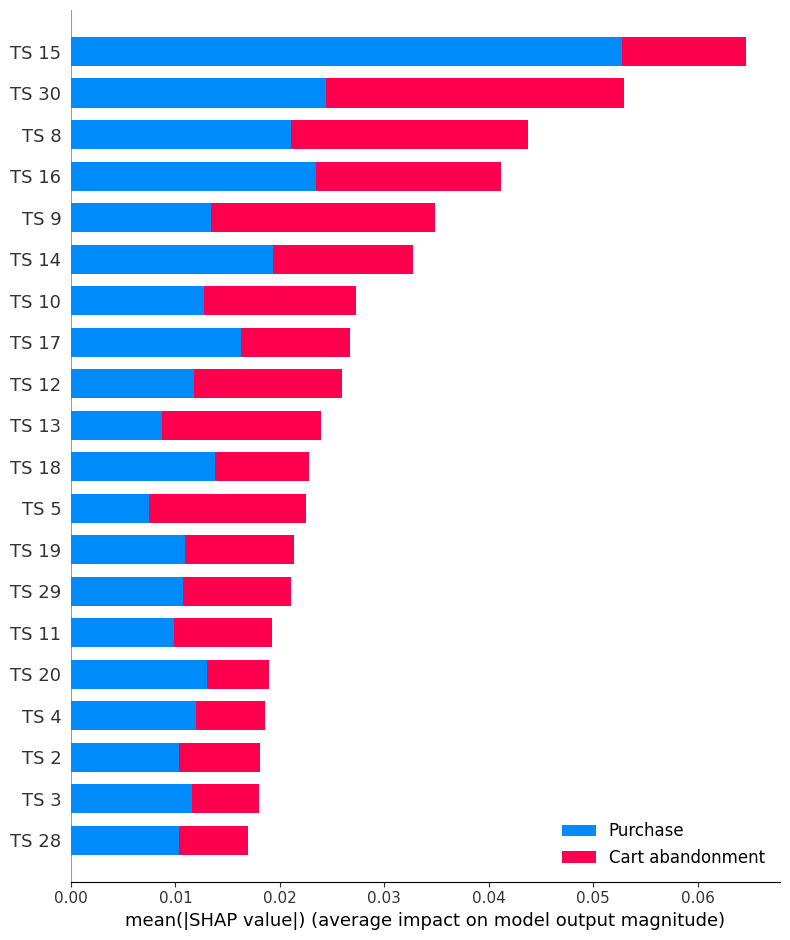

In [ ]:
# Reshape the SHAP values matrix to match the shape of the features matrix for each class
shap_values_class0_reshaped = shap_values_class0.reshape(shap_values_class0.shape[0], shap_values_class0.shape[1], -1)
shap_values_class1_reshaped = shap_values_class1.reshape(shap_values_class1.shape[0], shap_values_class1.shape[1], -1)

# Aggregate SHAP values across all features for each class
shap_values_class0_aggregated = np.mean(shap_values_class0, axis=2)
shap_values_class1_aggregated = np.mean(shap_values_class1, axis=2)

# Create a matplotlib figure and axis
fig, ax = plt.subplots()

# Plot the aggregated SHAP values for the top ten features for both classes in one summary plot
shap.summary_plot([shap_values_class0_aggregated, shap_values_class1_aggregated],
                  feature_names=feature_names,
                  plot_type='bar',
                  class_names=['Cart abandonment', 'Purchase'],
                  show=False)  # Prevents immediate showing of the plot

# Save the figure as a PDF
plt.savefig('shap_summary_plot_GRU.pdf', bbox_inches='tight')  # Save as PDF

# If you want to display the plot as well, uncomment the next line
# plt.show()

### Error Analysis

In [ ]:
y_pred_GRU = model_GRU.predict(padded_sequences_test)

1247/1247 [==============================] - 4s 3ms/step


In [ ]:
y_pred_GRU_ovs = model_GRU_ovs.predict(padded_sequences_test)

1247/1247 [==============================] - 6s 5ms/step


In [ ]:
y_pred_GRU_uns = model_GRU_uns.predict(padded_sequences_test)

1247/1247 [==============================] - 4s 3ms/step


Brier Score GRU: 0.14244600728065046
Brier Score GRU_SMOTE: 0.1903296768253343
Brier Score GRU_ENN: 0.24021723150497598


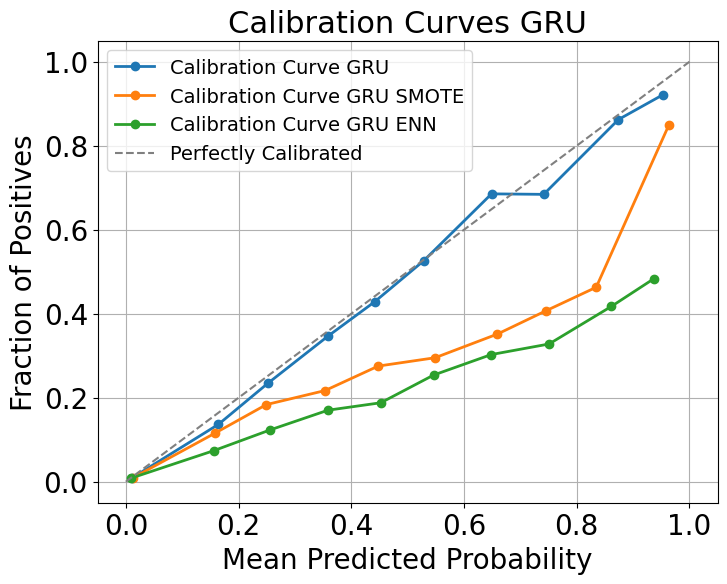

In [ ]:
prob_true_GRU, prob_pred_GRU = calibration_curve(y_test, y_pred_GRU, n_bins=10, strategy='uniform')
prob_true_GRU_ovs, prob_pred_GRU_ovs = calibration_curve(y_test, y_pred_GRU_ovs, n_bins=10, strategy='uniform')
prob_true_GRU_uns, prob_pred_GRU_uns = calibration_curve(y_test, y_pred_GRU_uns, n_bins=10, strategy='uniform')

# Compute Brier score
brier_score = brier_score_loss(y_test, y_pred_GRU)
print("Brier Score GRU:", brier_score)
brier_score = brier_score_loss(y_test, y_pred_GRU_ovs)
print("Brier Score GRU_SMOTE:", brier_score)
brier_score = brier_score_loss(y_test, y_pred_GRU_uns)
print("Brier Score GRU_ENN:", brier_score)

# Plot calibration curve
plt.figure(figsize=(8, 6))
plt.plot(prob_pred_GRU, prob_true_GRU, marker='o', linewidth=2, label='Calibration Curve GRU')
plt.plot(prob_pred_GRU_ovs, prob_true_GRU_ovs, marker='o', linewidth=2, label='Calibration Curve GRU SMOTE')
plt.plot(prob_pred_GRU_uns, prob_true_GRU_uns, marker='o', linewidth=2, label='Calibration Curve GRU ENN')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Perfectly Calibrated')

# Increase font sizes
plt.xlabel('Mean Predicted Probability', fontsize=20)
plt.ylabel('Fraction of Positives', fontsize=20)
plt.title('Calibration Curves GRU', fontsize=22)
plt.xticks(fontsize=20)  # Increase tick size
plt.yticks(fontsize=20)
plt.legend(fontsize=14)
plt.grid(True)

# Optionally save the figure in a high-quality format
plt.savefig('Calibration Curve GRU.pdf', format='pdf')

plt.show()

              precision    recall  f1-score   support

         0.0       0.91      0.66      0.76     30729
         1.0       0.40      0.77      0.53      9145

    accuracy                           0.68     39874
   macro avg       0.65      0.71      0.65     39874
weighted avg       0.79      0.68      0.71     39874



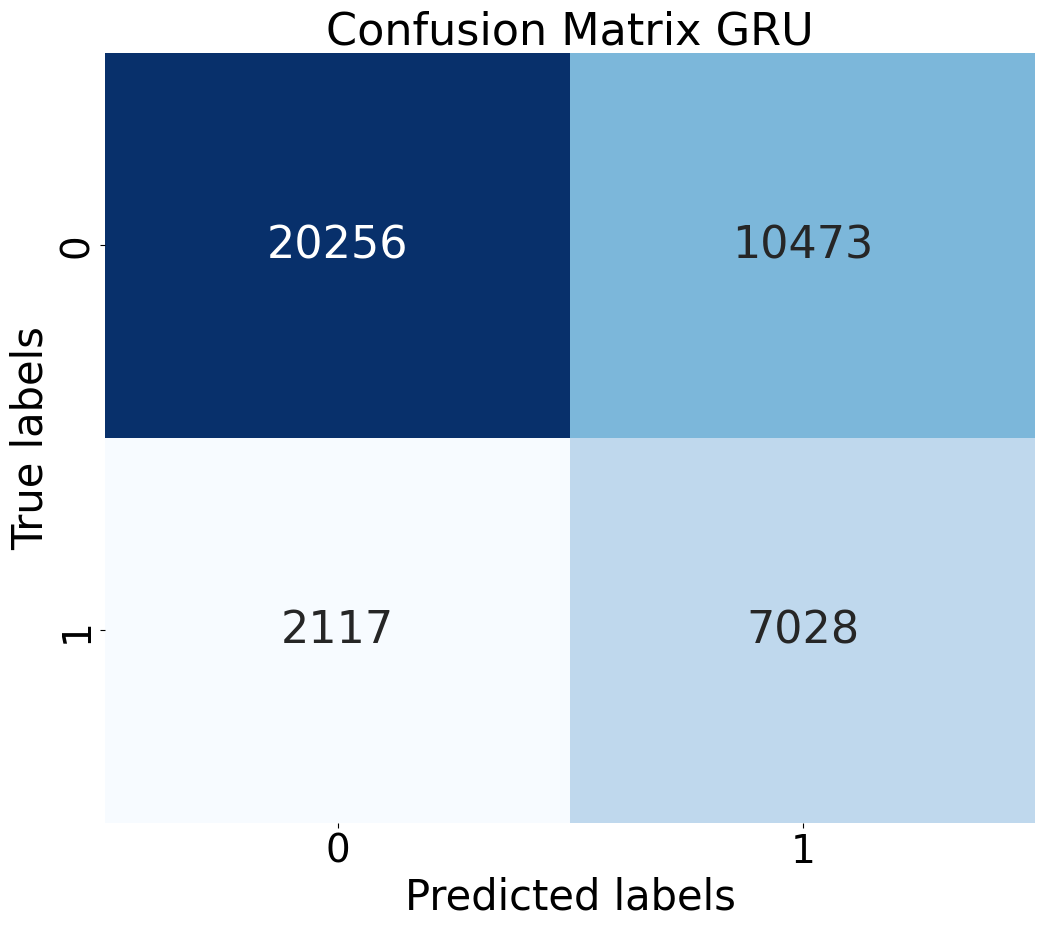

In [ ]:
# Compute confusion matrix and classification report
conf_matrix = confusion_matrix(y_test, y_pred_binary_GRU)
cr_error = classification_report(y_test, y_pred_binary_GRU)
print(cr_error)

# Plot confusion matrix
plt.figure(figsize=(12, 10))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False, annot_kws={"size": 32})
plt.xlabel('Predicted labels', fontsize=30)
plt.ylabel('True labels', fontsize=30)
plt.title('Confusion Matrix GRU', fontsize=32)
plt.xticks(fontsize=28)
plt.yticks(fontsize=28)
plt.savefig('Confusion_Matrix_GRU.pdf', format='pdf')
plt.show()

In [ ]:
# Predict labels for the test set
y_pred_LSTM = model_LSTM.predict(padded_sequences_test)
y_pred_GRU = model_GRU.predict(padded_sequences_test)

1247/1247 [==============================] - 4s 3ms/step


In [ ]:
def predict_df(df):
    predictions = []
    for index, row in df.iterrows():
        sequence = row['session']
        purchase_probability = markov_model.predict_purchase_probability(sequence)
        predictions.append(purchase_probability)
    return predictions

data = {'session': X_test["session"], 'conversion': y_test}
X_test = pd.DataFrame(data)

# Make predictions on the dataframe
y_pred_markov = predict_df(X_test)

In [ ]:
y_pred_oracle = np.array([get_oracle_conversion(x) for x in padded_sequences_test])

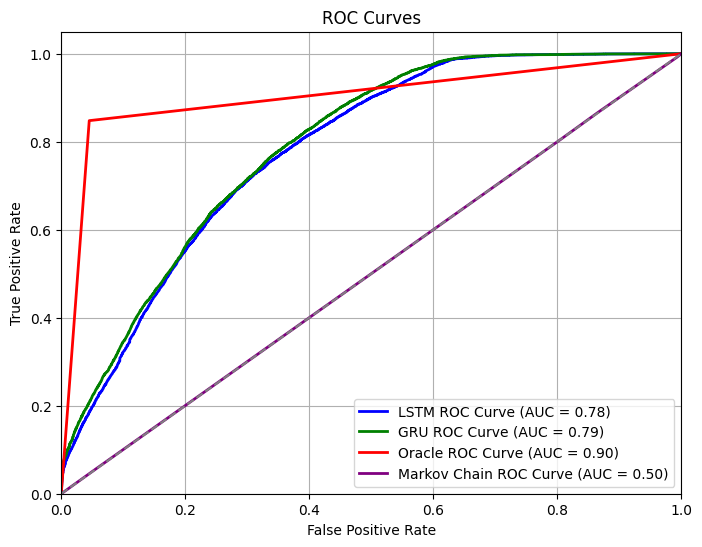

In [ ]:
# Compute ROC curve for LSTM
fpr_lstm, tpr_lstm, thresholds_lstm = roc_curve(y_test, y_pred_LSTM)
roc_auc_lstm = auc(fpr_lstm, tpr_lstm)

# Compute ROC curve for GRU
fpr_gru, tpr_gru, thresholds_gru = roc_curve(y_test, y_pred_GRU)
roc_auc_gru = auc(fpr_gru, tpr_gru)

# Compute ROC curve for Oracle
fpr_oracle, tpr_oracle, thresholds_oracle = roc_curve(y_test, y_pred_oracle)
roc_auc_oracle = auc(fpr_oracle, tpr_oracle)

# Compute ROC curve for Markov Chain
fpr_markov, tpr_markov, thresholds_markov = roc_curve(y_test, y_pred_markov)  # Adjusted true_labels to y_test
roc_auc_markov = auc(fpr_markov, tpr_markov)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr_lstm, tpr_lstm, color='blue', lw=2, label=f'LSTM ROC Curve (AUC = {roc_auc_lstm:.2f})')
plt.plot(fpr_gru, tpr_gru, color='green', lw=2, label=f'GRU ROC Curve (AUC = {roc_auc_gru:.2f})')
plt.plot(fpr_oracle, tpr_oracle, color='red', lw=2, label=f'Oracle ROC Curve (AUC = {roc_auc_oracle:.2f})')
plt.plot(fpr_markov, tpr_markov, color='purple', lw=2, label=f'Markov Chain ROC Curve (AUC = {roc_auc_markov:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves')
plt.legend(loc="lower right")
plt.grid(True)
# plt.savefig('ROC_Curves.pdf', format='pdf')
plt.show()

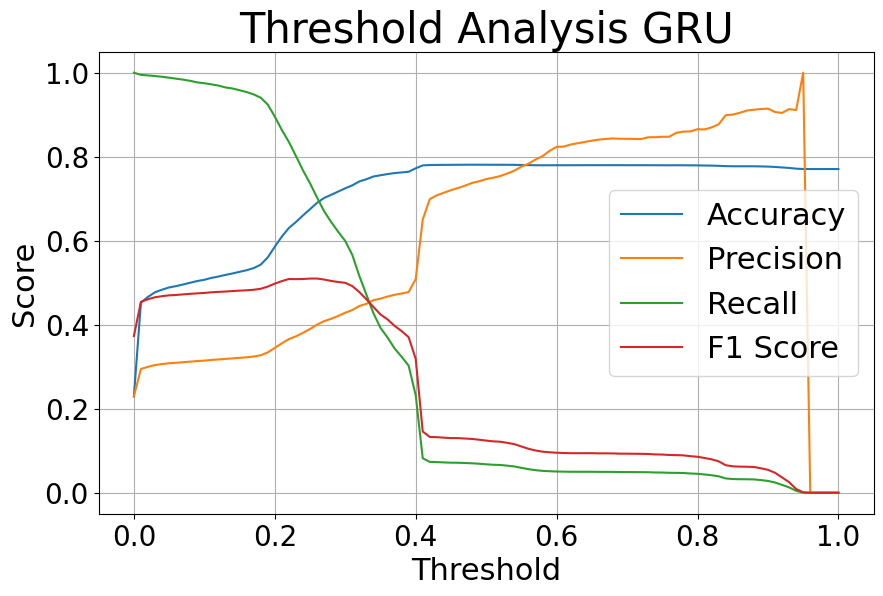

In [ ]:
thresholds = np.linspace(0, 1, 101)  # 100 thresholds from 0 to 1

# Initialize lists to store evaluation metrics
accuracy_scores = []
precision_scores = []
recall_scores = []
f1_scores = []

# Iterate over each threshold
for threshold in thresholds:
    # Convert probabilities to binary predictions based on the threshold
    y_pred_binary = np.where(y_pred > threshold, 1, 0)

    # Evaluate the model using the current threshold
    accuracy = accuracy_score(y_test, y_pred_binary)
    precision = precision_score(y_test, y_pred_binary)
    recall = recall_score(y_test, y_pred_binary)
    f1 = f1_score(y_test, y_pred_binary)

    # Append evaluation metrics to lists
    accuracy_scores.append(accuracy)
    precision_scores.append(precision)
    recall_scores.append(recall)
    f1_scores.append(f1)

plt.figure(figsize=(10, 6))

plt.plot(thresholds, accuracy_scores, label='Accuracy')
plt.plot(thresholds, precision_scores, label='Precision')
plt.plot(thresholds, recall_scores, label='Recall')
plt.plot(thresholds, f1_scores, label='F1 Score')

plt.xlabel('Threshold', fontsize=22)
plt.ylabel('Score', fontsize=22)
plt.title('Threshold Analysis GRU', fontsize=30)
plt.legend(fontsize=22)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.grid(True)

plt.savefig('Threshold_Analysis_GRU.pdf', format='pdf')
plt.show()

Mean Probability: 0.24151507019996643
Standard Deviation: 0.1879403442144394


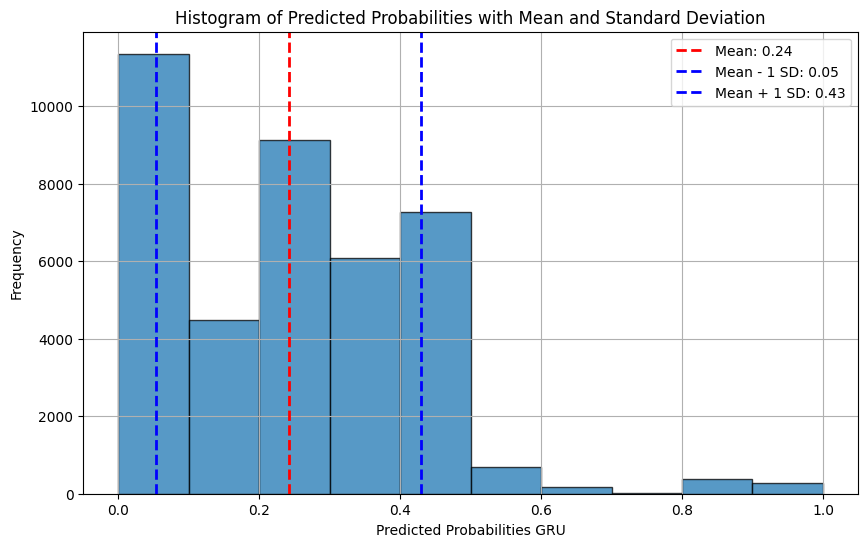

In [ ]:
# Calculate mean and standard deviation
mean_prob = np.mean(y_pred)
std_prob = np.std(y_pred)

print(f"Mean Probability: {mean_prob}")
print(f"Standard Deviation: {std_prob}")

# Plotting the probabilities with mean and standard deviation
plt.figure(figsize=(10, 6))
plt.hist(y_pred, bins=10, alpha=0.75, edgecolor='black')
plt.axvline(mean_prob, color='red', linestyle='dashed', linewidth=2, label=f'Mean: {mean_prob:.2f}')
plt.axvline(mean_prob - std_prob, color='blue', linestyle='dashed', linewidth=2, label=f'Mean - 1 SD: {mean_prob - std_prob:.2f}')
plt.axvline(mean_prob + std_prob, color='blue', linestyle='dashed', linewidth=2, label=f'Mean + 1 SD: {mean_prob + std_prob:.2f}')
plt.xlabel('Predicted Probabilities GRU')
plt.ylabel('Frequency')
plt.title('Histogram of Predicted Probabilities with Mean and Standard Deviation')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
X_test.head()

session_id_hash  \
139173  b2410d2c9a0f5c3e5674b7ecfb5072e9d8cfeed51a8527...   
25840   2101ff15b51412a2ca58b7e266f02670345310c259a115...   
25719   20db6a581ee197ecb7b819083d1e07713c59134301d66b...   
193479  f8666eda87b62d9ab550c7e9445ead5274b6acadebdfe2...   
50714   413508364819d4afd5d4d0246af8fb826f0ac8116b3817...   

                                                  session  
139173  [1, 1, 1, 1, 1, 1, 2, 1, 1, 2, 1, 2, 1, 2, 3, ...  
25840   [1, 2, 1, 2, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 2, ...  
25719   [1, 1, 1, 1, 1, 2, 3, 1, 2, 1, 3, 1, 1, 1, 1, ...  
193479  [1, 2, 1, 1, 2, 1, 3, 1, 1, 1, 1, 1, 2, 1, 1, ...  
50714                         [1, 1, 2, 3, 1, 1, 1, 1, 1]

In [ ]:
df_train_exp_error = X_test

In [ ]:
print(len(df_train_exp_error["session"][4]))

48


In [ ]:
df_train_exp_error['session_length'] = df_train_exp_error['session'].apply(lambda x: len(x)/3)
df_train_exp_error['true'] = y_test
df_train_exp_error['exp_pred'] = y_pred_binary

# Display the updated DataFrame
df_train_exp_error.head()

session_id_hash  \
139173  b2410d2c9a0f5c3e5674b7ecfb5072e9d8cfeed51a8527...   
25840   2101ff15b51412a2ca58b7e266f02670345310c259a115...   
25719   20db6a581ee197ecb7b819083d1e07713c59134301d66b...   
193479  f8666eda87b62d9ab550c7e9445ead5274b6acadebdfe2...   
50714   413508364819d4afd5d4d0246af8fb826f0ac8116b3817...   

                                                  session  session_length  \
139173  [1, 1, 1, 1, 1, 1, 2, 1, 1, 2, 1, 2, 1, 2, 3, ...            37.0   
25840   [1, 2, 1, 2, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 2, ...            21.0   
25719   [1, 1, 1, 1, 1, 2, 3, 1, 2, 1, 3, 1, 1, 1, 1, ...            20.0   
193479  [1, 2, 1, 1, 2, 1, 3, 1, 1, 1, 1, 1, 2, 1, 1, ...            27.0   
50714                         [1, 1, 2, 3, 1, 1, 1, 1, 1]             9.0   

        true  exp_pred  
139173   0.0         1  
25840    0.0         0  
25719    0.0         1  
193479   0.0         1  
50714    1.0         1

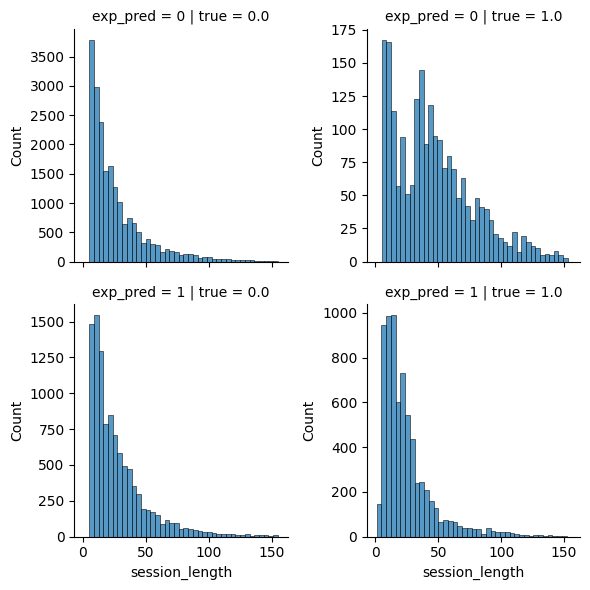

In [ ]:
g = sns.FacetGrid(df_train_exp_error, col = 'true', row = 'exp_pred', sharey=False)
g.map(sns.histplot, 'session_length', bins = 40)

In [ ]:
# model_GRU.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
history = model_GRU.fit(X_train_reshaped, y_train, epochs=10, batch_size=128, validation_data=(X_val_reshaped, y_val))

Epoch 1/10
935/935 [==============================] - 9s 9ms/step - loss: 0.4211 - accuracy: 0.7872 - val_loss: 0.4255 - val_accuracy: 0.7880
Epoch 2/10
935/935 [==============================] - 8s 8ms/step - loss: 0.4214 - accuracy: 0.7877 - val_loss: 0.4245 - val_accuracy: 0.7858
Epoch 3/10
935/935 [==============================] - 6s 6ms/step - loss: 0.4267 - accuracy: 0.7858 - val_loss: 0.4296 - val_accuracy: 0.7850
Epoch 4/10
935/935 [==============================] - 5s 6ms/step - loss: 0.4232 - accuracy: 0.7866 - val_loss: 0.4252 - val_accuracy: 0.7876
Epoch 5/10
935/935 [==============================] - 10s 11ms/step - loss: 0.4207 - accuracy: 0.7879 - val_loss: 0.4245 - val_accuracy: 0.7824
Epoch 6/10
935/935 [==============================] - 8s 9ms/step - loss: 0.4253 - accuracy: 0.7863 - val_loss: 0.4299 - val_accuracy: 0.7856
Epoch 7/10
935/935 [==============================] - 9s 10ms/step - loss: 0.4356 - accuracy: 0.7837 - val_loss: 0.4403 - val_accuracy: 0.7818
Epo

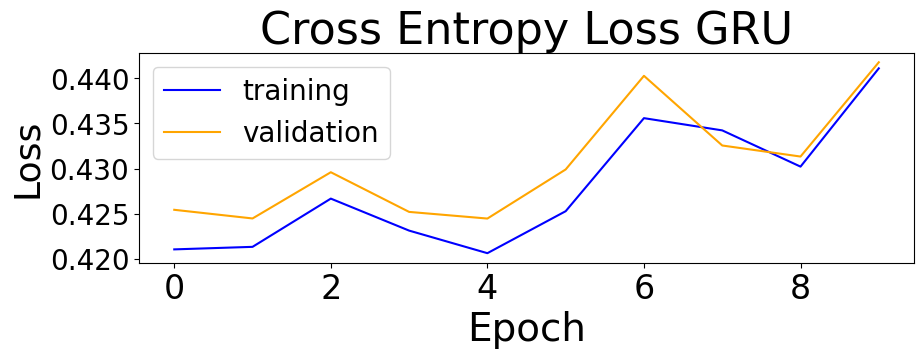

In [ ]:
# Plot Cross Entropy Loss for GRU
plt.figure(figsize=(10, 6))
plt.subplot(211)
plt.title('Cross Entropy Loss GRU', fontsize=32)
plt.plot(history.history['loss'], color='blue', label='train')
plt.plot(history.history['val_loss'], color='orange', label='test')
plt.legend(['training', 'validation'], fontsize=20)
plt.xlabel('Epoch', fontsize=28)
plt.ylabel('Loss', fontsize=26)
plt.xticks(fontsize=24)
plt.yticks(fontsize=20)
plt.savefig('Cross_Entropy_Loss_GRU.pdf', format='pdf')
plt.show()

## LSTM

In [ ]:
X_train.head()

session_id_hash  \
317     006663e8030ec06f59b5f7b9401fc5a85fedfba541296a...   
150615  c0ea26f06f885f2e647ff6c945f64621596170c285f857...   
191502  f5d3c2a190d0fe44b3f5cb6b093dd8e1092ac9d7f29fe4...   
181330  e8b5f2ba42ff1168c314d7220983403053457ddf968c7b...   
147450  bce118d59635f73d6afa0816e5fa154d7a4ce65f651a42...   

                                                  session  
317     [1, 1, 2, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, ...  
150615  [1, 2, 2, 1, 1, 2, 1, 2, 1, 2, 1, 2, 3, 1, 2, ...  
191502  [1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 2, 1, 1, 1, ...  
181330  [1, 2, 3, 4, 1, 4, 1, 4, 4, 1, 4, 4, 4, 4, 4, ...  
147450  [1, 1, 1, 1, 2, 1, 1, 1, 1, 2, 3, 1, 2, 1, 1, ...

In [ ]:
sequences_train = X_train['session'].tolist()
sequences_test = X_test['session'].tolist()
sequences_train = [[int(num) for num in item.strip("[]").split(', ')] for item in sequences_train]
sequences_test = [[int(num) for num in item.strip("[]").split(', ')] for item in sequences_test]

# Pad sequences to a fixed length
max_length = 30  # Choose the maximum length you want
padded_sequences_train = pad_sequences(sequences_train, maxlen= max_length, padding='post', truncating='post')
padded_sequences_test = pad_sequences(sequences_test, maxlen= max_length, padding='post', truncating='post')

# Convert padded sequences to NumPy array
sequences_train = np.array(padded_sequences_train)
labels_train = np.array(y_train)
sequences_test = np.array(padded_sequences_test)
labels_test = np.array(y_test)

# Split the data into train, validation, and test sets
X_train, X_val, y_train, y_val = train_test_split(sequences_train, labels_train, test_size=0.25, random_state=42)  # 0.25 x 0.8 = 0.2

# Reshape the input data to match the expected input shape of the GRU layer
X_train_reshaped = np.expand_dims(X_train, axis=-1)
X_val_reshaped = np.expand_dims(X_val, axis=-1)


In [ ]:
# Define the GRU model with increased complexity and additional techniques
model_LSTM = Sequential([
    LSTM(32, input_shape=(None, 1)),
    Dropout(0),
    Dense(32, activation='relu'),
    Dense(1, activation='sigmoid')
])


# Compile the model with Adam optimizer and a lower learning rate
optimizer = Adam(learning_rate=0.001)
model_LSTM.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

# Reshape the input data to match the expected input shape of the GRU layer
X_train_reshaped = np.expand_dims(X_train, axis=-1)
X_val_reshaped = np.expand_dims(X_val, axis=-1)

# Train the model
history = model_LSTM.fit(X_train_reshaped, y_train, epochs=10, batch_size=64, validation_data=(X_val_reshaped, y_val))

Epoch 1/10
1870/1870 [==============================] - 17s 7ms/step - loss: 0.5306 - accuracy: 0.7745 - val_loss: 0.5217 - val_accuracy: 0.7791
Epoch 2/10
1870/1870 [==============================] - 13s 7ms/step - loss: 0.5002 - accuracy: 0.7794 - val_loss: 0.4800 - val_accuracy: 0.7788
Epoch 3/10
1870/1870 [==============================] - 12s 7ms/step - loss: 0.4668 - accuracy: 0.7802 - val_loss: 0.4565 - val_accuracy: 0.7809
Epoch 4/10
1870/1870 [==============================] - 13s 7ms/step - loss: 0.4507 - accuracy: 0.7805 - val_loss: 0.4588 - val_accuracy: 0.7803
Epoch 5/10
1870/1870 [==============================] - 12s 7ms/step - loss: 0.4436 - accuracy: 0.7813 - val_loss: 0.4398 - val_accuracy: 0.7822
Epoch 6/10
1870/1870 [==============================] - 14s 7ms/step - loss: 0.4390 - accuracy: 0.7817 - val_loss: 0.4367 - val_accuracy: 0.7816
Epoch 7/10
1870/1870 [==============================] - 13s 7ms/step - loss: 0.4362 - accuracy: 0.7824 - val_loss: 0.4418 - val_ac

In [ ]:
model_save_name = 'model_LSTM.h5'
path = "/content/drive/MyDrive/Thesis/Models/" + model_save_name
model_LSTM.save(path)

In [65]:
# Load the model from the saved HDF5 file
model_save_name = 'model_LSTM.h5'
path = "/content/drive/MyDrive/Thesis/Models/" + model_save_name
model_LSTM = load_model(path)

In [ ]:
# 1	batch size: 64;	Dropout: 0.00;	Learning Rate: 0.001 --> 0.52310 (Threshold = 0.27)


# 2	batch size: 32;	Dropout: 0.00;	Learning Rate: 0.001 --> 0.51586 (Threshold = 0.28)
# 3	batch size: 32;	Dropout: 0.00;	Learning Rate: 0.010 --> 0.52159 (Threshold = 0.26)
# 4	batch size: 128;	Dropout: 0.00;	Learning Rate: 0.001 --> 0.51303 (Threshold = 0.27)
# 5	batch size: 128; 	Dropout:0.00; 	Learning Rate: 0.010 -->  0.52215 (Threshold = 0.27)

In [ ]:
# Predict labels for the test set
y_pred = model_LSTM.predict(X_train_reshaped)
y_pred_binary = (y_pred > 0.27).astype(int)  # Convert probabilities to binary predictions

# Calculate the F1 score
f1 = f1_score(y_train, y_pred_binary)

print("F1 Score:", f1)

3739/3739 [==============================] - 27s 7ms/step
F1 Score: 0.5216494572762008


In [ ]:
# Predict labels for the test set
y_pred = model_LSTM.predict(X_val_reshaped)
y_pred_binary = (y_pred > 0.27).astype(int)  # Convert probabilities to binary predictions

# Calculate the F1 score
f1 = f1_score(y_val, y_pred_binary)

print("F1 Score:", f1)

1247/1247 [==============================] - 7s 6ms/step
F1 Score: 0.5155345540460721


In [ ]:
# Predict labels for the test set
y_pred = model_LSTM.predict(padded_sequences_test)
y_pred_binary_LSTM = (y_pred > 0.27).astype(int)  # Convert probabilities to binary predictions

# Calculate the F1 score
f1 = f1_score(y_test, y_pred_binary_LSTM)

print("F1 Score:", f1)

1247/1247 [==============================] - 5s 4ms/step
F1 Score: 0.5231025722451572


### Hyperparameter Tuning

In [ ]:
import logging
import pandas as pd
from sklearn.metrics import f1_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dropout, Dense
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from kerastuner import HyperParameters
from kerastuner.tuners import GridSearch

# Suppress TensorFlow logging
logging.getLogger('tensorflow').setLevel(logging.ERROR)

# Define a function to build the model
def build_model(hp):
    model = Sequential()
    model.add(LSTM(units=32, input_shape=(None, 1)))
    model.add(Dropout(rate=hp.Float('dropout', min_value=0.0, max_value=0.5, step=0.25)))
    model.add(Dense(units=32, activation="relu"))
    model.add(Dense(1, activation="sigmoid"))
    learning_rate = hp.Choice("learning_rate", [0.001, 0.01])
    batch_size = hp.Choice("batch_size", [128, 64, 32])
    optimizer = Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
    return model

# Initialize a GridSearch tuner
tuner = GridSearch(
    build_model,
    objective='val_loss')

# Perform the search
tuner.search(X_train_reshaped, y_train, epochs=10, validation_data=(X_val_reshaped, y_val))

# Get the best hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
print("Best Hyperparameters:")
print(best_hps.values)

Trial 18 Complete [00h 04m 25s]
val_loss: 0.4362056851387024

Best val_loss So Far: 0.4253367781639099
Total elapsed time: 01h 16m 56s
Best Hyperparameters:
{'dropout': 0.0, 'learning_rate': 0.001, 'batch_size': 64}


In [ ]:
hyperparameters_data = []
for trial in tuner.oracle.get_best_trials(num_trials=len(tuner.oracle.trials)):
    hyperparameters = trial.hyperparameters.values
    val_loss = trial.score
    hyperparameters_data.append({
        'Batch Size': hyperparameters['batch_size'],
        'Dropout': hyperparameters['dropout'],
        'Learning Rate': hyperparameters['learning_rate'],
        'Validation Loss': val_loss
    })

# Create DataFrame
df_results_LSTM = pd.DataFrame(hyperparameters_data)

In [ ]:
df_results_LSTM

Batch Size  Dropout  Learning Rate  Validation Loss
0           64     0.00          0.001         0.425337
1           32     0.00          0.001         0.427526
2           32     0.00          0.010         0.429573
3          128     0.00          0.001         0.429902
4          128     0.00          0.010         0.431657
5           32     0.25          0.001         0.432710
6          128     0.25          0.010         0.433563
7           32     0.50          0.001         0.434831
8           64     0.25          0.001         0.436001
9           32     0.50          0.010         0.436206
10         128     0.50          0.001         0.436328
11         128     0.25          0.001         0.436678
12          64     0.00          0.010         0.436872
13          32     0.25          0.010         0.437995
14          64     0.50          0.001         0.438315
15          64     0.50          0.010         0.438733
16          64     0.25          0.010         0.523247
17         128     0.50          0.010         0.531455

In [ ]:
df_results_LSTM.to_csv("/content/drive/MyDrive/Thesis/Datasets/df_results_LSTM.csv", index = False)

In [ ]:
df_results_LSTM = pd.read_csv("/content/drive/MyDrive/Thesis/Datasets/df_results_LSTM.csv")

In [ ]:
results_df = df_results_LSTM

In [ ]:
fig = go.Figure(data=
    go.Parcoords(
        line = dict(color = results_df['Validation Loss'], colorscale = 'Tealrose', showscale = True),
        dimensions = list([
            dict(range = [min(results_df['Dropout']), max(results_df['Dropout'])],
                 label = 'Dropout', values = results_df['Dropout']),
            dict(range = [min(results_df['Batch Size']), max(results_df['Batch Size'])],
                 label = 'Batch Size', values = results_df['Batch Size']),
            dict(range = [min(results_df['Learning Rate']), max(results_df['Learning Rate'])],
                 label = 'Learning Rate', values = results_df['Learning Rate']),
            dict(range = [min(results_df['Validation Loss']), max(results_df['Validation Loss'])],
                 label = 'Validation Loss', values = results_df['Validation Loss'])
        ])
    )
)

fig.show()

In [ ]:
# Define hyperparameters and F1 scores
hyperparameters = ['Dropout Rate', 'Batch Size', 'Learning Rate']
vl_scores = ['Validation Loss']

# Create pairplot
fig = ff.create_scatterplotmatrix(
    results_df,
    diag='histogram',
    index='Validation Loss',
    colormap='Rainbow',
    colormap_type='seq',
    height=800,
    width=800
)

# Update layout
fig.update_layout(
    title='Pairplot of Hyperparameters vs Validation loss',
    xaxis=dict(title='Hyperparameters'),
    yaxis=dict(title='Hyperparameters')
)

fig.show()

In [ ]:
# Create the contour plot
fig = go.Figure(data=go.Contour(
    x=results_df['Dropout'],
    y=results_df['Batch Size'],
    z=results_df['Validation Loss'],
    colorscale='Tealrose',  # Choose a colorscale
    colorbar=dict(title='Validation Loss'),  # Add colorbar title
))

# Create the contour plot
fig = go.Figure(data=go.Contour(
    x=results_df['Dropout'],
    y=results_df['Batch Size'],
    z=results_df['Validation Loss'],
    colorscale='Tealrose',  # Choose a colorscale
    colorbar=dict(
        title=dict(text='Validation Loss', font=dict(size=22)),
        thickness=50,  # Increase the thickness of the colorbar
        len=1.1,
        tickfont=dict(size=18)
    ),
))

# Update layout with increased font sizes
fig.update_layout(
    title=dict(text='Contour Plot of Hyperparameters LSTM', font=dict(size=22)),
    xaxis=dict(title=dict(text='Dropout Rate', font=dict(size=22)), tickfont=dict(size=18)),
    yaxis=dict(title=dict(text='Batch Size', font=dict(size=22)), tickfont=dict(size=18))
)

fig.show()
pio.write_image(fig, 'hyperparameters_contour_plot_LSTM.pdf')

In [ ]:
X_val_reshaped.shape

(39874, 30, 1)

### Error Analysis

In [ ]:
y_pred_LSTM = model_LSTM.predict(padded_sequences_test)

1247/1247 [==============================] - 4s 3ms/step


In [ ]:
y_pred_LSTM_ovs = model_LSTM_ovs.predict(padded_sequences_test)

1247/1247 [==============================] - 9s 7ms/step


In [ ]:
y_pred_LSTM_uns = model_LSTM_uns.predict(padded_sequences_test)

1247/1247 [==============================] - 6s 5ms/step


Brier Score LSTM: 0.1449137127249175
Brier Score LSTM SMOTE: 0.2032983488297532
Brier Score LSTM ENN: 0.25087619078274415


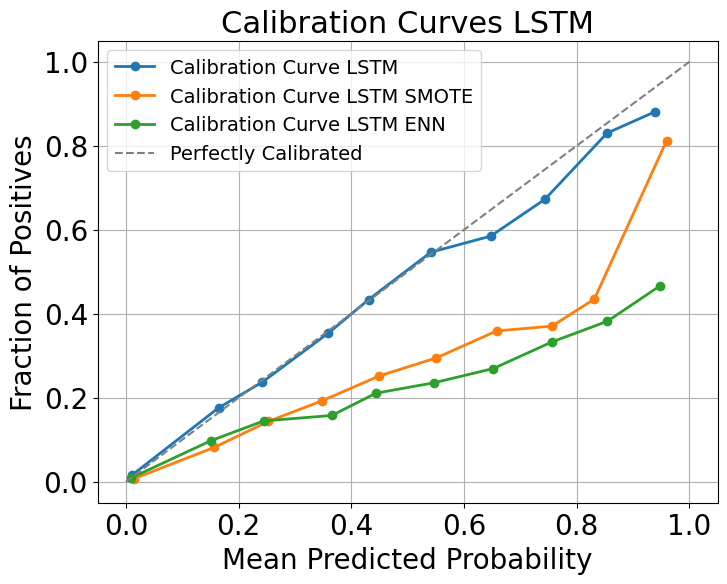

In [ ]:
prob_true_LSTM, prob_pred_LSTM = calibration_curve(y_test, y_pred_LSTM, n_bins=10, strategy='uniform')
prob_true_LSTM_ovs, prob_pred_LSTM_ovs = calibration_curve(y_test, y_pred_LSTM_ovs, n_bins=10, strategy='uniform')
prob_true_LSTM_uns, prob_pred_LSTM_uns = calibration_curve(y_test, y_pred_LSTM_uns, n_bins=10, strategy='uniform')

# Compute Brier scores
brier_score = brier_score_loss(y_test, y_pred_LSTM)
print("Brier Score LSTM:", brier_score)
brier_score = brier_score_loss(y_test, y_pred_LSTM_ovs)
print("Brier Score LSTM SMOTE:", brier_score)
brier_score = brier_score_loss(y_test, y_pred_LSTM_uns)
print("Brier Score LSTM ENN:", brier_score)

# Plot calibration curve
plt.figure(figsize=(8, 6))
plt.plot(prob_pred_LSTM, prob_true_LSTM, marker='o', linewidth=2, label='Calibration Curve LSTM')
plt.plot(prob_pred_LSTM_ovs, prob_true_LSTM_ovs, marker='o', linewidth=2, label='Calibration Curve LSTM SMOTE')
plt.plot(prob_pred_LSTM_uns, prob_true_LSTM_uns, marker='o', linewidth=2, label='Calibration Curve LSTM ENN')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Perfectly Calibrated')

# Increase font sizes for improved readability
plt.xlabel('Mean Predicted Probability', fontsize=20)
plt.ylabel('Fraction of Positives', fontsize=20)
plt.title('Calibration Curves LSTM', fontsize=22)
plt.xticks(fontsize=20)  # Increase tick size
plt.yticks(fontsize=20)
plt.legend(fontsize=14)
plt.grid(True)

# Optionally save the figure in high-quality format
plt.savefig('Calibration_Curve_LSTM.pdf', format='pdf')

plt.show()


              precision    recall  f1-score   support

         0.0       0.89      0.69      0.78     30729
         1.0       0.41      0.72      0.52      9145

    accuracy                           0.70     39874
   macro avg       0.65      0.71      0.65     39874
weighted avg       0.78      0.70      0.72     39874



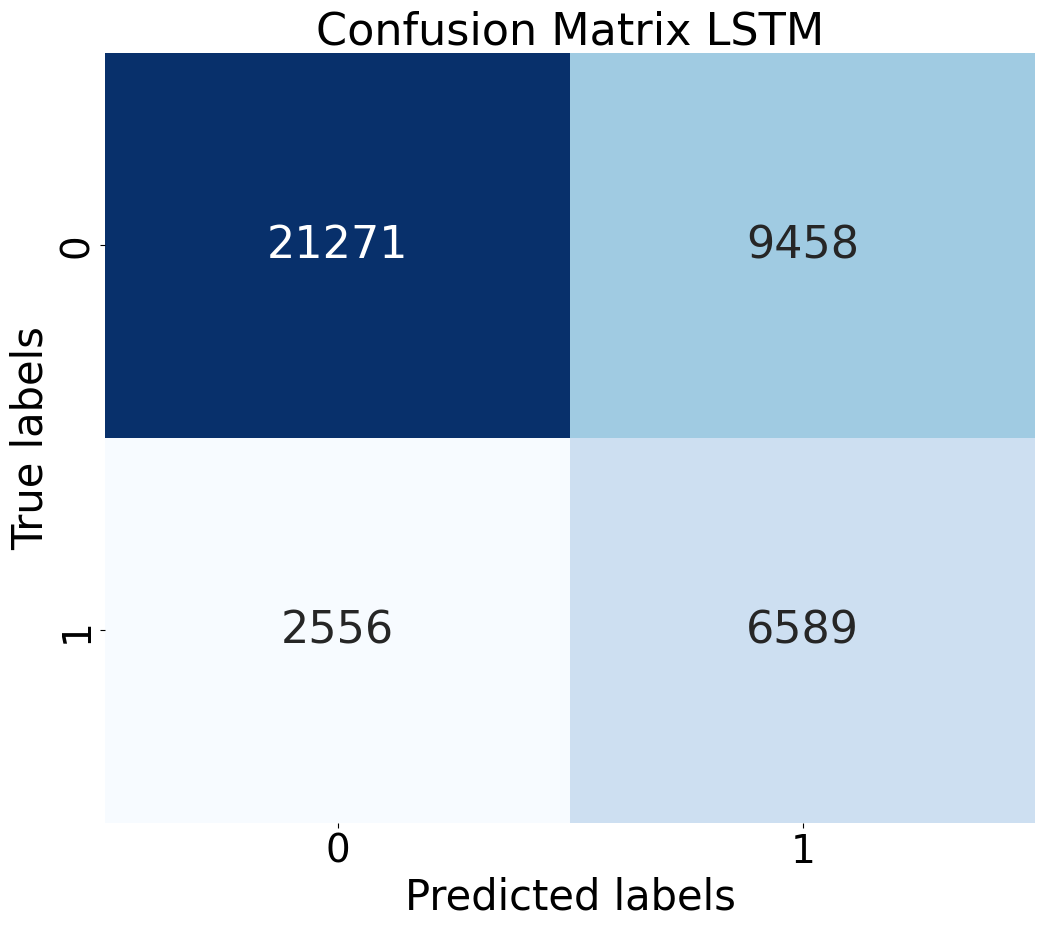

In [ ]:
# Compute confusion matrix and classification report for LSTM
conf_matrix = confusion_matrix(y_test, y_pred_binary_LSTM)
cr_error = classification_report(y_test, y_pred_binary_LSTM)
print(cr_error)

# Plot confusion matrix
plt.figure(figsize=(12, 10))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False, annot_kws={"size": 32})
plt.xlabel('Predicted labels', fontsize=30)
plt.ylabel('True labels', fontsize=30)
plt.title('Confusion Matrix LSTM', fontsize=32)
plt.xticks(fontsize=28)
plt.yticks(fontsize=28)
plt.savefig('Confusion_Matrix_LSTM.pdf', format='pdf')
plt.show()

              precision    recall  f1-score   support

         0.0       0.89      0.69      0.78     30729
         1.0       0.41      0.72      0.52      9145

    accuracy                           0.70     39874
   macro avg       0.65      0.71      0.65     39874
weighted avg       0.78      0.70      0.72     39874



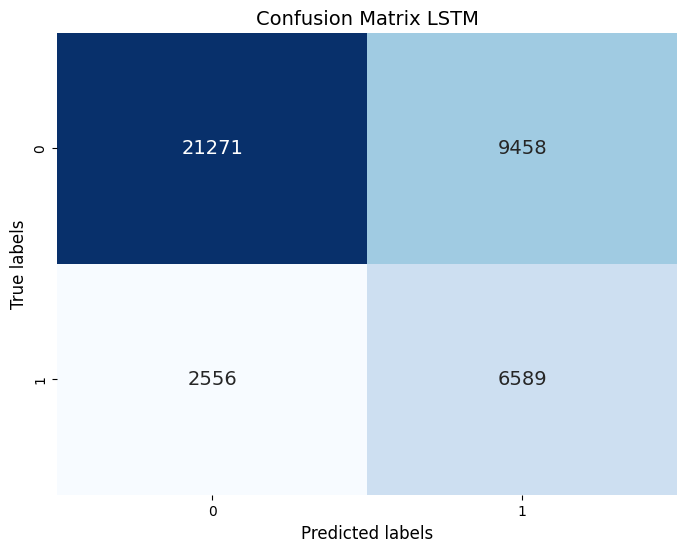

In [ ]:
# Generate the confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred_binary_LSTM)
cr_error = classification_report(y_test, y_pred_binary_LSTM)
print(cr_error)

# Create the plot
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False, annot_kws={"size": 14})  # Increase font size here
plt.xlabel('Predicted labels', fontsize=12)  # Optionally increase font size of axis labels
plt.ylabel('True labels', fontsize=12)
plt.title('Confusion Matrix LSTM', fontsize=14)  # Optionally increase font size of the title
# plt.savefig('Confusion Matrix LSTM.pdf')
plt.show()

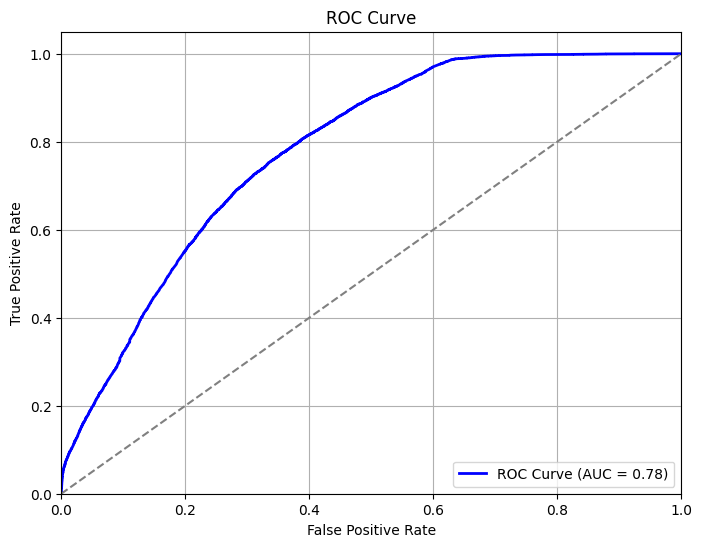

In [ ]:
# Compute ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred)

# Compute ROC-AUC score
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label='ROC Curve (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

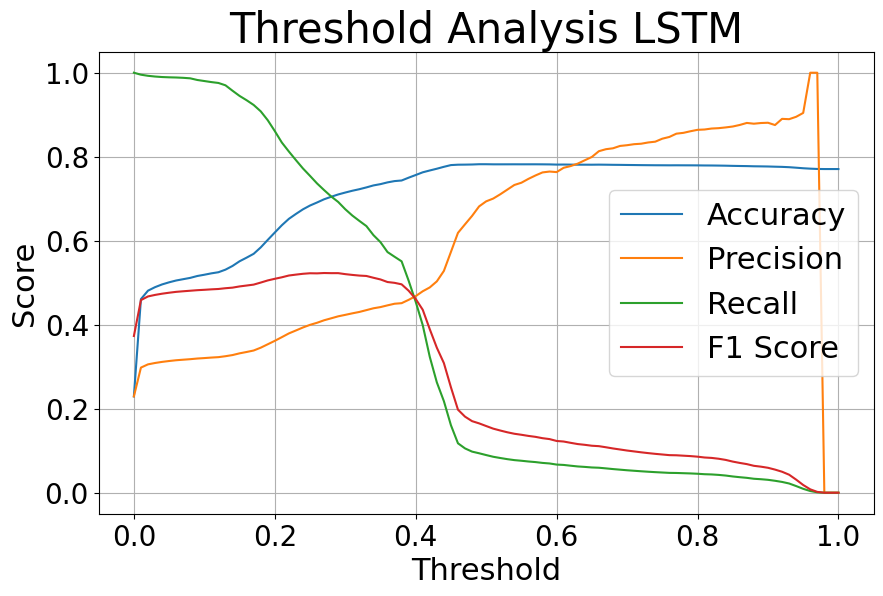

In [ ]:
thresholds = np.linspace(0, 1, 101)  # 100 thresholds from 0 to 1

# Initialize lists to store evaluation metrics
accuracy_scores = []
precision_scores = []
recall_scores = []
f1_scores = []

# Iterate over each threshold
for threshold in thresholds:
    # Convert probabilities to binary predictions based on the threshold
    y_pred_binary_LSTM = np.where(y_pred > threshold, 1, 0)

    # Evaluate the model using the current threshold
    accuracy = accuracy_score(y_test, y_pred_binary_LSTM)
    precision = precision_score(y_test, y_pred_binary_LSTM)
    recall = recall_score(y_test, y_pred_binary_LSTM)
    f1 = f1_score(y_test, y_pred_binary_LSTM)

    # Append evaluation metrics to lists
    accuracy_scores.append(accuracy)
    precision_scores.append(precision)
    recall_scores.append(recall)
    f1_scores.append(f1)

# Plot the evaluation metrics against thresholds
plt.figure(figsize=(10, 6))

plt.plot(thresholds, accuracy_scores, label='Accuracy')
plt.plot(thresholds, precision_scores, label='Precision')
plt.plot(thresholds, recall_scores, label='Recall')
plt.plot(thresholds, f1_scores, label='F1 Score')

plt.xlabel('Threshold', fontsize=22)
plt.ylabel('Score', fontsize=22)
plt.title('Threshold Analysis LSTM', fontsize=30)
plt.legend(fontsize=22)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.grid(True)

plt.savefig('Threshold_Analysis_LSTM.pdf', format='pdf')
plt.show()

In [ ]:
# Train the model
history = model_LSTM.fit(X_train_reshaped, y_train, epochs=10, batch_size=64, validation_data=(X_val_reshaped, y_val))

Epoch 1/10
1870/1870 [==============================] - 14s 6ms/step - loss: 0.4304 - accuracy: 0.7834 - val_loss: 0.4349 - val_accuracy: 0.7834
Epoch 2/10
1870/1870 [==============================] - 12s 6ms/step - loss: 0.4296 - accuracy: 0.7832 - val_loss: 0.4296 - val_accuracy: 0.7838
Epoch 3/10
1870/1870 [==============================] - 13s 7ms/step - loss: 0.4289 - accuracy: 0.7838 - val_loss: 0.4304 - val_accuracy: 0.7830
Epoch 4/10
1870/1870 [==============================] - 13s 7ms/step - loss: 0.4277 - accuracy: 0.7838 - val_loss: 0.4315 - val_accuracy: 0.7815
Epoch 5/10
1870/1870 [==============================] - 13s 7ms/step - loss: 0.4265 - accuracy: 0.7859 - val_loss: 0.4368 - val_accuracy: 0.7825
Epoch 6/10
1870/1870 [==============================] - 11s 6ms/step - loss: 0.4267 - accuracy: 0.7837 - val_loss: 0.4264 - val_accuracy: 0.7872
Epoch 7/10
1870/1870 [==============================] - 11s 6ms/step - loss: 0.4235 - accuracy: 0.7865 - val_loss: 0.4275 - val_ac

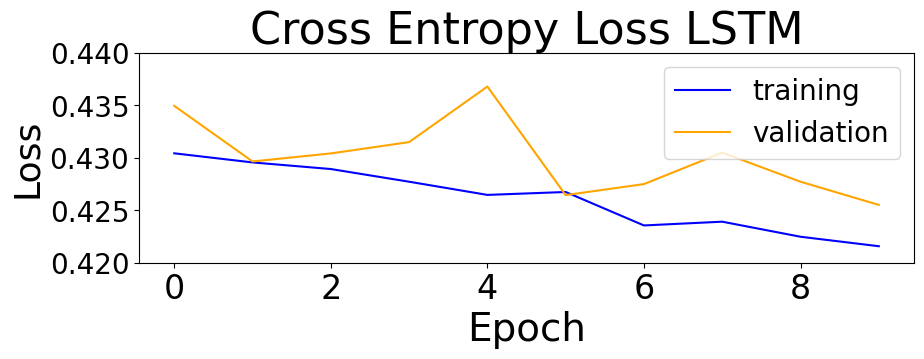

In [ ]:
# Plot Cross Entropy Loss for LSTM
plt.figure(figsize=(10, 6))
plt.subplot(211)
plt.title('Cross Entropy Loss LSTM', fontsize=32)
plt.plot(history.history['loss'], color='blue', label='train')
plt.plot(history.history['val_loss'], color='orange', label='test')
plt.legend(['training', 'validation'], fontsize=20)
plt.xlabel('Epoch', fontsize=28)
plt.ylabel('Loss', fontsize=26)
plt.xticks(fontsize=24)

# Setting the y-ticks to show only every second label
y_ticks = plt.gca().get_yticks()
plt.gca().set_yticks(y_ticks[::2])
plt.yticks(fontsize=20)

plt.savefig('Cross_Entropy_Loss_LSTM.pdf', format='pdf')
plt.show()

### SHAP

##### Kmeans

In [59]:
np.random.seed(42)
sample_size = 200
sample_indices = np.random.choice(len(padded_sequences_test), size=sample_size, replace=False)
subset_X_test_reshaped = padded_sequences_test[sample_indices]

In [ ]:
background_summary = shap.kmeans(subset_X_test_reshaped, 5)
kernel_explainer = shap.KernelExplainer(model_LSTM.predict, background_summary)
shap_values_test_kernel_LSTM = kernel_explainer.shap_values(subset_X_test_reshaped, verbose = False)

1/1 [==============================] - 0s 346ms/step


  0%|          | 0/200 [00:00<?, ?it/s]

330/330 [==============================] - 1s 2ms/step


In [ ]:
np.save('/content/drive/My Drive/Thesis/Datasets/shap_values_test_kernel_LSTM.npy', shap_values_test_kernel_LSTM)

In [60]:
file_path = '/content/drive/My Drive/Thesis/Datasets/shap_values_test_kernel_LSTM.npy'
shap_values_test_kernel_LSTM = np.load(file_path)

In [61]:
feature_names = [f"TS {i+1}" for i in range(subset_X_test_reshaped.shape[1])]

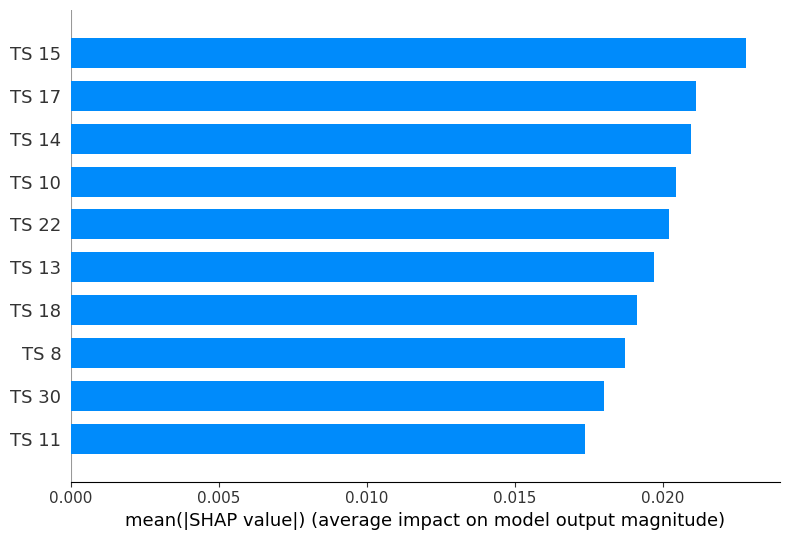

In [62]:
# Reshape the SHAP values matrix to match the shape of the features matrix
shap_values_test_kernel_LSTM_reshaped = shap_values_test_kernel_LSTM.reshape(shap_values_test_kernel_LSTM.shape[0], shap_values_test_kernel_LSTM.shape[1], -1)

# Aggregate SHAP values across all features
shap_values_aggregated = np.mean(shap_values_test_kernel_LSTM, axis=2)

# Get the mean absolute SHAP values for each feature
mean_abs_shap_values = np.mean(np.abs(shap_values_aggregated), axis=0)

# Sort the features based on their mean absolute SHAP values
sorted_indices = np.argsort(mean_abs_shap_values)[::-1]

# Select only the top ten features
top_ten_indices = sorted_indices[:10]
top_ten_features = subset_X_test_reshaped[:, top_ten_indices]
top_ten_feature_names = [feature_names[i] for i in top_ten_indices]

# Plot the aggregated SHAP values for the top ten features
shap.summary_plot(shap_values_aggregated[:, top_ten_indices], features=top_ten_features, feature_names=top_ten_feature_names , plot_type='bar')

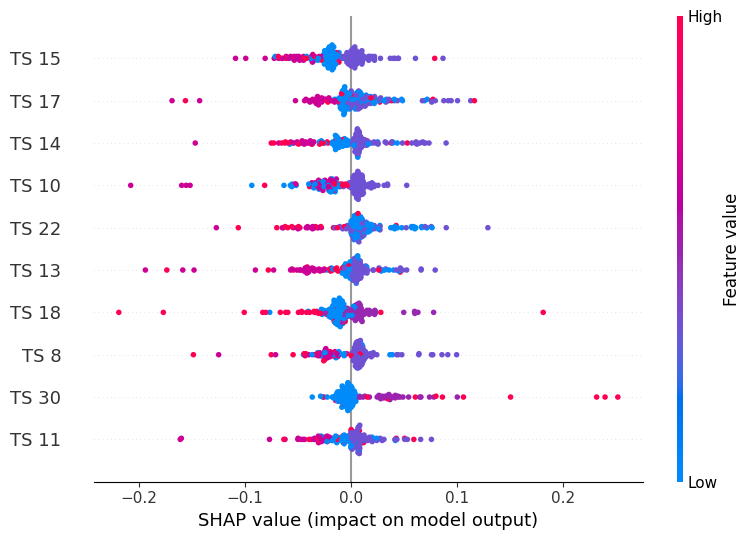

In [63]:
shap.summary_plot(shap_values_aggregated[:, top_ten_indices], features=top_ten_features, feature_names=top_ten_feature_names)

In [66]:
background_summary = shap.kmeans(subset_X_test_reshaped, 5)
kernel_explainer = shap.KernelExplainer(model_LSTM.predict, background_summary)

1/1 [==============================] - 1s 704ms/step


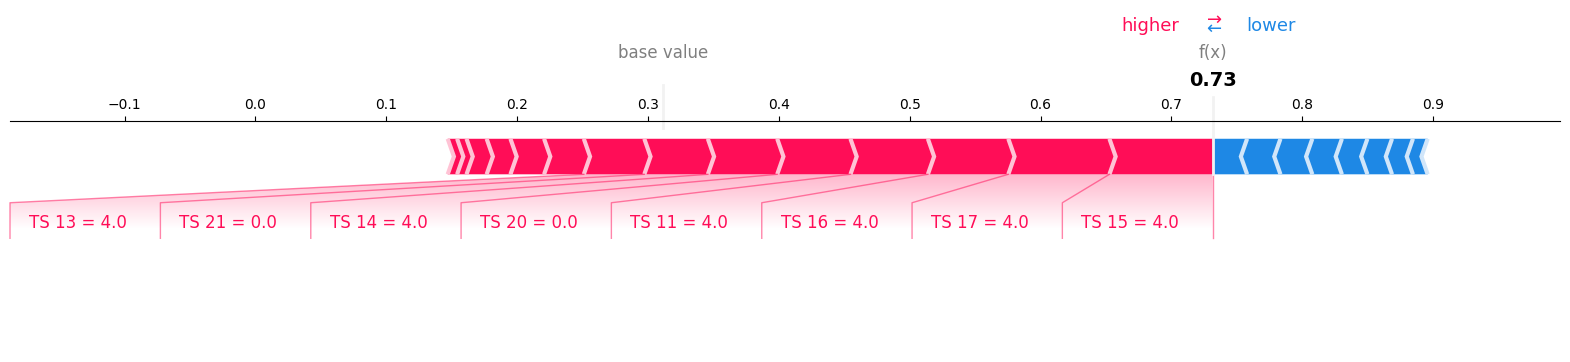

In [67]:
# Choose an instance to explain (e.g., the first instance)
instance_index = 10

# Generate force plot for the chosen instance
shap.force_plot(kernel_explainer.expected_value, shap_values_test_kernel_LSTM[instance_index][:, 0], subset_X_test_reshaped[instance_index], matplotlib=True, feature_names= feature_names)

1247/1247 [==============================] - 6s 4ms/step


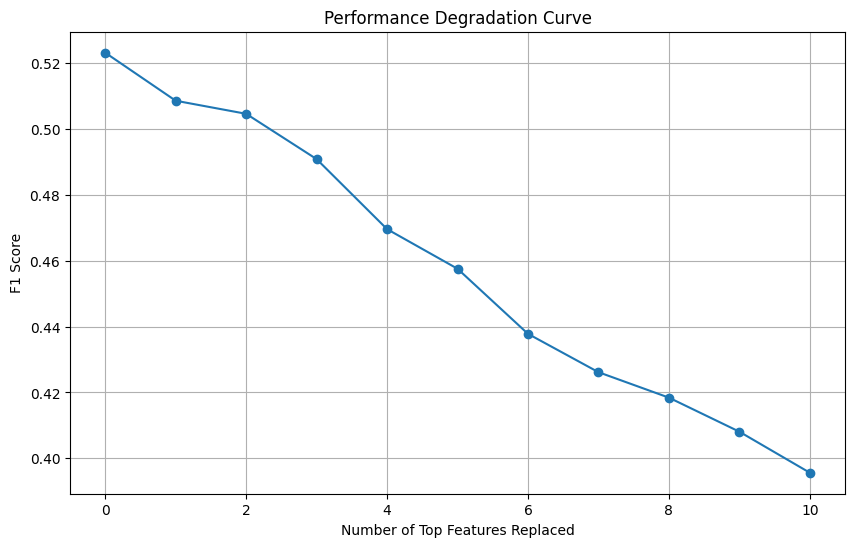

In [ ]:
# Create a copy of the test data to modify
modified_test_set = np.array(padded_sequences_test)

# Store original F1 score with unmodified data
original_pred = model_LSTM.predict(padded_sequences_test)
original_f1 = f1_score(y_test, (original_pred > 0.27).astype(int))

# Initialize a list to store F1 scores after each feature modification
f1_scores_LSTM = [original_f1]

# Replace each top feature with the majority value found in that feature
for i, feature_idx in enumerate(top_ten_indices):
    # Find the majority class for the current feature across all test data
    majority_value = np.bincount(modified_test_set[:, feature_idx]).argmax()

    # Replace this feature in all test samples with the majority class
    modified_test_set[:, feature_idx] = majority_value

    # Evaluate the model with the modified test set
    new_predictions = model_LSTM.predict(modified_test_set)
    new_f1 = f1_score(y_test, (new_predictions > 0.27).astype(int))

    # Append the new F1 score
    f1_scores_LSTM.append(new_f1)

# Plot the performance degradation curve
plt.figure(figsize=(10, 6))
plt.plot(range(len(f1_scores_LSTM)), f1_scores_LSTM, marker='o')
plt.title('Performance Degradation Curve')
plt.xlabel('Number of Top Features Replaced')
plt.ylabel('F1 Score')
plt.grid(True)

In [ ]:
f1_scores_LSTM

[0.5231025722451572,
 0.5085287846481876,
 0.5045594995855001,
 0.4908072963698754,
 0.4695515557225315,
 0.45752699124057855,
 0.4377709972699534,
 0.4261356641634864,
 0.41840752652619556,
 0.4080712303422757,
 0.395615776301027]

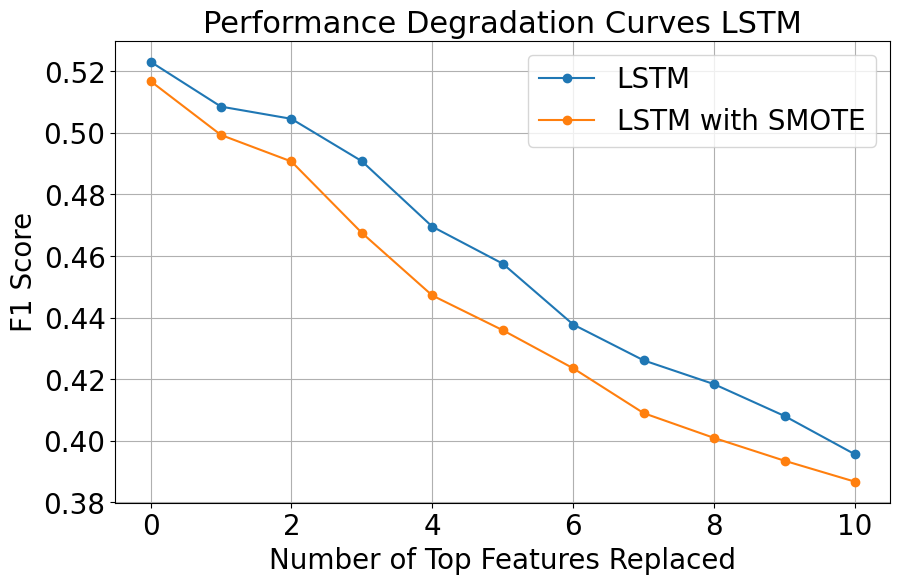

In [ ]:
# Create the plot
plt.figure(figsize=(10, 6))
plt.plot(range(len(f1_scores_LSTM)), f1_scores_LSTM, marker='o', label='LSTM')
plt.plot(range(len(f1_scores_LSTM_ovs)), f1_scores_LSTM_ovs, marker='o', label='LSTM with SMOTE')

# Adding title and labels with increased font size
plt.title('Performance Degradation Curves LSTM', fontsize=22)  # Increase font size for the title
plt.xlabel('Number of Top Features Replaced', fontsize=20)  # Increase font size for x-axis label
plt.ylabel('F1 Score', fontsize=20)  # Increase font size for y-axis label

# Increase font size for tick labels on both axes
plt.xticks(fontsize=20)  # Increase font size for x-axis tick labels
plt.yticks(fontsize=20)  # Increase font size for y-axis tick labels

plt.grid(True)

# Increase font size for the legend
plt.legend(fontsize=20)

# Save the plot to a PDF file
plt.savefig('Performance Degradation Curves LSTM.pdf')
# Show the plot
plt.show()

In [ ]:
import matplotlib.pyplot as plt

# Create the plot
plt.figure(figsize=(10, 6))
plt.plot(range(len(f1_scores_LSTM)), f1_scores_LSTM, marker='o', label='LSTM')
plt.plot(range(len(f1_scores_LSTM_ovs)), f1_scores_LSTM_ovs, marker='o', label='LSTM with SMOTE')

# Adding title and labels with increased font size
plt.title('Performance Degradation Curves LSTM', fontsize=16)  # Increase font size for the title
plt.xlabel('Number of Top Features Replaced', fontsize=14)  # Increase font size for x-axis label
plt.ylabel('F1 Score', fontsize=14)  # Increase font size for y-axis label

# Increase font size for tick labels on both axes
plt.xticks(fontsize=12)  # Increase font size for x-axis tick labels
plt.yticks(fontsize=12)  # Increase font size for y-axis tick labels

plt.grid(True)

# Increase font size for the legend
plt.legend(fontsize=12)

# Save the plot to a PDF file
plt.savefig('Performance Degradation Curves LSTM.pdf')
# Show the plot
plt.show()

##### Both classes

In [ ]:
# Filter the dataset for "cart abandonment" sessions (target = 0)
cart_abandonment_sessions = df_train[df_train["conversion"] == 0][["session_id_hash", "session"]]
sequences_train_ca = cart_abandonment_sessions['session'].tolist()
sequences_train_ca = [[int(num) for num in item.strip("[]").split(', ')] for item in sequences_train_ca]
max_length = 30  # Choose the maximum length you want
padded_sequences_ca = pad_sequences(sequences_train_ca, maxlen= max_length, padding='post', truncating='post')

# Filter the dataset for "purchase" sessions (target = 1)
purchase_sessions = df_train[df_train["conversion"] == 1][["session_id_hash", "session"]]
sequences_train_pu = purchase_sessions['session'].tolist()
sequences_train_pu = [[int(num) for num in item.strip("[]").split(', ')] for item in sequences_train_pu]
max_length = 30  # Choose the maximum length you want
padded_sequences_pu = pad_sequences(sequences_train_pu, maxlen= max_length, padding='post', truncating='post')

In [ ]:
# Set a fixed random seed
np.random.seed(42)

sample_size = 100
sample_indices = np.random.choice(len(padded_sequences_ca), size=sample_size, replace=False)
subset_X_test_reshaped_ca = padded_sequences_ca[sample_indices]

sample_indices = np.random.choice(len(padded_sequences_pu), size=sample_size, replace=False)
subset_X_test_reshaped_pu = padded_sequences_pu[sample_indices]

In [ ]:
# Summarize the background data using k-means
background_summary = shap.kmeans(subset_X_test_reshaped_ca, 5)  # You can adjust the number of clusters (K) as needed

# Create an explainer using the Kernel SHAP method with the summarized background data
kernel_explainer = shap.KernelExplainer(model_LSTM.predict, background_summary)

# Compute SHAP values for the test data
shap_values_class0 = kernel_explainer.shap_values(subset_X_test_reshaped_ca)

1/1 [==============================] - 0s 329ms/step


  0%|          | 0/100 [00:00<?, ?it/s]

330/330 [==============================] - 1s 2ms/step


In [ ]:
# Summarize the background data using k-means
background_summary = shap.kmeans(subset_X_test_reshaped_pu, 5)  # You can adjust the number of clusters (K) as needed

# Create an explainer using the Kernel SHAP method with the summarized background data
kernel_explainer = shap.KernelExplainer(model_LSTM.predict, background_summary)

# Compute SHAP values for the test data
shap_values_class1 = kernel_explainer.shap_values(subset_X_test_reshaped_pu)

1/1 [==============================] - 0s 19ms/step


  0%|          | 0/100 [00:00<?, ?it/s]

329/329 [==============================] - 1s 3ms/step


In [ ]:
# Define feature names based on the time steps in the sequence
# TS = Time Step
feature_names = [f"TS {i+1}" for i in range(subset_X_test_reshaped_ca.shape[1])]

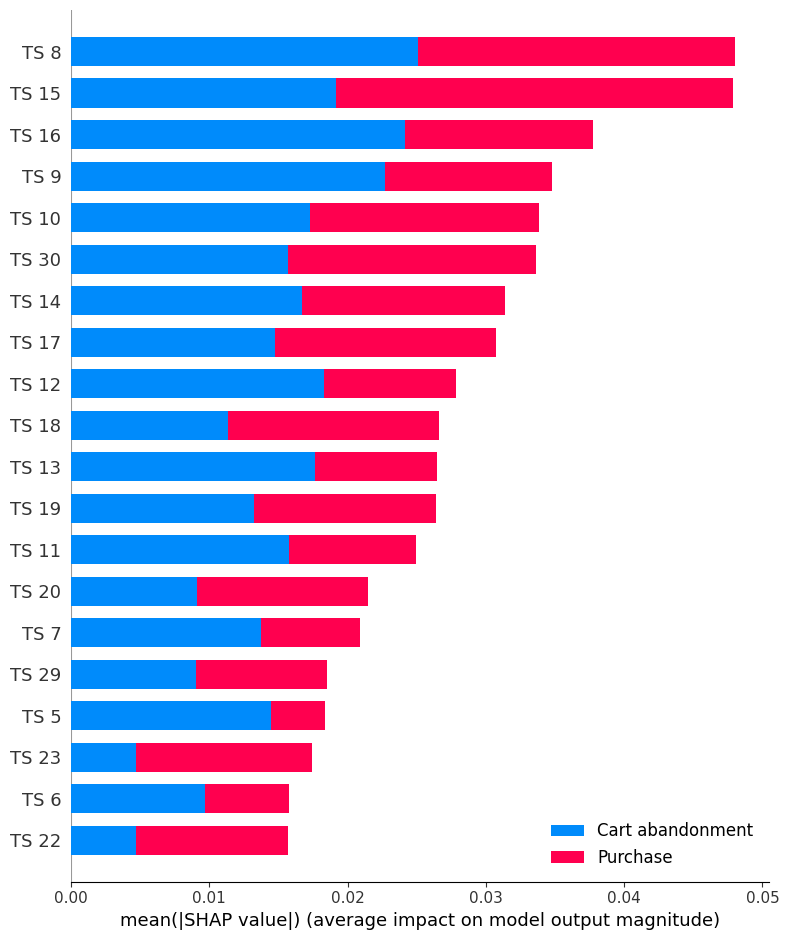

In [ ]:
# Reshape the SHAP values matrix to match the shape of the features matrix for each class
shap_values_class0_reshaped = shap_values_class0.reshape(shap_values_class0.shape[0], shap_values_class0.shape[1], -1)
shap_values_class1_reshaped = shap_values_class1.reshape(shap_values_class1.shape[0], shap_values_class1.shape[1], -1)

# Aggregate SHAP values across all features for each class
shap_values_class0_aggregated = np.mean(shap_values_class0, axis=2)
shap_values_class1_aggregated = np.mean(shap_values_class1, axis=2)

# Create a matplotlib figure and axis
fig, ax = plt.subplots()

# Plot the aggregated SHAP values for the top ten features for both classes in one summary plot
shap.summary_plot([shap_values_class0_aggregated, shap_values_class1_aggregated],
                  feature_names=feature_names,
                  plot_type='bar',
                  class_names=['Cart abandonment', 'Purchase'],
                  show=False)  # Prevents immediate showing of the plot

# Save the figure as a PDF
plt.savefig('shap_summary_plot_LSTM.pdf', bbox_inches='tight')  # Save as PDF

# If you want to display the plot as well, uncomment the next line
# plt.show()

## Oracle

In [ ]:
X_test.head()

session_id_hash  \
139173  b2410d2c9a0f5c3e5674b7ecfb5072e9d8cfeed51a8527...   
25840   2101ff15b51412a2ca58b7e266f02670345310c259a115...   
25719   20db6a581ee197ecb7b819083d1e07713c59134301d66b...   
193479  f8666eda87b62d9ab550c7e9445ead5274b6acadebdfe2...   
50714   413508364819d4afd5d4d0246af8fb826f0ac8116b3817...   

                                                  session  
139173  [1, 1, 1, 1, 1, 1, 2, 1, 1, 2, 1, 2, 1, 2, 3, ...  
25840   [1, 2, 1, 2, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 2, ...  
25719   [1, 1, 1, 1, 1, 2, 3, 1, 2, 1, 3, 1, 1, 1, 1, ...  
193479  [1, 2, 1, 1, 2, 1, 3, 1, 1, 1, 1, 1, 2, 1, 1, ...  
50714                         [1, 1, 2, 3, 1, 1, 1, 1, 1]

In [ ]:
symbolised_sessions = sequences_test
labels = labels_test

In [ ]:
d = defaultdict(lambda: defaultdict(int))
for session, label in zip(symbolised_sessions, labels):
    d[str(tuple(session))][label] += 1
# print(d)
print(list(d.items())[:5])

[('(1, 1, 1, 1, 1, 1, 2, 1, 1, 2, 1, 2, 1, 2, 3, 2, 1, 1, 1, 2, 3, 1, 4, 1, 1, 1, 1, 1, 1, 2)', defaultdict(<class 'int'>, {0.0: 1})), ('(1, 2, 1, 2, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 2, 1, 3, 3, 1, 1, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0)', defaultdict(<class 'int'>, {0.0: 1})), ('(1, 1, 1, 1, 1, 2, 3, 1, 2, 1, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)', defaultdict(<class 'int'>, {0.0: 1})), ('(1, 2, 1, 1, 2, 1, 3, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0)', defaultdict(<class 'int'>, {0.0: 1})), ('(1, 1, 2, 3, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)', defaultdict(<class 'int'>, {1.0: 6, 0.0: 7}))]


In [ ]:
oracle = {}
for session in d.keys():
    n_buy, n_ws = 0, 0
    for label in d[session].keys():
        if label:
            n_buy += d[session][label]
        else:
            n_ws += d[session][label]
    oracle[session] = n_buy / (n_buy + n_ws)

print(list(oracle.items())[:15])

[('(1, 1, 1, 1, 1, 1, 2, 1, 1, 2, 1, 2, 1, 2, 3, 2, 1, 1, 1, 2, 3, 1, 4, 1, 1, 1, 1, 1, 1, 2)', 0.0), ('(1, 2, 1, 2, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 2, 1, 3, 3, 1, 1, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0)', 0.0), ('(1, 1, 1, 1, 1, 2, 3, 1, 2, 1, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)', 0.0), ('(1, 2, 1, 1, 2, 1, 3, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0)', 0.0), ('(1, 1, 2, 3, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)', 0.46153846153846156), ('(2, 1, 3, 1, 1, 2, 1, 2, 1, 2, 1, 2, 1, 2, 1, 1, 2, 2, 1, 1, 2, 1, 1, 2, 1, 1, 1, 1, 2, 1)', 1.0), ('(1, 2, 1, 2, 3, 1, 1, 1, 1, 2, 1, 3, 1, 1, 2, 1, 1, 1, 1, 2, 3, 1, 2, 1, 1, 1, 1, 1, 1, 0)', 1.0), ('(1, 2, 1, 2, 1, 1, 2, 2, 1, 1, 1, 1, 1, 1, 2, 1, 2, 3, 4, 1, 4, 4, 4, 4, 4, 0, 0, 0, 0, 0)', 1.0), ('(1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 2, 1, 3, 1, 1, 1, 1, 1, 2, 1, 1)', 1.0), ('(1, 1, 1, 1, 1, 2, 1, 2, 1, 1, 1, 1, 2, 3, 1, 2, 1, 0, 0, 0, 0, 0, 0, 0,

In [ ]:
def get_oracle_conversion(actions):
    key = str(tuple(actions))
    probability = oracle.get(key, None)
    if probability is not None:
        if random.random() < probability:
            return 1
        else:
            return 0
    else:
        return None

sessions_test = sequences_test
# sessions_test = sessions_test.to_list()
# sessions_test = [[int(num) for num in item.strip("[]").split(', ')] for item in sessions_test]
labels_test = y_test.to_list()

data = {'session': sessions_test.tolist(), 'conversion': labels_test}
X_test = pd.DataFrame(data)

In [ ]:
# Apply the function to create the new column
X_test['oracle_conversion'] = X_test['session'].apply(get_oracle_conversion)
X_test.head(15)

session  conversion  \
0   [1, 1, 1, 1, 1, 1, 2, 1, 1, 2, 1, 2, 1, 2, 3, ...         0.0   
1   [1, 2, 1, 2, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 2, ...         0.0   
2   [1, 1, 1, 1, 1, 2, 3, 1, 2, 1, 3, 1, 1, 1, 1, ...         0.0   
3   [1, 2, 1, 1, 2, 1, 3, 1, 1, 1, 1, 1, 2, 1, 1, ...         0.0   
4   [1, 1, 2, 3, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, ...         1.0   
5   [2, 1, 3, 1, 1, 2, 1, 2, 1, 2, 1, 2, 1, 2, 1, ...         1.0   
6   [1, 2, 1, 2, 3, 1, 1, 1, 1, 2, 1, 3, 1, 1, 2, ...         1.0   
7   [1, 2, 1, 2, 1, 1, 2, 2, 1, 1, 1, 1, 1, 1, 2, ...         1.0   
8   [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, ...         1.0   
9   [1, 1, 1, 1, 1, 2, 1, 2, 1, 1, 1, 1, 2, 3, 1, ...         0.0   
10  [2, 1, 1, 2, 3, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...         0.0   
11  [1, 1, 1, 2, 1, 1, 1, 1, 2, 1, 2, 1, 1, 2, 1, ...         0.0   
12  [1, 1, 1, 1, 1, 1, 1, 2, 1, 2, 1, 2, 1, 2, 1, ...         1.0   
13  [2, 1, 3, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...         0.0   
14  [1, 1, 1, 1, 1, 2, 1, 3, 1, 1, 2, 3, 1, 1, 1, ...         1.0   

    oracle_conversion  
0                   0  
1                   0  
2                   0  
3                   0  
4                   1  
5                   1  
6                   1  
7                   1  
8                   1  
9                   0  
10                  0  
11                  0  
12                  1  
13                  1  
14                  1

In [ ]:
oracle_label = X_test['oracle_conversion'].tolist()
f1 = f1_score(labels, oracle_label)
print("F1 Score:", f1)

F1 Score: 0.8470973017170891


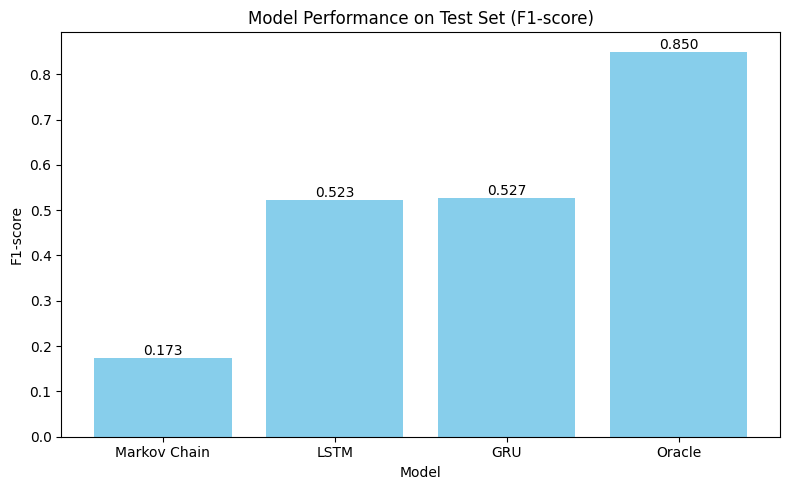

In [ ]:
data = {
    'Model': ['Markov Chain', 'LSTM', 'GRU', 'Oracle'],
    'F1-score': [0.173, 0.523, 0.527, 0.850]
}

df_test = pd.DataFrame(data)

# Plotting
fig, ax = plt.subplots(figsize=(8, 5))
bars = ax.bar(df_test['Model'], df_test['F1-score'], color='skyblue')

# Adding numbers to the bars
for bar in bars:
    yval = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2, yval, f'{yval:.3f}', ha='center', va='bottom')  # Improved alignment

# Customize the plot
ax.set_title('Model Performance on Test Set (F1-score)')
ax.set_ylabel('F1-score')
ax.set_xlabel('Model')
plt.xticks(rotation=0)

# Show plot
plt.tight_layout()

# Save the plot as a PDF file
plt.savefig('Model_Performance_F1_Score.pdf')

plt.show()


# Models with adressing class imbalance

Train-Test Split

In [ ]:
df_train = pd.read_csv("/content/drive/MyDrive/Thesis/Datasets/df_train_processed_trimmed.csv")

In [ ]:
X = df_train[["session_id_hash", "session"]]  # Features
y = df_train["conversion"]  # Target variable

# Splitting the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
X_train.head()

session_id_hash  \
317     006663e8030ec06f59b5f7b9401fc5a85fedfba541296a...   
150615  c0ea26f06f885f2e647ff6c945f64621596170c285f857...   
191502  f5d3c2a190d0fe44b3f5cb6b093dd8e1092ac9d7f29fe4...   
181330  e8b5f2ba42ff1168c314d7220983403053457ddf968c7b...   
147450  bce118d59635f73d6afa0816e5fa154d7a4ce65f651a42...   

                                                  session  
317     [1, 1, 2, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, ...  
150615  [1, 2, 2, 1, 1, 2, 1, 2, 1, 2, 1, 2, 3, 1, 2, ...  
191502  [1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 2, 1, 1, 1, ...  
181330  [1, 2, 3, 4, 1, 4, 1, 4, 4, 1, 4, 4, 4, 4, 4, ...  
147450  [1, 1, 1, 1, 2, 1, 1, 1, 1, 2, 3, 1, 2, 1, 1, ...

## Oversampling SMOTE

### Markov Chain

In [23]:
df_train = pd.read_csv("/content/drive/MyDrive/Thesis/Datasets/df_train_processed.csv")

In [24]:
df_train = df_train.groupby('session_id_hash').agg({'product_action_symb': list, 'conversion': 'first'}).reset_index()

In [25]:
df_train = df_train.rename(columns={'product_action_symb': 'session'})
df_train.head(10)

session_id_hash  \
0  00000114e1075962f022114fcfc17f2d874e694ac5d201...   
1  000010504025397b03290c7457e0e7ef7ae93529f21eae...   
2  0000913afa22ba9c31efb992bcf6388b0bbfe28056bef3...   
3  00010d84aca1294479304044207fd268f63228844779c6...   
4  0001368d732951035a7ef7ef42b345a5c50b7d66966749...   
5  0001c180fb742f96ff388ba8f67a568e6fa66aed30d0d2...   
6  00024a2cbef8be2015bf16d355226c4b4d60b4e5216dea...   
7  0002629c632e1d3211649ba4498194a13a280c35c6bd57...   
8  00029b95dceb71ae63445fb5fdc844104aabd047793277...   
9  0002cc06d46d4835503b88e9eed2c8fc1ae97f5cc262a9...   

                                             session  conversion  
0  [1, 2, 3, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 2, 1, ...         0.0  
1  [2, 1, 2, 1, 2, 1, 1, 2, 1, 1, 1, 2, 2, 1, 2, ...         0.0  
2  [1, 1, 1, 2, 1, 1, 2, 1, 1, 1, 1, 2, 1, 1, 1, ...         0.0  
3  [1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, ...         0.0  
4   [1, 2, 3, 1, 1, 2, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1]         0.0  
5  [1, 1, 1, 1, 2, 3, 4, 1, 2, 1, 1, 1, 4, 4, 4, ...         1.0  
6  [1, 2, 2, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...         0.0  
7  [1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 3, 4, ...         1.0  
8  [1, 1, 1, 1, 2, 1, 1, 2, 1, 1, 2, 1, 1, 1, 1, ...         0.0  
9  [1, 2, 2, 1, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, ...         0.0

In [26]:
X = df_train[["session_id_hash", "session"]]  # Features
y = df_train["conversion"]  # Target variable

# Splitting the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [27]:
sequences_train = X_train['session'].tolist()
sequences_test = X_test['session'].tolist()

# Pad sequences to a fixed length
max_length = 30
padded_sequences_train = pad_sequences(sequences_train, maxlen= max_length, padding='post', truncating='post')
padded_sequences_test = pad_sequences(sequences_test, maxlen= max_length, padding='post', truncating='post')

# Convert padded sequences to NumPy array
sequences_train = np.array(padded_sequences_train)
labels_train = np.array(y_train)
sequences_test = np.array(padded_sequences_test)
labels_test = np.array(y_test)

In [28]:
print("Class distribution before oversampling:", Counter(labels_train))
# transform the dataset
oversample = SMOTE(sampling_strategy = 'minority', k_neighbors = 3)

sequences_train_res, labels_train_res = oversample.fit_resample(sequences_train, labels_train)
# Print the distribution of classes after oversampling
print("Class distribution after oversampling:", Counter(labels_train_res))

Class distribution before oversampling: Counter({0.0: 122918, 1.0: 36594})
Class distribution after oversampling: Counter({0.0: 122918, 1.0: 122918})


In [29]:
def get_transitions(sessions):
    n_events = len(set(item for session in sessions for item in session if item != 0))
    transitions = np.zeros((n_events, n_events))
    for session in sessions:
        for i, event in enumerate(session):
            # If the event is not 0 and there is a next event in the session
            if event != 0 and i < len(session) - 1:
                transitions[event - 1, session[i + 1] - 1] += 1
    row_sums = transitions.sum(axis=1)
    return transitions / row_sums[:, np.newaxis]

# Example usage
transitions_session = get_transitions(sequences_train_res)

In [30]:
transitions_session[:7]

array([[6.62635342e-01, 2.20366726e-01, 4.41184580e-02, 2.12728047e-02,
        5.16066693e-02],
       [7.70111366e-01, 9.73520366e-02, 1.09242976e-01, 8.64590733e-03,
        1.46477144e-02],
       [7.71776568e-01, 6.12055348e-02, 4.61548204e-02, 8.87668476e-02,
        3.20962289e-02],
       [4.57595050e-01, 1.56092840e-02, 6.52697508e-02, 4.36875099e-01,
        2.46508163e-02],
       [6.62086346e-01, 1.77891304e-03, 5.47357858e-04, 6.95600611e-04,
        3.34891783e-01]])

<Axes: >

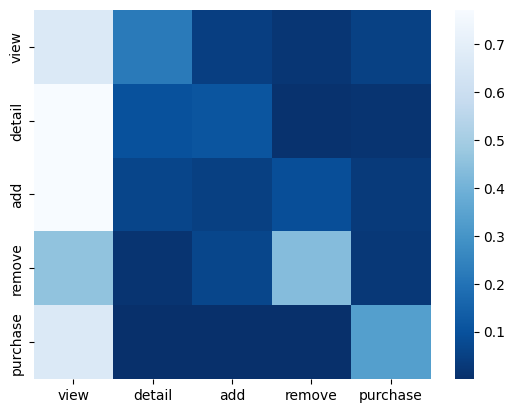

In [31]:
actions = ["view", "detail", "add", "remove", "purchase"]
sns.heatmap(transitions_session, cmap='Blues_r',xticklabels = actions, yticklabels = actions)
# We read the heatmap as a conditional probability from the row event to the column event

In [32]:
class MarkovChain:
    def __init__(self, transition_matrix, actions):
        self.transition_matrix = transition_matrix
        self.actions = actions

    def predict_purchase_probability(self, sequence):
        final_state = sequence[-1]  # Last action in the sequence
        purchase_probability = self.transition_matrix[final_state - 1][self.actions.index(5)]
        return purchase_probability

actions = [1, 2, 3, 4, 5]
# Example usage:
transition_matrix = np.array([[6.62562203e-01, 2.20348671e-01, 4.41439490e-02, 2.12582739e-02, 5.16869033e-02],
                              [7.69961220e-01, 9.73072879e-02, 1.09393509e-01, 8.66784157e-03, 1.46701420e-02],
                              [7.71892124e-01, 6.10777769e-02, 4.63974452e-02, 8.84723873e-02, 3.21602667e-02],
                              [4.56471727e-01, 1.59406969e-02, 6.50517488e-02, 4.37958547e-01, 2.45772806e-02],
                              [6.61405568e-01, 1.97148750e-03, 6.83752892e-04, 6.26773484e-04, 3.35312418e-01]])

markov_model = MarkovChain(transition_matrix, actions)

# Example clickstream sequence
clickstream_sequence = [1, 2, 3, 4, 4, 5]

# Predict purchase probability
purchase_probability = markov_model.predict_purchase_probability(clickstream_sequence)
print("Probability of purchase:", purchase_probability)

Probability of purchase: 0.335312418


In [33]:
def predict_df(df):
    predictions = []
    true_labels = []
    for index, row in df.iterrows():
        sequence = row['session']
        purchase_probability = markov_model.predict_purchase_probability(sequence)
        predicted_label = 1 if purchase_probability > random.random() else 0
        predictions.append(predicted_label)
        true_labels.append(row['conversion'])
    return predictions, true_labels

data = {'session': X_train["session"], 'conversion': y_train}
X_train = pd.DataFrame(data)

# Make predictions on the dataframe
predicted_labels, true_labels = predict_df(X_train)

# Calculate F1 score
f1 = f1_score(true_labels, predicted_labels)
print("F1 Score:", f1)

F1 Score: 0.18640592285609445


In [34]:
def predict_df(df):
    predictions = []
    true_labels = []
    for index, row in df.iterrows():
        sequence = row['session']
        purchase_probability = markov_model.predict_purchase_probability(sequence)
        predicted_label = 1 if purchase_probability > random.random() else 0
        predictions.append(predicted_label)
        true_labels.append(row['conversion'])
    return predictions, true_labels

data = {'session': X_test["session"], 'conversion': y_test}
X_test = pd.DataFrame(data)

# Make predictions on the dataframe
predicted_labels_mv_ovs, true_labels = predict_df(X_test)

# Calculate F1 score
f1 = f1_score(true_labels, predicted_labels_mv_ovs)
print("F1 Score:", f1)

F1 Score: 0.1862504384426517


#### Error Analysis

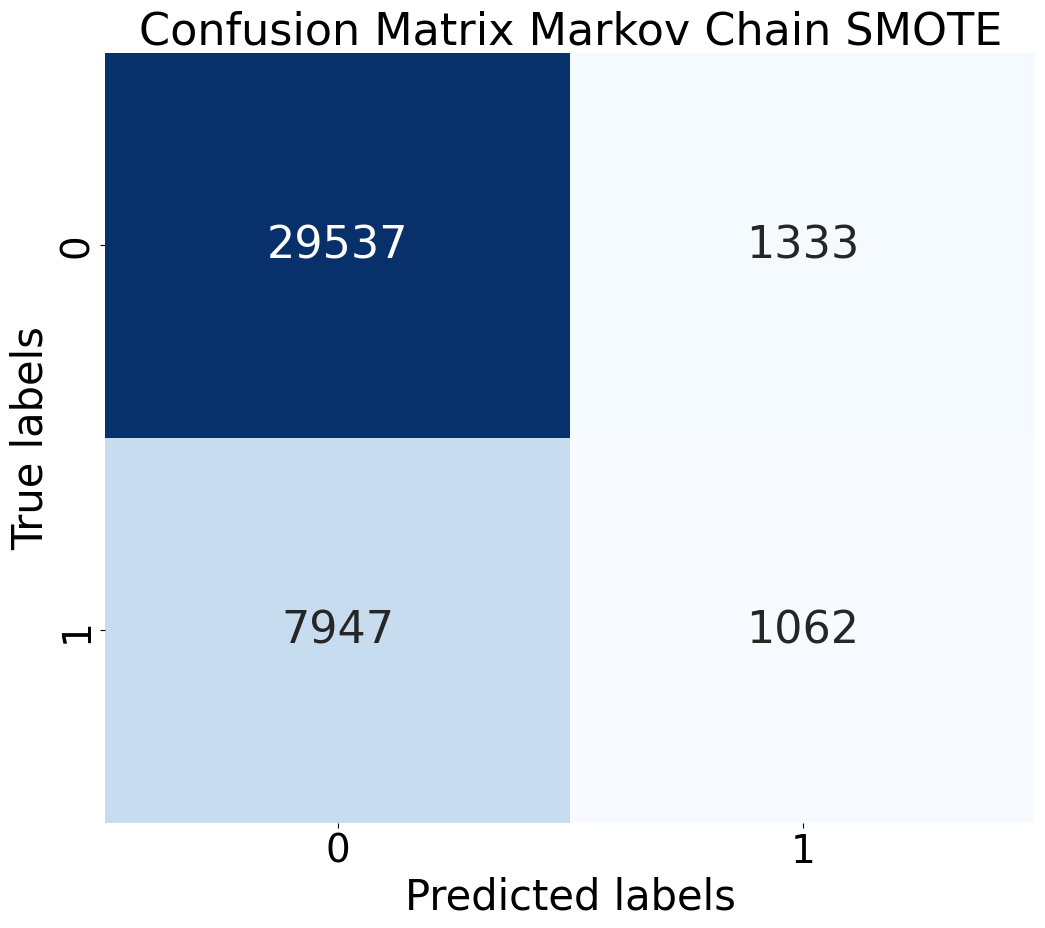

In [37]:
conf_matrix = confusion_matrix(true_labels, predicted_labels_mv_ovs)

# Plot confusion matrix
plt.figure(figsize=(12, 10))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False, annot_kws={"size": 32})
plt.xlabel('Predicted labels', fontsize=30)
plt.ylabel('True labels', fontsize=30)
plt.title('Confusion Matrix Markov Chain SMOTE', fontsize=32)
plt.xticks(fontsize=28)
plt.yticks(fontsize=28)
plt.savefig('Confusion_Matrix_MV_SMOTE.pdf', format='pdf')
plt.show()

### GRU

In [ ]:
sequences_train = X_train['session'].tolist()
sequences_test = X_test['session'].tolist()
sequences_train = [[int(num) for num in item.strip("[]").split(', ')] for item in sequences_train]
sequences_test = [[int(num) for num in item.strip("[]").split(', ')] for item in sequences_test]

# Pad sequences to a fixed length
max_length = 30
padded_sequences_train = pad_sequences(sequences_train, maxlen= max_length, padding='post', truncating='post')
padded_sequences_test = pad_sequences(sequences_test, maxlen= max_length, padding='post', truncating='post')

# Convert padded sequences to NumPy array
sequences_train = np.array(padded_sequences_train)
labels_train = np.array(y_train)
sequences_test = np.array(padded_sequences_test)
labels_test = np.array(y_test)

In [ ]:
# Split the data into train, validation, and test sets
X_train, X_val, y_train, y_val = train_test_split(sequences_train, labels_train, test_size=0.25, random_state=42)  # 0.25 x 0.8 = 0.2

# Reshape the input data to match the expected input shape of the GRU layer
X_train_reshaped = np.expand_dims(X_train, axis=-1)
X_val_reshaped = np.expand_dims(X_val, axis=-1)

In [ ]:
print("Class distribution before oversampling:", Counter(labels_train))
# transform the dataset
oversample = SMOTE(sampling_strategy = 'minority', k_neighbors = 3)

padded_sequences_train_res, labels_train_res = oversample.fit_resample(X_train, y_train)
# Print the distribution of classes after oversampling
print("Class distribution after oversampling:", Counter(labels_train_res))

Class distribution before oversampling: Counter({0.0: 123059, 1.0: 36434})
Class distribution after oversampling: Counter({0.0: 92300, 1.0: 92300})


In [ ]:
# Reshape the input data to match the expected input shape of the GRU layer
X_train_reshaped = np.expand_dims(padded_sequences_train_res, axis=-1)
X_val_reshaped = np.expand_dims(X_val, axis=-1)

t-SNE

In [ ]:
# Get the total number of instances
total_instances = len(padded_sequences_train_res)
sample_size = 10000

# Generate random indices for sampling
random_indices = np.random.choice(total_instances, sample_size, replace=False)

# Sample sessions and labels using the random indices
sampled_sessions = padded_sequences_train_res[random_indices]
sampled_labels = labels_train_res[random_indices]

In [ ]:
tsne = TSNE(perplexity=30, learning_rate=200)

# Fit and transform the data to reduce dimensionality
X_embedded = tsne.fit_transform(sampled_sessions)

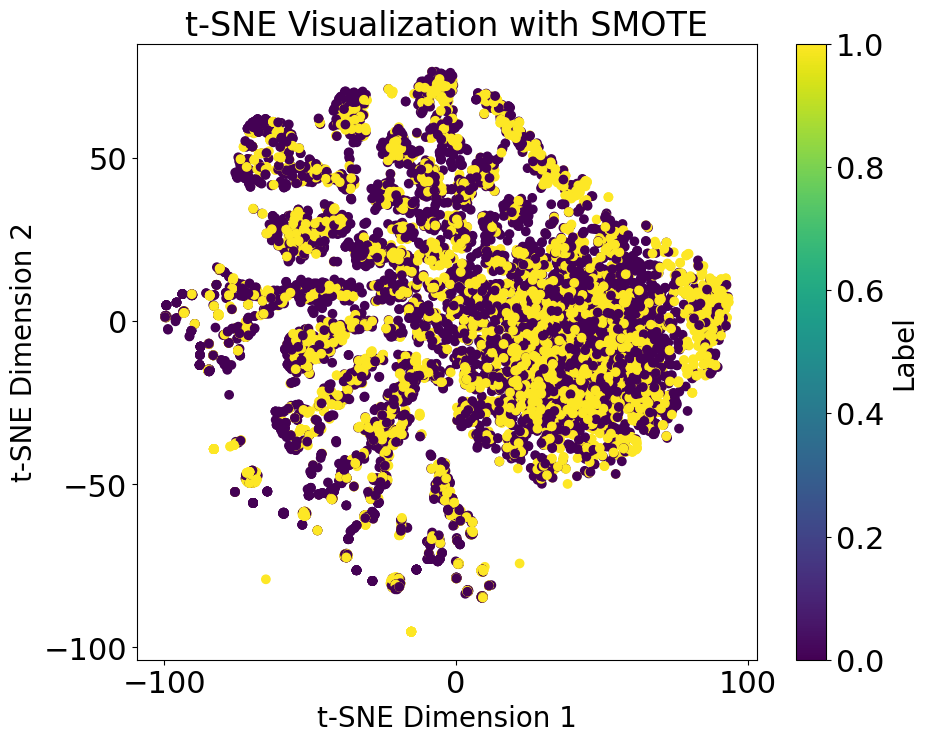

In [ ]:
# Plot the embedded data
plt.figure(figsize=(10, 8))
scatter = plt.scatter(X_embedded[:, 0], X_embedded[:, 1], marker='o', c=sampled_labels)
plt.title('t-SNE Visualization with SMOTE', fontsize=24)  # Increase title font size
plt.xlabel('t-SNE Dimension 1', fontsize=20)  # Increase x-axis label font size
plt.ylabel('t-SNE Dimension 2', fontsize=20)  # Increase y-axis label font size
plt.xticks(fontsize=22)  # Increase x-axis tick font size
plt.yticks(fontsize=22)  # Increase y-axis tick font size

# Create a colorbar with increased font size
cbar = plt.colorbar(scatter)
cbar.set_label('Label', fontsize=20)  # Set colorbar label font size
cbar.ax.tick_params(labelsize=22)  # Set colorbar tick label font size

# Save the plot to a PDF file
plt.savefig('t_SNE_with_SMOTE.pdf', format='pdf')
plt.show()

In [ ]:
model_GRU_ovs = Sequential([
    GRU(32, input_shape=(None, 1)),
    Dropout(0.25),
    Dense(32, activation='relu'),
    Dense(1, activation='sigmoid')
])

# Compile the model with Adam optimizer and a lower learning rate
optimizer = Adam(learning_rate=0.001)
model_GRU_ovs.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
history = model_GRU_ovs.fit(X_train_reshaped, labels_train_res, epochs=10, batch_size=64, validation_data=(X_val_reshaped, y_val))

Epoch 1/10
2885/2885 [==============================] - 26s 8ms/step - loss: 0.6257 - accuracy: 0.6118 - val_loss: 0.5427 - val_accuracy: 0.6674
Epoch 2/10
2885/2885 [==============================] - 21s 7ms/step - loss: 0.5191 - accuracy: 0.7339 - val_loss: 0.5466 - val_accuracy: 0.6646
Epoch 3/10
2885/2885 [==============================] - 25s 9ms/step - loss: 0.5052 - accuracy: 0.7438 - val_loss: 0.5491 - val_accuracy: 0.6678
Epoch 4/10
2885/2885 [==============================] - 18s 6ms/step - loss: 0.4986 - accuracy: 0.7488 - val_loss: 0.5441 - val_accuracy: 0.6754
Epoch 5/10
2885/2885 [==============================] - 25s 9ms/step - loss: 0.4927 - accuracy: 0.7522 - val_loss: 0.5243 - val_accuracy: 0.6892
Epoch 6/10
2885/2885 [==============================] - 18s 6ms/step - loss: 0.4888 - accuracy: 0.7546 - val_loss: 0.5197 - val_accuracy: 0.6940
Epoch 7/10
2885/2885 [==============================] - 17s 6ms/step - loss: 0.4852 - accuracy: 0.7563 - val_loss: 0.5255 - val_ac

In [ ]:
model_save_name = 'model_GRU_ovs.h5'
path = "/content/drive/MyDrive/Thesis/Models/" + model_save_name
model_GRU_ovs.save(path)

In [ ]:
# Load the model from the saved HDF5 file
model_save_name = 'model_GRU_ovs.h5'
path = "/content/drive/MyDrive/Thesis/Models/" + model_save_name
model_GRU_ovs = load_model(path)

In [ ]:
# Predict labels for the test set
y_pred = model_GRU_ovs.predict(X_train_reshaped)
y_pred_binary = (y_pred > 0.4).astype(int)  # Convert probabilities to binary predictions

# Calculate the F1 score
f1 = f1_score(labels_train_res, y_pred_binary)

print("F1 Score:", f1)

5769/5769 [==============================] - 41s 7ms/step
F1 Score: 0.7884953965623284


In [ ]:
# Predict labels for the test set
y_pred = model_GRU_ovs.predict(X_val_reshaped)
y_pred_binary = (y_pred > 0.4).astype(int)  # Convert probabilities to binary predictions

# Calculate the F1 score
f1 = f1_score(y_val, y_pred_binary)

print("F1 Score:", f1)

1247/1247 [==============================] - 9s 7ms/step
F1 Score: 0.5138922697082449


In [ ]:
# Predict labels for the test set
y_pred = model_GRU_ovs.predict(padded_sequences_test)
y_pred_binary_GRU_ovs = (y_pred > 0.4).astype(int)  # Convert probabilities to binary predictions

# Calculate the F1 score
f1 = f1_score(y_test, y_pred_binary_GRU_ovs)

print("F1 Score:", f1)

1247/1247 [==============================] - 3s 2ms/step
F1 Score: 0.5162727557520276


In [ ]:
y_pred[12]

array([0.7410738], dtype=float32)

In [ ]:
# 1	batch size: 128;	Dropout: 0.00;	Learning Rate: 0.001 --> 0.51334 (Threshold = 0.36)
# 2	batch size: 128;	Dropout: 0.25;	Learning Rate: 0.001 --> 0.51335 (Threshold = 0.40)

# 3	batch size: 64;	Dropout: 0.25;	Learning Rate: 0.001 --> 0.51627 (Threshold = 0.40)

# 4	batch size: 64;	Dropout: 0.50;	Learning Rate: 0.001 --> 0.50874 (Threshold = 0.46)
# 5	batch size: 128; 	Dropout:0.50; 	Learning Rate: 0.001 --> 0.50932 (Threshold = 0.40)

#### Hyperparameter Tuning

In [ ]:
import logging
import pandas as pd
from sklearn.metrics import f1_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dropout, Dense
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from kerastuner import HyperParameters
from kerastuner.tuners import GridSearch

# Suppress TensorFlow logging
logging.getLogger('tensorflow').setLevel(logging.ERROR)

# Define a function to build the model
def build_model(hp):
    model = Sequential()
    model.add(GRU(units=32, input_shape=(None, 1)))
    model.add(Dropout(rate=hp.Float('dropout', min_value=0.0, max_value=0.5, step=0.25)))
    model.add(Dense(units=32, activation="relu"))
    model.add(Dense(1, activation="sigmoid"))
    learning_rate = hp.Choice("learning_rate", [0.001, 0.01])
    batch_size = hp.Choice("batch_size", [128, 64, 32])
    optimizer = Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
    return model

# Initialize a GridSearch tuner
tuner = GridSearch(
    build_model,
    objective='val_loss')

# Perform the search
tuner.search(X_train_reshaped, labels_train_res, epochs=10, validation_data=(X_val_reshaped, y_val))

# Get the best hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
print("Best Hyperparameters:")
print(best_hps.values)

Trial 18 Complete [00h 06m 24s]
val_loss: 0.5174962282180786

Best val_loss So Far: 0.4959281384944916
Total elapsed time: 01h 53m 21s
Best Hyperparameters:
{'dropout': 0.0, 'learning_rate': 0.001, 'batch_size': 128}


In [ ]:
hyperparameters_data = []
for trial in tuner.oracle.get_best_trials(num_trials=len(tuner.oracle.trials)):
    hyperparameters = trial.hyperparameters.values
    val_loss = trial.score
    hyperparameters_data.append({
        'Batch Size': hyperparameters['batch_size'],
        'Dropout': hyperparameters['dropout'],
        'Learning Rate': hyperparameters['learning_rate'],
        'Validation Loss': val_loss
    })

# Create DataFrame
df_results_GRU_ovs = pd.DataFrame(hyperparameters_data)

In [ ]:
df_results_GRU_ovs

Batch Size  Dropout  Learning Rate  Validation Loss
0          128     0.00          0.001         0.495928
1          128     0.25          0.001         0.497792
2           64     0.25          0.001         0.499961
3           64     0.50          0.001         0.501572
4          128     0.50          0.001         0.502043
5           32     0.50          0.001         0.502931
6           32     0.25          0.001         0.503379
7           64     0.25          0.010         0.505081
8           32     0.00          0.001         0.512470
9           32     0.50          0.010         0.517496
10          64     0.00          0.001         0.518464
11          64     0.00          0.010         0.520500
12          32     0.25          0.010         0.521368
13         128     0.00          0.010         0.661204
14          64     0.50          0.010         0.669875
15         128     0.25          0.010         0.679952
16         128     0.50          0.010         0.680686
17          32     0.00          0.010         0.684429

In [ ]:
df_results_GRU_ovs.to_csv("/content/drive/MyDrive/Thesis/Datasets/df_results_GRU_ovs.csv", index = False)

In [ ]:
df_results_GRU_ovs = pd.read_csv("/content/drive/MyDrive/Thesis/Datasets/df_results_GRU_ovs.csv")

In [ ]:
results_df = df_results_GRU_ovs

In [ ]:
import plotly.graph_objects as go

def plot_parcoords(results_df):
    fig = go.Figure(data=
        go.Parcoords(
            line=dict(color=results_df['Validation Loss'], colorscale='Tealrose', showscale=True),
            dimensions=[
                dict(range=[min(results_df['Dropout']), max(results_df['Dropout'])],
                     label='Dropout', values=results_df['Dropout']),
                dict(range=[min(results_df['Batch Size']), max(results_df['Batch Size'])],
                     label='Batch Size', values=results_df['Batch Size']),
                dict(range=[min(results_df['Learning Rate']), max(results_df['Learning Rate'])],
                     label='Learning Rate', values=results_df['Learning Rate']),
                dict(range=[min(results_df['Validation Loss']), max(results_df['Validation Loss'])],
                     label='Validation Loss', values=results_df['Validation Loss'])
            ])
        )

    fig.show()

# Call the function with your dataframe
plot_parcoords(results_df)


In [ ]:
# Define hyperparameters and F1 scores
hyperparameters = ['Dropout Rate', 'Batch Size', 'Learning Rate']
vl_scores = ['Validation Loss']

# Create pairplot
fig = ff.create_scatterplotmatrix(
    results_df,
    diag='histogram',
    index='Validation Loss',
    colormap='Rainbow',
    colormap_type='seq',
    height=800,
    width=800
)

# Update layout
fig.update_layout(
    title='Pairplot of Hyperparameters vs Validation loss',
    xaxis=dict(title='Hyperparameters'),
    yaxis=dict(title='Hyperparameters')
)

fig.show()

In [ ]:
import plotly.graph_objects as go
import plotly.io as pio

# Create the contour plot
fig = go.Figure(data=go.Contour(
    x=results_df['Batch Size'],
    y=results_df['Learning Rate'],
    z=results_df['Validation Loss'],
    colorscale='Tealrose',  # Choose a colorscale
    colorbar=dict(
        title=dict(text='Validation Loss', font=dict(size=22)),
        thickness=50,  # Increase the thickness of the colorbar
        len=1.1,
        tickfont=dict(size=18)
    ),
))

# Update layout with increased font sizes
fig.update_layout(
    title=dict(text='Contour Plot of Hyperparameters GRU SMOTE', font=dict(size=22)),
    xaxis=dict(title=dict(text='Batch Size', font=dict(size=22)), tickfont=dict(size=18)),
    yaxis=dict(title=dict(text='Learning Rate', font=dict(size=22)), tickfont=dict(size=18))
)

fig.show()
pio.write_image(fig, 'hyperparameters_contour_plot_GRU_SMOTE.pdf')

#### Error Analysis

Brier Score: 0.19032967136524762


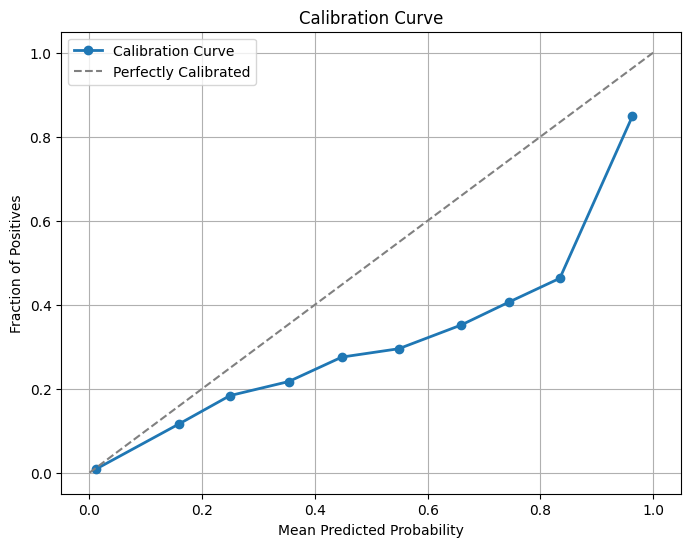

In [ ]:
prob_true, prob_pred = calibration_curve(y_test, y_pred, n_bins=10, strategy='uniform')

# Compute Brier score
brier_score = brier_score_loss(y_test, y_pred)
print("Brier Score:", brier_score)

# Plot calibration curve
plt.figure(figsize=(8, 6))
plt.plot(prob_pred, prob_true, marker='o', linewidth=2, label='Calibration Curve')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Perfectly Calibrated')
plt.xlabel('Mean Predicted Probability')
plt.ylabel('Fraction of Positives')
plt.title('Calibration Curve')
plt.legend()
plt.grid(True)
plt.show()

              precision    recall  f1-score   support

         0.0       0.91      0.60      0.73     30729
         1.0       0.38      0.81      0.52      9145

    accuracy                           0.65     39874
   macro avg       0.65      0.71      0.62     39874
weighted avg       0.79      0.65      0.68     39874



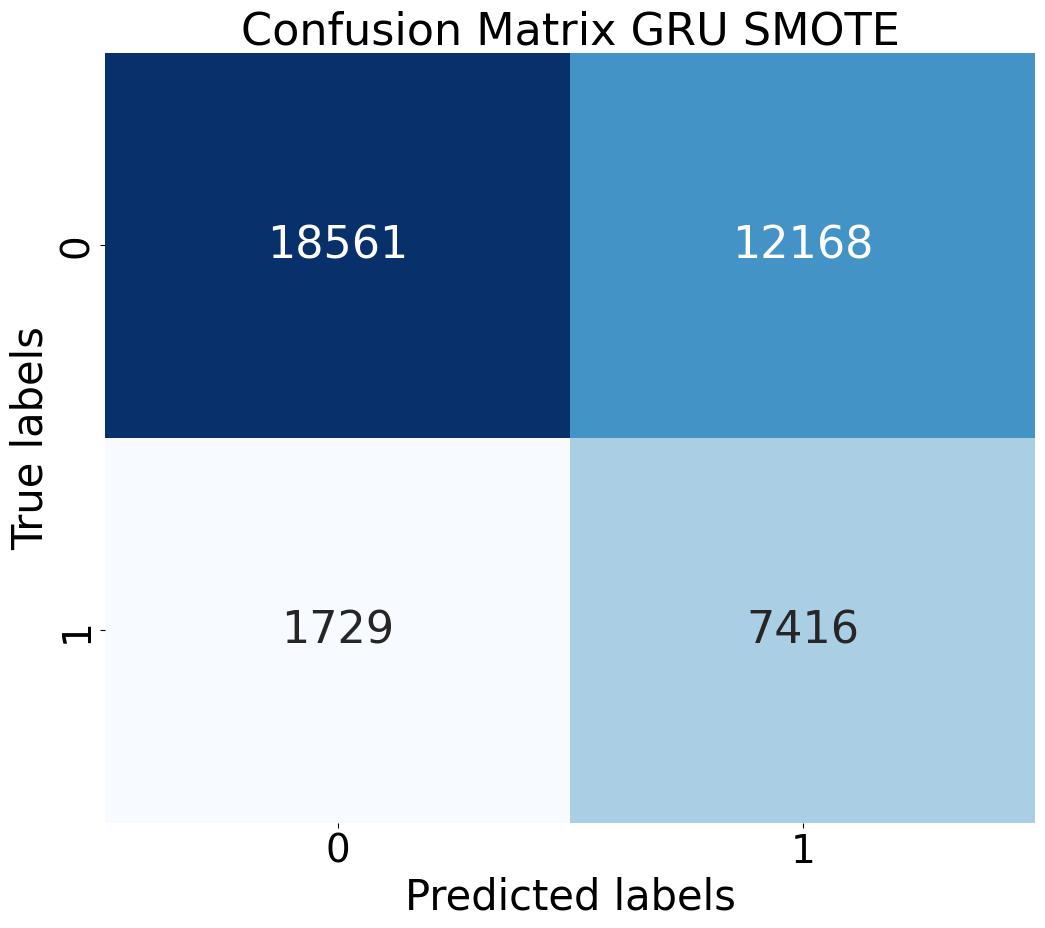

In [ ]:
# Compute confusion matrix and classification report for GRU SMOTE
conf_matrix = confusion_matrix(y_test, y_pred_binary_GRU_ovs)
cr_error = classification_report(y_test, y_pred_binary_GRU_ovs)
print(cr_error)

# Plot confusion matrix
plt.figure(figsize=(12, 10))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False, annot_kws={"size": 32})
plt.xlabel('Predicted labels', fontsize=30)
plt.ylabel('True labels', fontsize=30)
plt.title('Confusion Matrix GRU SMOTE', fontsize=32)
plt.xticks(fontsize=28)
plt.yticks(fontsize=28)
plt.savefig("Confusion_Matrix_GRU_SMOTE.pdf", format='pdf')
plt.show()

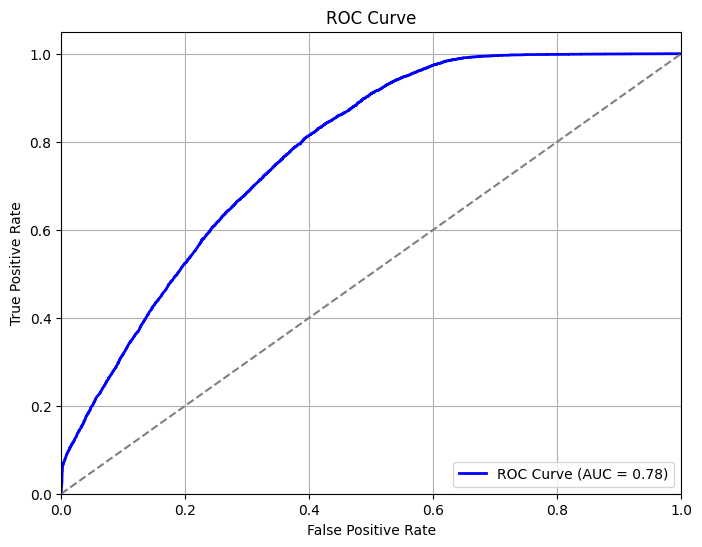

In [ ]:
# Compute ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred)

# Compute ROC-AUC score
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label='ROC Curve (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

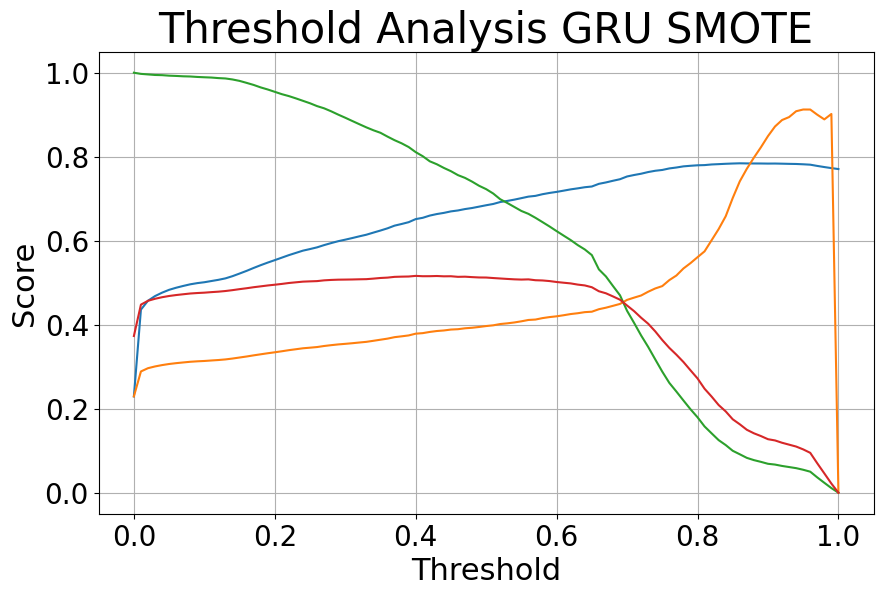

In [ ]:
thresholds = np.linspace(0, 1, 101)  # 100 thresholds from 0 to 1

# Initialize lists to store evaluation metrics
accuracy_scores = []
precision_scores = []
recall_scores = []
f1_scores = []

# Iterate over each threshold
for threshold in thresholds:
    # Convert probabilities to binary predictions based on the threshold
    y_pred_binary_GRU_ovs = np.where(y_pred > threshold, 1, 0)

    # Evaluate the model using the current threshold
    accuracy = accuracy_score(y_test, y_pred_binary_GRU_ovs)
    precision = precision_score(y_test, y_pred_binary_GRU_ovs)
    recall = recall_score(y_test, y_pred_binary_GRU_ovs)
    f1 = f1_score(y_test, y_pred_binary_GRU_ovs)

    # Append evaluation metrics to lists
    accuracy_scores.append(accuracy)
    precision_scores.append(precision)
    recall_scores.append(recall)
    f1_scores.append(f1)

# Plot the evaluation metrics against thresholds
plt.figure(figsize=(10, 6))

plt.plot(thresholds, accuracy_scores, label='Accuracy')
plt.plot(thresholds, precision_scores, label='Precision')
plt.plot(thresholds, recall_scores, label='Recall')
plt.plot(thresholds, f1_scores, label='F1 Score')

plt.xlabel('Threshold', fontsize=22)
plt.ylabel('Score', fontsize=22)
plt.title('Threshold Analysis GRU SMOTE', fontsize=30)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.grid(True)

plt.savefig("Threshold_Analysis_GRU_SMOTE.pdf")
plt.show()

In [ ]:
df_train_exp_error = X_test

In [ ]:
df_train_exp_error.head()

session_id_hash  \
139173  b2410d2c9a0f5c3e5674b7ecfb5072e9d8cfeed51a8527...   
25840   2101ff15b51412a2ca58b7e266f02670345310c259a115...   
25719   20db6a581ee197ecb7b819083d1e07713c59134301d66b...   
193479  f8666eda87b62d9ab550c7e9445ead5274b6acadebdfe2...   
50714   413508364819d4afd5d4d0246af8fb826f0ac8116b3817...   

                                                  session  session_length  \
139173  [1, 1, 1, 1, 1, 1, 2, 1, 1, 2, 1, 2, 1, 2, 3, ...            37.0   
25840   [1, 2, 1, 2, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 2, ...            21.0   
25719   [1, 1, 1, 1, 1, 2, 3, 1, 2, 1, 3, 1, 1, 1, 1, ...            20.0   
193479  [1, 2, 1, 1, 2, 1, 3, 1, 1, 1, 1, 1, 2, 1, 1, ...            27.0   
50714                         [1, 1, 2, 3, 1, 1, 1, 1, 1]             9.0   

        true  exp_pred  
139173   0.0         1  
25840    0.0         0  
25719    0.0         1  
193479   0.0         1  
50714    1.0         1

In [ ]:
df_train_exp_error['session_length'] = df_train_exp_error['session'].apply(lambda x: len(x)/3)
df_train_exp_error['true'] = y_test
df_train_exp_error['exp_pred'] = y_pred_binary

# Display the updated DataFrame
df_train_exp_error.head()

session_id_hash  \
139173  b2410d2c9a0f5c3e5674b7ecfb5072e9d8cfeed51a8527...   
25840   2101ff15b51412a2ca58b7e266f02670345310c259a115...   
25719   20db6a581ee197ecb7b819083d1e07713c59134301d66b...   
193479  f8666eda87b62d9ab550c7e9445ead5274b6acadebdfe2...   
50714   413508364819d4afd5d4d0246af8fb826f0ac8116b3817...   

                                                  session  session_length  \
139173  [1, 1, 1, 1, 1, 1, 2, 1, 1, 2, 1, 2, 1, 2, 3, ...            37.0   
25840   [1, 2, 1, 2, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 2, ...            21.0   
25719   [1, 1, 1, 1, 1, 2, 3, 1, 2, 1, 3, 1, 1, 1, 1, ...            20.0   
193479  [1, 2, 1, 1, 2, 1, 3, 1, 1, 1, 1, 1, 2, 1, 1, ...            27.0   
50714                         [1, 1, 2, 3, 1, 1, 1, 1, 1]             9.0   

        true  exp_pred  
139173   0.0         0  
25840    0.0         0  
25719    0.0         1  
193479   0.0         1  
50714    1.0         1

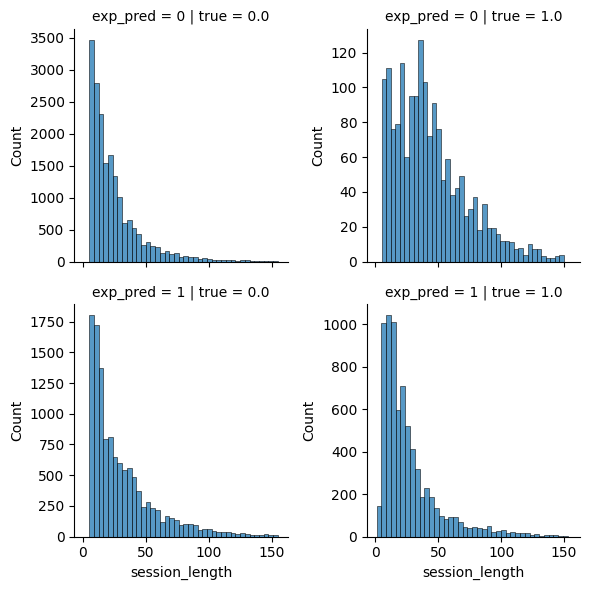

In [ ]:
g = sns.FacetGrid(df_train_exp_error, col = 'true', row = 'exp_pred', sharey=False)
g.map(sns.histplot, 'session_length', bins = 40)

In [ ]:
# Train the model
history = model_GRU_ovs.fit(X_train_reshaped, labels_train_res, epochs=10, batch_size=64, validation_data=(X_val_reshaped, y_val))

Epoch 1/10
2885/2885 [==============================] - 20s 6ms/step - loss: 0.4780 - accuracy: 0.7609 - val_loss: 0.5284 - val_accuracy: 0.6840
Epoch 2/10
2885/2885 [==============================] - 17s 6ms/step - loss: 0.4768 - accuracy: 0.7615 - val_loss: 0.5266 - val_accuracy: 0.6842
Epoch 3/10
2885/2885 [==============================] - 25s 9ms/step - loss: 0.4755 - accuracy: 0.7614 - val_loss: 0.5150 - val_accuracy: 0.6887
Epoch 4/10
2885/2885 [==============================] - 32s 11ms/step - loss: 0.4742 - accuracy: 0.7624 - val_loss: 0.5378 - val_accuracy: 0.6763
Epoch 5/10
2885/2885 [==============================] - 23s 8ms/step - loss: 0.4742 - accuracy: 0.7629 - val_loss: 0.5156 - val_accuracy: 0.6920
Epoch 6/10
2885/2885 [==============================] - 19s 6ms/step - loss: 0.4732 - accuracy: 0.7634 - val_loss: 0.5133 - val_accuracy: 0.6943
Epoch 7/10
2885/2885 [==============================] - 19s 6ms/step - loss: 0.4721 - accuracy: 0.7642 - val_loss: 0.5090 - val_a

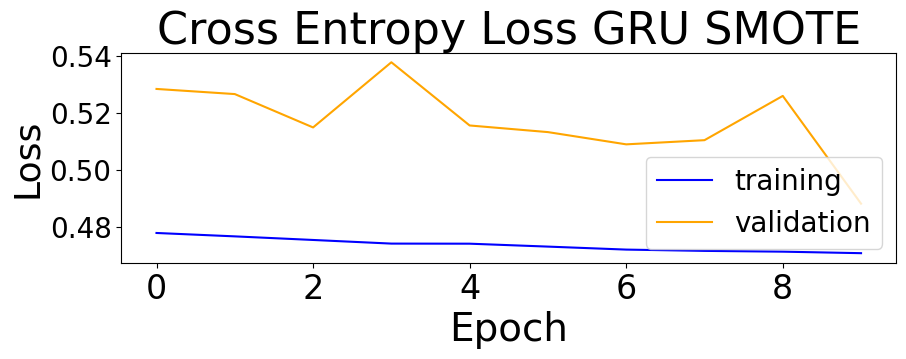

In [ ]:
# Plot Cross Entropy Loss for GRU SMOTE
plt.figure(figsize=(10, 6))
plt.subplot(211)
plt.title('Cross Entropy Loss GRU SMOTE', fontsize=32)
plt.plot(history.history['loss'], color='blue', label='train')
plt.plot(history.history['val_loss'], color='orange', label='test')
plt.legend(['training', 'validation'], fontsize=20)
plt.xlabel('Epoch', fontsize=28)
plt.ylabel('Loss', fontsize=26)
plt.xticks(fontsize=24)
plt.yticks(fontsize=20)
plt.savefig('Cross_Entropy_Loss_GRU_SMOTE.pdf', format='pdf')
plt.show()

#### SHAP

##### Kmeans

In [ ]:
np.random.seed(42)

sample_size = 200
sample_indices = np.random.choice(len(padded_sequences_test), size=sample_size, replace=False)
subset_X_test_reshaped = padded_sequences_test[sample_indices]

In [ ]:
# Summarize the background data using k-means
background_summary = shap.kmeans(subset_X_test_reshaped, 5)  # You can adjust the number of clusters (K) as needed

# Create an explainer using the Kernel SHAP method with the summarized background data
kernel_explainer = shap.KernelExplainer(model_GRU_ovs.predict, background_summary)

# Compute SHAP values for the test data
shap_values_test_kernel_GRU_ovs = kernel_explainer.shap_values(subset_X_test_reshaped)

1/1 [==============================] - 1s 669ms/step


  0%|          | 0/200 [00:00<?, ?it/s]

330/330 [==============================] - 1s 2ms/step


In [ ]:
np.save('/content/drive/My Drive/Thesis/Datasets/shap_values_test_kernel_GRU_ovs.npy', shap_values_test_kernel_GRU_ovs)

In [ ]:
file_path = '/content/drive/My Drive/Thesis/Datasets/shap_values_test_kernel_GRU_ovs.npy'
shap_values_test_kernel_GRU_ovs = np.load(file_path)

In [ ]:
# Define feature names based on the time steps in the sequence
# TS = Time Step
feature_names = [f"TS {i+1}" for i in range(subset_X_test_reshaped.shape[1])]

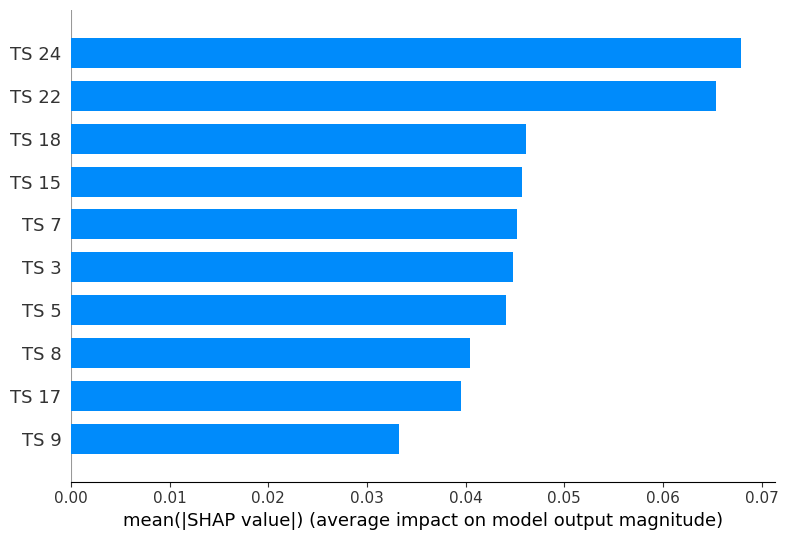

In [ ]:
# Reshape the SHAP values matrix to match the shape of the features matrix
shap_values_test_kernel_GRU_ovs_reshaped = shap_values_test_kernel_GRU_ovs.reshape(shap_values_test_kernel_GRU_ovs.shape[0], shap_values_test_kernel_GRU_ovs.shape[1], -1)

# Aggregate SHAP values across all features
shap_values_aggregated = np.mean(shap_values_test_kernel_GRU_ovs, axis=2)

# Get the mean absolute SHAP values for each feature
mean_abs_shap_values = np.mean(np.abs(shap_values_aggregated), axis=0)

# Sort the features based on their mean absolute SHAP values
sorted_indices = np.argsort(mean_abs_shap_values)[::-1]

# Select only the top ten features
top_ten_indices_GRU_SMOTE = sorted_indices[:10]
top_ten_features = subset_X_test_reshaped[:, top_ten_indices_GRU_SMOTE]
top_ten_feature_names = [feature_names[i] for i in top_ten_indices_GRU_SMOTE]

# Plot the aggregated SHAP values for the top ten features
shap.summary_plot(shap_values_aggregated[:, top_ten_indices_GRU_SMOTE], features=top_ten_features, feature_names=top_ten_feature_names , plot_type='bar')

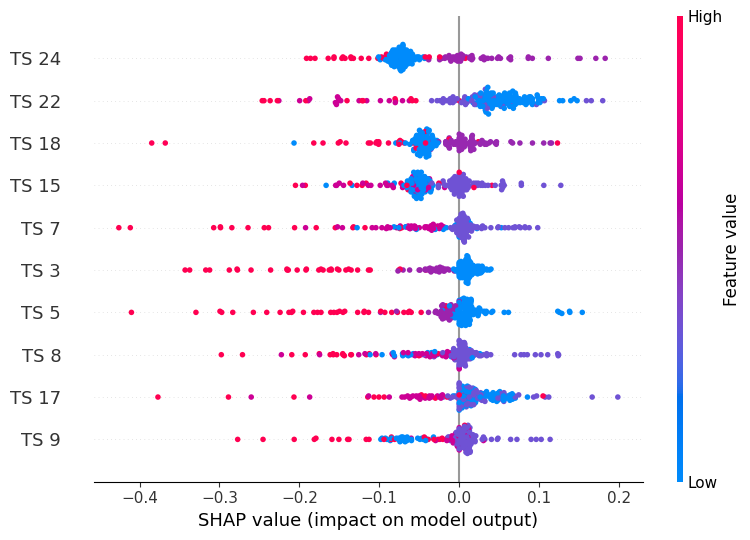

In [ ]:
shap.summary_plot(shap_values_aggregated[:, top_ten_indices_GRU_SMOTE], features=top_ten_features, feature_names=top_ten_feature_names)

In [ ]:
# Summarize the background data using k-means
background_summary = shap.kmeans(subset_X_test_reshaped, 5)  # You can adjust the number of clusters (K) as needed

# Create an explainer using the Kernel SHAP method with the summarized background data
kernel_explainer = shap.KernelExplainer(model_GRU_ovs.predict, background_summary)

1/1 [==============================] - 0s 81ms/step


In [ ]:
# Convert to numpy array using to_numpy()
y_array_np = y_test.to_numpy()
y_test_samples = y_array_np[sample_indices]

In [ ]:
y_test_samples[10]

0.0

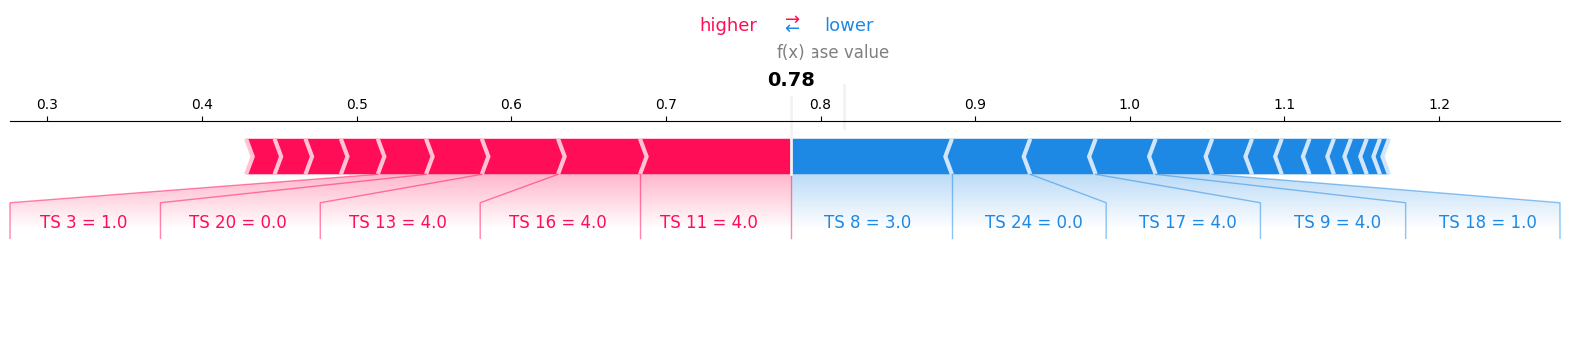

In [ ]:
# Choose an instance to explain (e.g., the first instance)
instance_index = 10

# Generate force plot for the chosen instance
shap.force_plot(kernel_explainer.expected_value, shap_values_test_kernel_GRU_ovs[instance_index][:, 0], subset_X_test_reshaped[instance_index], matplotlib=True, feature_names= feature_names)

1247/1247 [==============================] - 5s 4ms/step


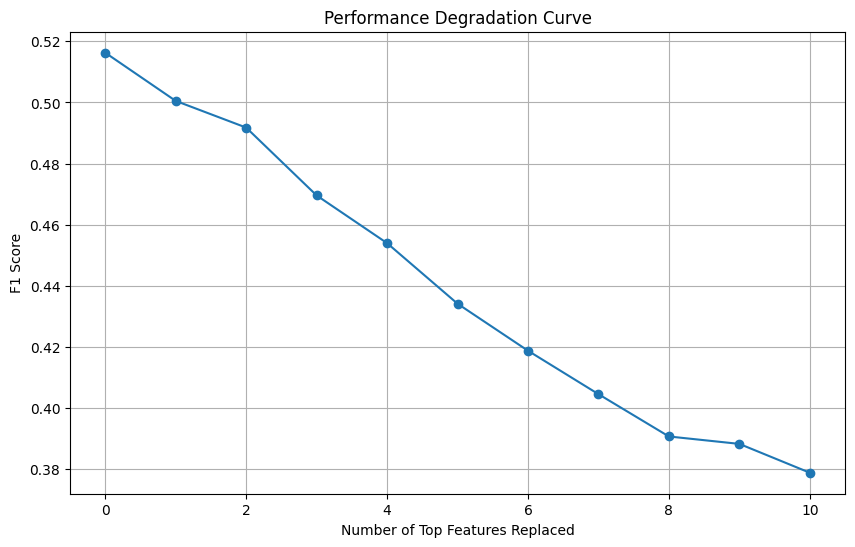

In [ ]:
# Create a copy of the test data to modify
modified_test_set = np.array(padded_sequences_test)

# Store original F1 score with unmodified data
original_pred = model_GRU_ovs.predict(padded_sequences_test)
original_f1 = f1_score(y_test, (original_pred > 0.4).astype(int))

# Initialize a list to store F1 scores after each feature modification
f1_scores_GRU_SMOTE = [original_f1]

# Replace each top feature with the majority value found in that feature
for i, feature_idx in enumerate(top_ten_indices_GRU_SMOTE):
    # Find the majority class for the current feature across all test data
    majority_value = np.bincount(modified_test_set[:, feature_idx]).argmax()

    # Replace this feature in all test samples with the majority class
    modified_test_set[:, feature_idx] = majority_value

    # Evaluate the model with the modified test set
    new_predictions = model_GRU_ovs.predict(modified_test_set)
    new_f1 = f1_score(y_test, (new_predictions > 0.4).astype(int))

    # Append the new F1 score
    f1_scores_GRU_SMOTE.append(new_f1)

# Plot the performance degradation curve
plt.figure(figsize=(10, 6))
plt.plot(range(len(f1_scores_GRU_SMOTE)), f1_scores_GRU_SMOTE, marker='o')
plt.title('Performance Degradation Curve')
plt.xlabel('Number of Top Features Replaced')
plt.ylabel('F1 Score')
plt.grid(True)

##### Both classes

In [ ]:
# Filter the dataset for "cart abandonment" sessions (target = 0)
cart_abandonment_sessions = df_train[df_train["conversion"] == 0][["session_id_hash", "session"]]
sequences_train_ca = cart_abandonment_sessions['session'].tolist()
sequences_train_ca = [[int(num) for num in item.strip("[]").split(', ')] for item in sequences_train_ca]
max_length = 30  # Choose the maximum length you want
padded_sequences_ca = pad_sequences(sequences_train_ca, maxlen= max_length, padding='post', truncating='post')

# Filter the dataset for "purchase" sessions (target = 1)
purchase_sessions = df_train[df_train["conversion"] == 1][["session_id_hash", "session"]]
sequences_train_pu = purchase_sessions['session'].tolist()
sequences_train_pu = [[int(num) for num in item.strip("[]").split(', ')] for item in sequences_train_pu]
max_length = 30  # Choose the maximum length you want
padded_sequences_pu = pad_sequences(sequences_train_pu, maxlen= max_length, padding='post', truncating='post')

In [ ]:
# Set a fixed random seed
np.random.seed(42)

sample_size = 100
sample_indices = np.random.choice(len(padded_sequences_ca), size=sample_size, replace=False)
subset_X_test_reshaped_ca = padded_sequences_ca[sample_indices]

sample_indices = np.random.choice(len(padded_sequences_pu), size=sample_size, replace=False)
subset_X_test_reshaped_pu = padded_sequences_pu[sample_indices]

In [ ]:
# Summarize the background data using k-means
background_summary = shap.kmeans(subset_X_test_reshaped_ca, 5)  # You can adjust the number of clusters (K) as needed

# Create an explainer using the Kernel SHAP method with the summarized background data
kernel_explainer = shap.KernelExplainer(model_GRU_ovs.predict, background_summary)

# Compute SHAP values for the test data
shap_values_class0 = kernel_explainer.shap_values(subset_X_test_reshaped_ca)

1/1 [==============================] - 0s 396ms/step


  0%|          | 0/100 [00:00<?, ?it/s]

330/330 [==============================] - 1s 2ms/step


In [ ]:
# Summarize the background data using k-means
background_summary = shap.kmeans(subset_X_test_reshaped_pu, 5)  # You can adjust the number of clusters (K) as needed

# Create an explainer using the Kernel SHAP method with the summarized background data
kernel_explainer = shap.KernelExplainer(model_GRU_ovs.predict, background_summary)

# Compute SHAP values for the test data
shap_values_class1 = kernel_explainer.shap_values(subset_X_test_reshaped_pu)

1/1 [==============================] - 0s 20ms/step


  0%|          | 0/100 [00:00<?, ?it/s]

329/329 [==============================] - 1s 2ms/step


In [ ]:
# Define feature names based on the time steps in the sequence
# TS = Time Step
feature_names = [f"TS {i+1}" for i in range(subset_X_test_reshaped_ca.shape[1])]

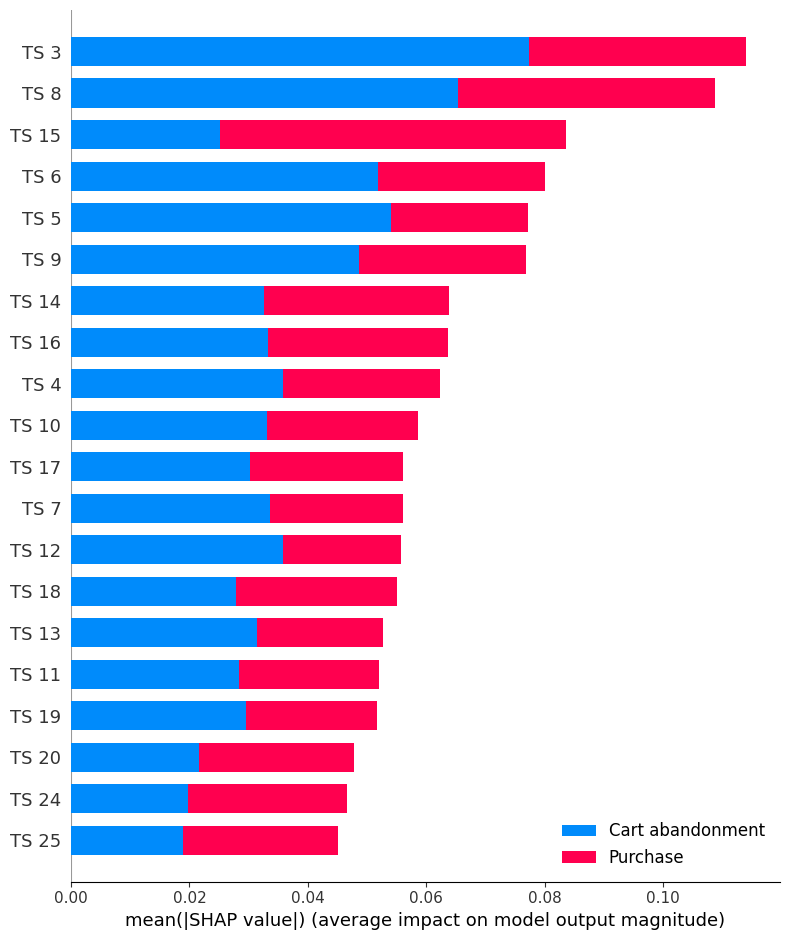

In [ ]:
# Reshape the SHAP values matrix to match the shape of the features matrix for each class
shap_values_class0_reshaped = shap_values_class0.reshape(shap_values_class0.shape[0], shap_values_class0.shape[1], -1)
shap_values_class1_reshaped = shap_values_class1.reshape(shap_values_class1.shape[0], shap_values_class1.shape[1], -1)

# Aggregate SHAP values across all features for each class
shap_values_class0_aggregated = np.mean(shap_values_class0, axis=2)
shap_values_class1_aggregated = np.mean(shap_values_class1, axis=2)

# Create a matplotlib figure and axis
fig, ax = plt.subplots()

# Plot the aggregated SHAP values for the top ten features for both classes in one summary plot
shap.summary_plot([shap_values_class0_aggregated, shap_values_class1_aggregated],
                  feature_names=feature_names,
                  plot_type='bar',
                  class_names=['Cart abandonment', 'Purchase'],
                  show=False)  # Prevents immediate showing of the plot

# Save the figure as a PDF
plt.savefig('shap_summary_plot_GRU_SMOTE.pdf', bbox_inches='tight')  # Save as PDF

# If you want to display the plot as well, uncomment the next line
# plt.show()

### LSTM

In [ ]:
print("Class distribution before oversampling:", Counter(labels_train))
# transform the dataset
oversample = SMOTE(sampling_strategy = 'minority', k_neighbors = 3)

padded_sequences_train_res, labels_train_res = oversample.fit_resample(X_train, y_train)
# Print the distribution of classes after oversampling
print("Class distribution after oversampling:", Counter(labels_train_res))

Class distribution before oversampling: Counter({0.0: 123059, 1.0: 36434})
Class distribution after oversampling: Counter({0.0: 92300, 1.0: 92300})


In [ ]:
# Reshape the input data to match the expected input shape of the GRU layer
X_train_reshaped = np.expand_dims(padded_sequences_train_res, axis=-1)
X_val_reshaped = np.expand_dims(X_val, axis=-1)

In [ ]:
model_LSTM_ovs = Sequential([
    LSTM(32, input_shape=(None, 1)),
    Dropout(0.25),
    Dense(32, activation='relu'),
    Dense(1, activation='sigmoid')
])

# Compile the model with Adam optimizer and a lower learning rate
optimizer = Adam(learning_rate=0.01)
model_LSTM_ovs.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
history = model_LSTM_ovs.fit(X_train_reshaped, labels_train_res, epochs=10, batch_size=32, validation_data=(X_val_reshaped, y_val))

Epoch 1/10
5769/5769 [==============================] - 46s 7ms/step - loss: 0.6916 - accuracy: 0.5128 - val_loss: 0.6900 - val_accuracy: 0.7505
Epoch 2/10
5769/5769 [==============================] - 37s 6ms/step - loss: 0.6880 - accuracy: 0.5215 - val_loss: 0.6645 - val_accuracy: 0.6637
Epoch 3/10
5769/5769 [==============================] - 37s 6ms/step - loss: 0.6854 - accuracy: 0.5209 - val_loss: 0.6989 - val_accuracy: 0.2286
Epoch 4/10
5769/5769 [==============================] - 38s 7ms/step - loss: 0.6843 - accuracy: 0.5193 - val_loss: 0.6514 - val_accuracy: 0.7786
Epoch 5/10
5769/5769 [==============================] - 38s 7ms/step - loss: 0.6841 - accuracy: 0.5192 - val_loss: 0.6866 - val_accuracy: 0.7671
Epoch 6/10
5769/5769 [==============================] - 37s 6ms/step - loss: 0.6332 - accuracy: 0.5984 - val_loss: 0.5716 - val_accuracy: 0.6356
Epoch 7/10
5769/5769 [==============================] - 37s 6ms/step - loss: 0.5225 - accuracy: 0.7281 - val_loss: 0.5345 - val_ac

In [ ]:
model_save_name = 'model_LSTM_ovs.h5'
path = "/content/drive/MyDrive/Thesis/Models/" + model_save_name
model_LSTM_ovs.save(path)

In [68]:
# Load the model from the saved HDF5 file
model_save_name = 'model_LSTM_ovs.h5'
path = "/content/drive/MyDrive/Thesis/Models/" + model_save_name
model_LSTM_ovs = load_model(path)

In [ ]:
# Predict labels for the test set
y_pred = model_LSTM_ovs.predict(X_train_reshaped)
y_pred_binary = (y_pred > 0.45).astype(int)  # Convert probabilities to binary predictions

# Calculate the F1 score
f1 = f1_score(labels_train_res, y_pred_binary)

print("F1 Score:", f1)

5769/5769 [==============================] - 41s 7ms/step
F1 Score: 0.7893120020883736


In [ ]:
# Predict labels for the test set
y_pred = model_LSTM_ovs.predict(X_val_reshaped)
y_pred_binary = (y_pred > 0.45).astype(int)  # Convert probabilities to binary predictions

# Calculate the F1 score
f1 = f1_score(y_val, y_pred_binary)

print("F1 Score:", f1)

1247/1247 [==============================] - 7s 6ms/step
F1 Score: 0.5162571017865699


In [ ]:
# Predict labels for the test set
y_pred = model_LSTM_ovs.predict(padded_sequences_test)
y_pred_binary_LSTM_ovs = (y_pred > 0.45).astype(int)  # Convert probabilities to binary predictions

# Calculate the F1 score
f1 = f1_score(y_test, y_pred_binary_LSTM_ovs)

print("F1 Score:", f1)

1247/1247 [==============================] - 5s 4ms/step
F1 Score: 0.51681148469966


In [ ]:
# 1	batch size: 128;	Dropout: 0.25;	Learning Rate: 0.010 --> 0.51681 (Threshold = 0.45)


# 2	batch size: 32;	Dropout: 0.50;	Learning Rate: 0.010 --> 0.50809 (Threshold = 0.52)
# 3	batch size: 32;	Dropout: 0.25;	Learning Rate: 0.010 --> 0.49850 (Threshold = 0.52)
# 4	batch size: 64;	Dropout: 0.00;	Learning Rate: 0.001 --> 0.51618 (Threshold = 0.52)
# 5	batch size: 32; 	Dropout:0.50; 	Learning Rate: 0.001 --> 0.51255 (Threshold = 0.44)

#### Hyperparameter Tuning

In [ ]:
import logging
import pandas as pd
from sklearn.metrics import f1_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dropout, Dense
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from kerastuner import HyperParameters
from kerastuner.tuners import GridSearch

# Suppress TensorFlow logging
logging.getLogger('tensorflow').setLevel(logging.ERROR)

# Define a function to build the model
def build_model(hp):
    model = Sequential()
    model.add(LSTM(units=32, input_shape=(None, 1)))
    model.add(Dropout(rate=hp.Float('dropout', min_value=0.0, max_value=0.5, step=0.25)))
    model.add(Dense(units=32, activation="relu"))
    model.add(Dense(1, activation="sigmoid"))
    learning_rate = hp.Choice("learning_rate", [0.001, 0.01])
    batch_size = hp.Choice("batch_size", [128, 64, 32])
    optimizer = Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
    return model

# Initialize a GridSearch tuner
tuner = GridSearch(
    build_model,
    objective='val_loss')

# Perform the search
tuner.search(X_train_reshaped, labels_train_res, epochs=10, validation_data=(X_val_reshaped, y_val))

# Get the best hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
print("Best Hyperparameters:")
print(best_hps.values)

Reloading Tuner from ./untitled_project/tuner0.json
Best Hyperparameters:
{'dropout': 0.25, 'learning_rate': 0.01, 'batch_size': 128}


In [ ]:
hyperparameters_data = []
for trial in tuner.oracle.get_best_trials(num_trials=len(tuner.oracle.trials)):
    hyperparameters = trial.hyperparameters.values
    val_loss = trial.score
    hyperparameters_data.append({
        'Batch Size': hyperparameters['batch_size'],
        'Dropout': hyperparameters['dropout'],
        'Learning Rate': hyperparameters['learning_rate'],
        'Validation Loss': val_loss
    })

# Create DataFrame
df_results_LSTM_ovs = pd.DataFrame(hyperparameters_data)

In [ ]:
df_results_LSTM_ovs

Batch Size  Dropout  Learning Rate  Validation Loss
0          128     0.25          0.010         0.474329
1           32     0.50          0.010         0.499044
2           32     0.25          0.010         0.501144
3           64     0.00          0.001         0.501315
4           32     0.50          0.001         0.503410
5          128     0.50          0.001         0.510190
6          128     0.25          0.001         0.511468
7          128     0.00          0.001         0.515720
8           64     0.50          0.001         0.516541
9           64     0.00          0.010         0.517721
10          32     0.00          0.001         0.518640
11          64     0.25          0.010         0.520307
12          64     0.25          0.001         0.520359
13          32     0.25          0.001         0.521354
14         128     0.50          0.010         0.662103
15          64     0.50          0.010         0.671979
16          32     0.00          0.010         0.672393
17         128     0.00          0.010         0.681874

In [ ]:
df_results_LSTM_ovs.to_csv("/content/drive/MyDrive/Thesis/Datasets/df_results_LSTM_ovs.csv", index = False)

In [ ]:
df_results_LSTM_ovs = pd.read_csv("/content/drive/MyDrive/Thesis/Datasets/df_results_LSTM_ovs.csv")

In [ ]:
results_df = df_results_LSTM_ovs

In [ ]:
import plotly.graph_objects as go

def plot_parcoords(results_df):
    fig = go.Figure(data=
        go.Parcoords(
            line=dict(color=results_df['Validation Loss'], colorscale='Tealrose', showscale=True),
            dimensions=[
                dict(range=[min(results_df['Dropout']), max(results_df['Dropout'])],
                     label='Dropout', values=results_df['Dropout']),
                dict(range=[min(results_df['Batch Size']), max(results_df['Batch Size'])],
                     label='Batch Size', values=results_df['Batch Size']),
                dict(range=[min(results_df['Learning Rate']), max(results_df['Learning Rate'])],
                     label='Learning Rate', values=results_df['Learning Rate']),
                dict(range=[min(results_df['Validation Loss']), max(results_df['Validation Loss'])],
                     label='Validation Loss', values=results_df['Validation Loss'])
            ])
        )

    fig.show()

# Call the function with your dataframe
plot_parcoords(results_df)


In [ ]:
# Define hyperparameters and F1 scores
hyperparameters = ['Dropout Rate', 'Batch Size', 'Learning Rate']
vl_scores = ['Validation Loss']

# Create pairplot
fig = ff.create_scatterplotmatrix(
    results_df,
    diag='histogram',
    index='Validation Loss',
    colormap='Rainbow',
    colormap_type='seq',
    height=800,
    width=800
)

# Update layout
fig.update_layout(
    title='Pairplot of Hyperparameters vs Validation loss',
    xaxis=dict(title='Hyperparameters'),
    yaxis=dict(title='Hyperparameters')
)

fig.show()

In [ ]:
import plotly.graph_objects as go
import plotly.io as pio

# Create the contour plot
fig = go.Figure(data=go.Contour(
    x=results_df['Dropout'],
    y=results_df['Learning Rate'],
    z=results_df['Validation Loss'],
    colorscale='Tealrose',  # Choose a colorscale
    colorbar=dict(
        title=dict(text='Validation Loss', font=dict(size=22)),
        thickness=50,  # Increase the thickness of the colorbar
        len=1.1,  # Increase the length of the colorbar
        tickfont=dict(size=18)  # Increase the font size of the numbers on the colorbar
    ),
))

# Update layout with increased font sizes
fig.update_layout(
    title=dict(text='Contour Plot of Hyperparameters LSTM SMOTE', font=dict(size=22)),
    xaxis=dict(title=dict(text='Dropout Rate', font=dict(size=22)), tickfont=dict(size=18)),
    yaxis=dict(title=dict(text='Learning Rate', font=dict(size=22)), tickfont=dict(size=18))
)

fig.show()
pio.write_image(fig, 'hyperparameters_contour_plot_LSTM_SMOTE.pdf')


#### Error Analysis

              precision    recall  f1-score   support

         0.0       0.92      0.59      0.72     30729
         1.0       0.38      0.82      0.52      9145

    accuracy                           0.65     39874
   macro avg       0.65      0.71      0.62     39874
weighted avg       0.79      0.65      0.68     39874



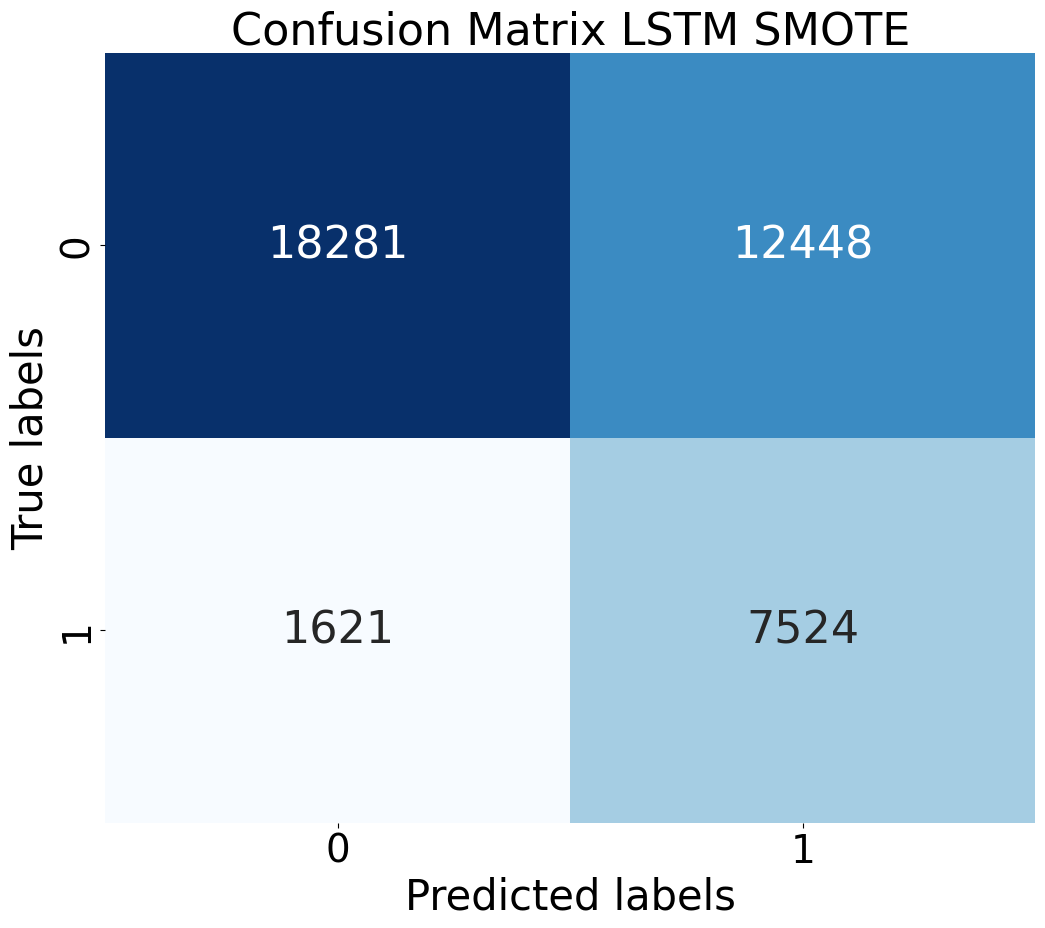

In [ ]:
# Compute confusion matrix and classification report for LSTM SMOTE
conf_matrix = confusion_matrix(y_test, y_pred_binary_LSTM_ovs)
cr_error = classification_report(y_test, y_pred_binary_LSTM_ovs)
print(cr_error)

# Plot confusion matrix
plt.figure(figsize=(12, 10))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False, annot_kws={"size": 32})
plt.xlabel('Predicted labels', fontsize=30)
plt.ylabel('True labels', fontsize=30)
plt.title('Confusion Matrix LSTM SMOTE', fontsize=32)
plt.xticks(fontsize=28)
plt.yticks(fontsize=28)
plt.savefig('Confusion_Matrix_LSTM_SMOTE.pdf', format='pdf')
plt.show()

In [ ]:
# Compute ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred)

# Compute ROC-AUC score
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label='ROC Curve (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

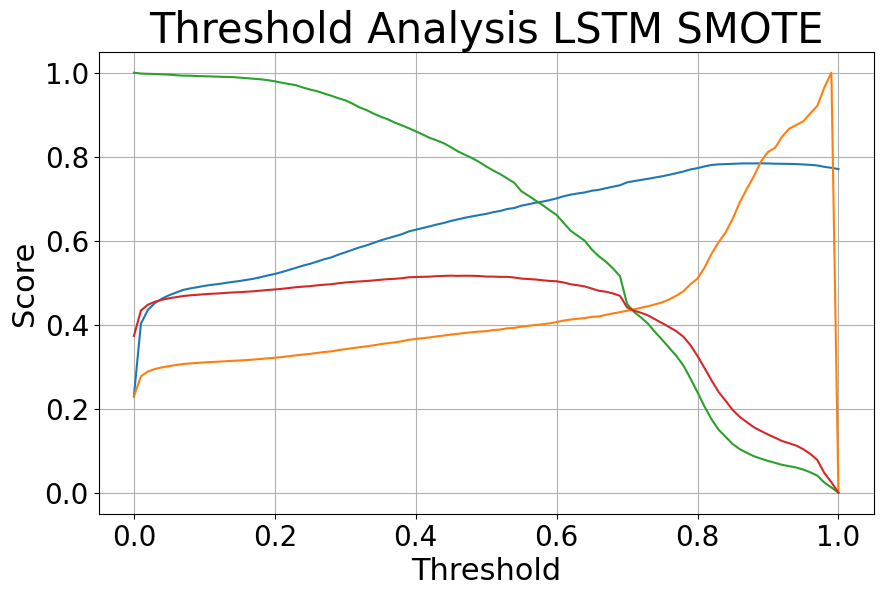

In [ ]:
thresholds = np.linspace(0, 1, 101)  # 100 thresholds from 0 to 1

# Initialize lists to store evaluation metrics
accuracy_scores = []
precision_scores = []
recall_scores = []
f1_scores = []

# Iterate over each threshold
for threshold in thresholds:
    # Convert probabilities to binary predictions based on the threshold
    y_pred_binary_LSTM_ovs = np.where(y_pred > threshold, 1, 0)

    # Evaluate the model using the current threshold
    accuracy = accuracy_score(y_test, y_pred_binary_LSTM_ovs)
    precision = precision_score(y_test, y_pred_binary_LSTM_ovs)
    recall = recall_score(y_test, y_pred_binary_LSTM_ovs)
    f1 = f1_score(y_test, y_pred_binary_LSTM_ovs)

    # Append evaluation metrics to lists
    accuracy_scores.append(accuracy)
    precision_scores.append(precision)
    recall_scores.append(recall)
    f1_scores.append(f1)

# Plot the evaluation metrics against thresholds
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))

plt.plot(thresholds, accuracy_scores, label='Accuracy')
plt.plot(thresholds, precision_scores, label='Precision')
plt.plot(thresholds, recall_scores, label='Recall')
plt.plot(thresholds, f1_scores, label='F1 Score')

plt.xlabel('Threshold', fontsize=22)
plt.ylabel('Score', fontsize=22)
plt.title('Threshold Analysis LSTM SMOTE', fontsize=30)
# plt.legend(fontsize=22)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.grid(True)

plt.savefig('Threshold_Analysis_LSTM_SMOTE.pdf')
plt.show()

In [ ]:
# Train the model
history = model_LSTM_ovs.fit(X_train_reshaped, labels_train_res, epochs=10, batch_size=32, validation_data=(X_val_reshaped, y_val))

Epoch 1/10
5769/5769 [==============================] - 39s 6ms/step - loss: 0.4850 - accuracy: 0.7574 - val_loss: 0.5675 - val_accuracy: 0.6666
Epoch 2/10
5769/5769 [==============================] - 53s 9ms/step - loss: 0.5203 - accuracy: 0.7290 - val_loss: 0.6558 - val_accuracy: 0.5346
Epoch 3/10
5769/5769 [==============================] - 40s 7ms/step - loss: 0.5511 - accuracy: 0.6989 - val_loss: 0.5543 - val_accuracy: 0.6574
Epoch 4/10
5769/5769 [==============================] - 35s 6ms/step - loss: 0.5044 - accuracy: 0.7460 - val_loss: 0.5242 - val_accuracy: 0.6893
Epoch 5/10
5769/5769 [==============================] - 36s 6ms/step - loss: 0.4889 - accuracy: 0.7563 - val_loss: 0.5261 - val_accuracy: 0.6870
Epoch 6/10
5769/5769 [==============================] - 37s 6ms/step - loss: 0.4838 - accuracy: 0.7575 - val_loss: 0.5203 - val_accuracy: 0.6937
Epoch 7/10
5769/5769 [==============================] - 36s 6ms/step - loss: 0.4804 - accuracy: 0.7604 - val_loss: 0.5087 - val_ac

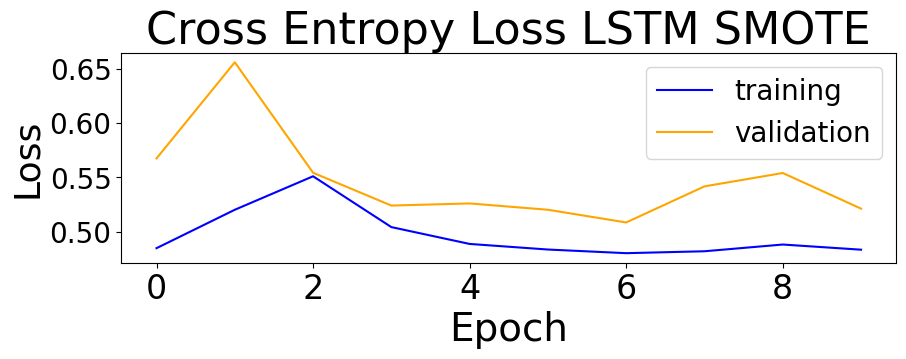

In [ ]:
# Plot Cross Entropy Loss for LSTM SMOTE
plt.figure(figsize=(10, 6))
plt.subplot(211)
plt.title('Cross Entropy Loss LSTM SMOTE', fontsize=32)
plt.plot(history.history['loss'], color='blue', label='train')
plt.plot(history.history['val_loss'], color='orange', label='test')
plt.legend(['training', 'validation'], fontsize=20)
plt.xlabel('Epoch', fontsize=28)
plt.ylabel('Loss', fontsize=26)
plt.xticks(fontsize=24)
plt.yticks(fontsize=20)
plt.savefig('Cross_Entropy_Loss_LSTM_SMOTE.pdf', format='pdf')
plt.show()

#### SHAP

##### Kmeans

In [69]:
np.random.seed(42)

sample_size = 200
sample_indices = np.random.choice(len(padded_sequences_test), size=sample_size, replace=False)
subset_X_test_reshaped = padded_sequences_test[sample_indices]

In [ ]:
# Summarize the background data using k-means
background_summary = shap.kmeans(subset_X_test_reshaped, 5)  # You can adjust the number of clusters (K) as needed

# Create an explainer using the Kernel SHAP method with the summarized background data
kernel_explainer = shap.KernelExplainer(model_LSTM_ovs.predict, background_summary)

# Compute SHAP values for the test data
shap_values_test_kernel_LSTM_ovs = kernel_explainer.shap_values(subset_X_test_reshaped)

1/1 [==============================] - 1s 564ms/step


  0%|          | 0/200 [00:00<?, ?it/s]

330/330 [==============================] - 1s 4ms/step


In [ ]:
np.save('/content/drive/My Drive/Thesis/Datasets/shap_values_test_kernel_LSTM_ovs.npy', shap_values_test_kernel_LSTM_ovs)

In [70]:
file_path = '/content/drive/My Drive/Thesis/Datasets/shap_values_test_kernel_LSTM_ovs.npy'
shap_values_test_kernel_LSTM_ovs = np.load(file_path)

In [71]:
# Define feature names based on the time steps in the sequence
# TS = Time Step
feature_names = [f"TS {i+1}" for i in range(subset_X_test_reshaped.shape[1])]

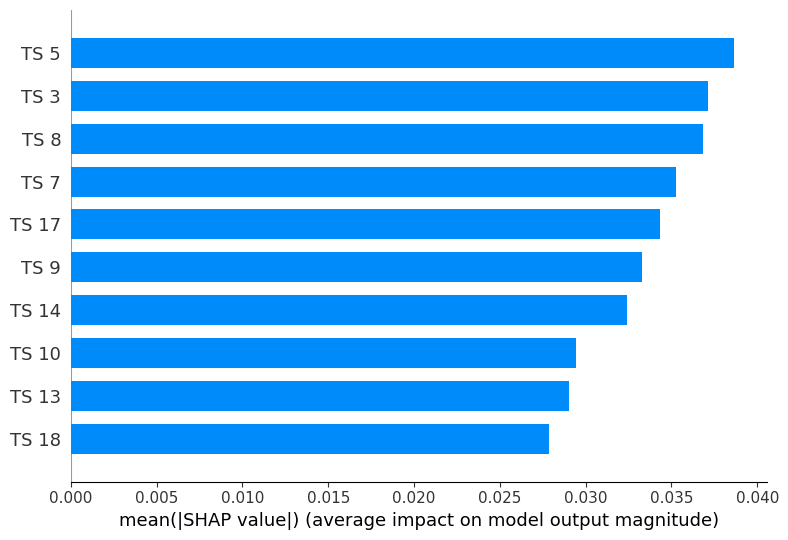

In [72]:
# Reshape the SHAP values matrix to match the shape of the features matrix
shap_values_test_kernel_LSTM_ovs_reshaped = shap_values_test_kernel_LSTM_ovs.reshape(shap_values_test_kernel_LSTM_ovs.shape[0], shap_values_test_kernel_LSTM_ovs.shape[1], -1)

# Aggregate SHAP values across all features
shap_values_aggregated = np.mean(shap_values_test_kernel_LSTM_ovs, axis=2)

# Get the mean absolute SHAP values for each feature
mean_abs_shap_values = np.mean(np.abs(shap_values_aggregated), axis=0)

# Sort the features based on their mean absolute SHAP values
sorted_indices = np.argsort(mean_abs_shap_values)[::-1]

# Select only the top ten features
top_ten_indices = sorted_indices[:10]
top_ten_features = subset_X_test_reshaped[:, top_ten_indices]
top_ten_feature_names = [feature_names[i] for i in top_ten_indices]

# Plot the aggregated SHAP values for the top ten features
shap.summary_plot(shap_values_aggregated[:, top_ten_indices], features=top_ten_features, feature_names=top_ten_feature_names , plot_type='bar')

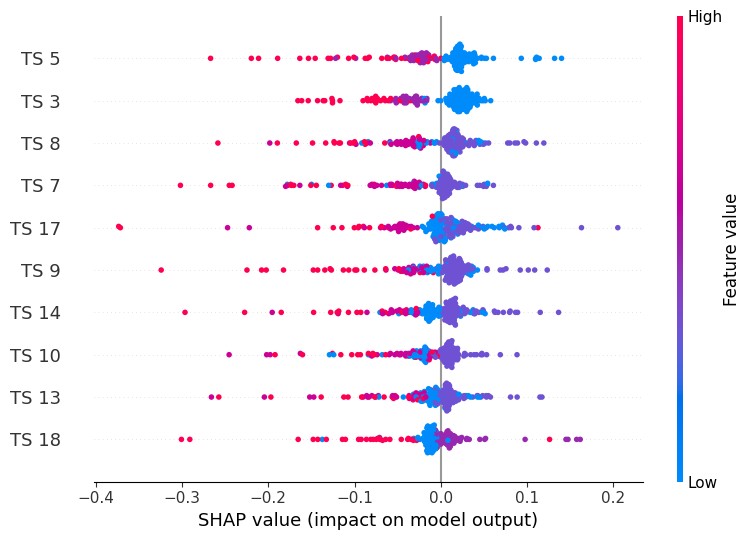

In [73]:
shap.summary_plot(shap_values_aggregated[:, top_ten_indices], features=top_ten_features, feature_names=top_ten_feature_names)

In [74]:
# Summarize the background data using k-means
background_summary = shap.kmeans(subset_X_test_reshaped, 5)  # You can adjust the number of clusters (K) as needed

# Create an explainer using the Kernel SHAP method with the summarized background data
kernel_explainer = shap.KernelExplainer(model_LSTM_ovs.predict, background_summary)

1/1 [==============================] - 1s 776ms/step


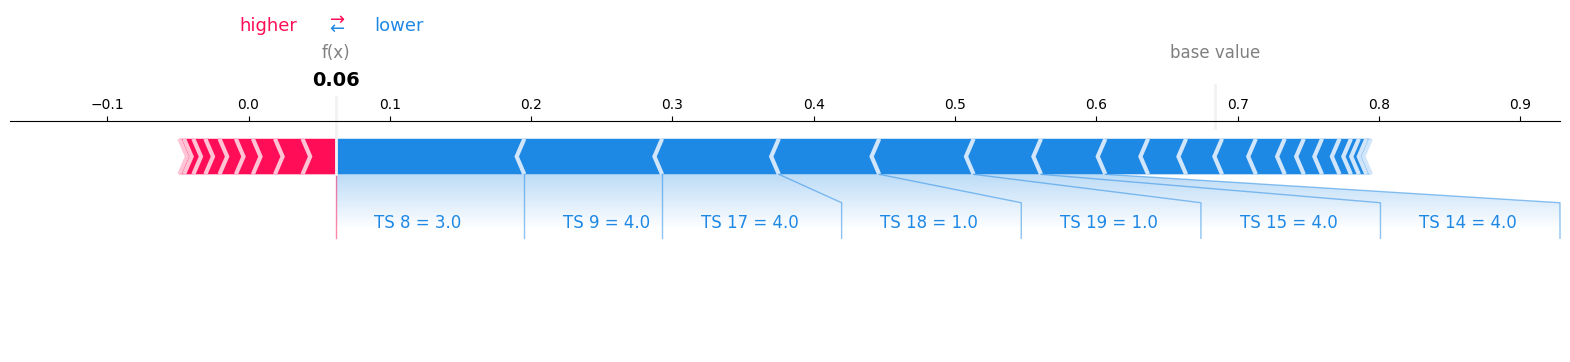

In [75]:
# Choose an instance to explain (e.g., the first instance)
instance_index = 10

# Generate force plot for the chosen instance
shap.force_plot(kernel_explainer.expected_value, shap_values_test_kernel_LSTM_ovs[instance_index][:, 0], subset_X_test_reshaped[instance_index], matplotlib=True, feature_names= feature_names)

1247/1247 [==============================] - 4s 3ms/step


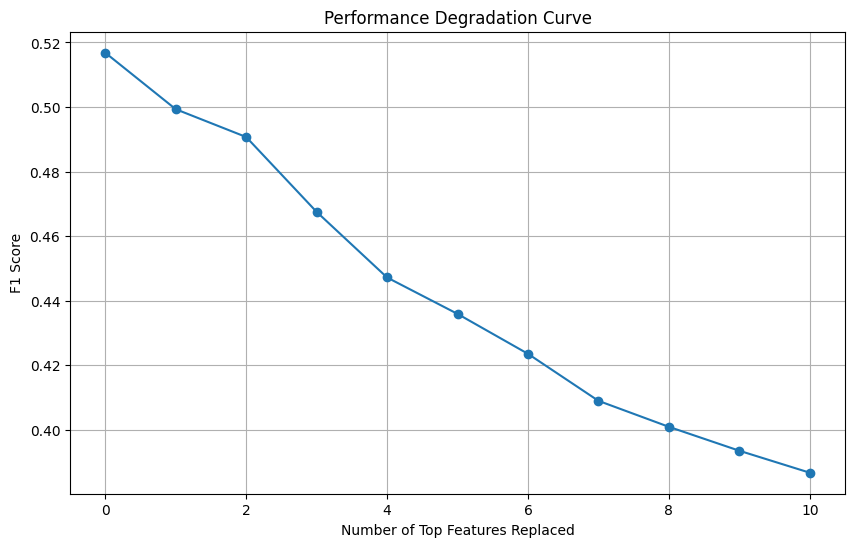

In [ ]:
# Create a copy of the test data to modify
modified_test_set = np.array(padded_sequences_test)

# Store original F1 score with unmodified data
original_pred = model_LSTM_ovs.predict(padded_sequences_test)
original_f1 = f1_score(y_test, (original_pred > 0.45).astype(int))

# Initialize a list to store F1 scores after each feature modification
f1_scores_LSTM_ovs = [original_f1]

# Replace each top feature with the majority value found in that feature
for i, feature_idx in enumerate(top_ten_indices):
    # Find the majority class for the current feature across all test data
    majority_value = np.bincount(modified_test_set[:, feature_idx]).argmax()

    # Replace this feature in all test samples with the majority class
    modified_test_set[:, feature_idx] = majority_value

    # Evaluate the model with the modified test set
    new_predictions = model_LSTM_ovs.predict(modified_test_set)
    new_f1 = f1_score(y_test, (new_predictions > 0.45).astype(int))

    # Append the new F1 score
    f1_scores_LSTM_ovs.append(new_f1)

# Plot the performance degradation curve
plt.figure(figsize=(10, 6))
plt.plot(range(len(f1_scores_LSTM_ovs)), f1_scores_LSTM_ovs, marker='o')
plt.title('Performance Degradation Curve')
plt.xlabel('Number of Top Features Replaced')
plt.ylabel('F1 Score')
plt.grid(True)

In [ ]:
f1_scores_LSTM_ovs

[0.51681148469966,
 0.49932297375717327,
 0.4907102466911079,
 0.4675264184448779,
 0.4472019199301844,
 0.435927050038946,
 0.4235602497879886,
 0.4090032154340835,
 0.4009508716323297,
 0.39354417998043695,
 0.38673955705074287]

##### Both classes

In [ ]:
# Filter the dataset for "cart abandonment" sessions (target = 0)
cart_abandonment_sessions = df_train[df_train["conversion"] == 0][["session_id_hash", "session"]]
sequences_train_ca = cart_abandonment_sessions['session'].tolist()
sequences_train_ca = [[int(num) for num in item.strip("[]").split(', ')] for item in sequences_train_ca]
max_length = 30  # Choose the maximum length you want
padded_sequences_ca = pad_sequences(sequences_train_ca, maxlen= max_length, padding='post', truncating='post')

# Filter the dataset for "purchase" sessions (target = 1)
purchase_sessions = df_train[df_train["conversion"] == 1][["session_id_hash", "session"]]
sequences_train_pu = purchase_sessions['session'].tolist()
sequences_train_pu = [[int(num) for num in item.strip("[]").split(', ')] for item in sequences_train_pu]
max_length = 30  # Choose the maximum length you want
padded_sequences_pu = pad_sequences(sequences_train_pu, maxlen= max_length, padding='post', truncating='post')

In [ ]:
# Set a fixed random seed
np.random.seed(42)

sample_size = 100
sample_indices = np.random.choice(len(padded_sequences_ca), size=sample_size, replace=False)
subset_X_test_reshaped_ca = padded_sequences_ca[sample_indices]

sample_indices = np.random.choice(len(padded_sequences_pu), size=sample_size, replace=False)
subset_X_test_reshaped_pu = padded_sequences_pu[sample_indices]

In [ ]:
# Summarize the background data using k-means
background_summary = shap.kmeans(subset_X_test_reshaped_ca, 5)  # You can adjust the number of clusters (K) as needed

# Create an explainer using the Kernel SHAP method with the summarized background data
kernel_explainer = shap.KernelExplainer(model_LSTM_ovs.predict, background_summary)

# Compute SHAP values for the test data
shap_values_class0 = kernel_explainer.shap_values(subset_X_test_reshaped_ca)

1/1 [==============================] - 0s 336ms/step


  0%|          | 0/100 [00:00<?, ?it/s]

330/330 [==============================] - 1s 2ms/step


In [ ]:
# Summarize the background data using k-means
background_summary = shap.kmeans(subset_X_test_reshaped_pu, 5)  # You can adjust the number of clusters (K) as needed

# Create an explainer using the Kernel SHAP method with the summarized background data
kernel_explainer = shap.KernelExplainer(model_LSTM_ovs.predict, background_summary)

# Compute SHAP values for the test data
shap_values_class1 = kernel_explainer.shap_values(subset_X_test_reshaped_pu)

1/1 [==============================] - 0s 28ms/step


  0%|          | 0/100 [00:00<?, ?it/s]

329/329 [==============================] - 1s 3ms/step


In [ ]:
# Define feature names based on the time steps in the sequence
# TS = Time Step
feature_names = [f"TS {i+1}" for i in range(subset_X_test_reshaped_ca.shape[1])]

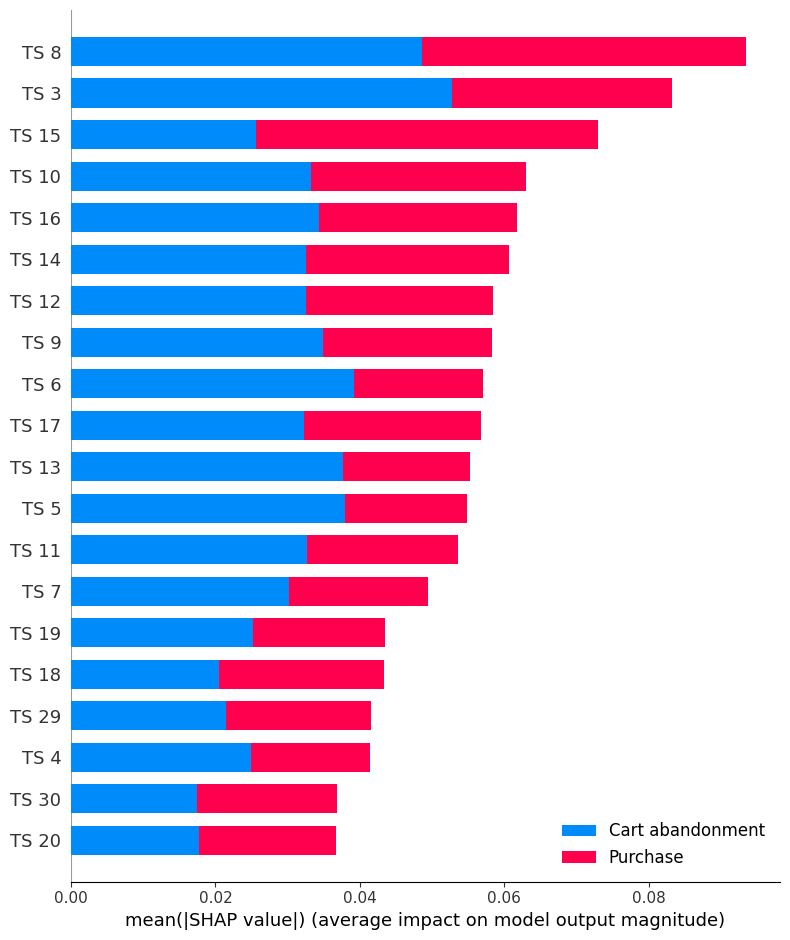

In [ ]:
# Reshape the SHAP values matrix to match the shape of the features matrix for each class
shap_values_class0_reshaped = shap_values_class0.reshape(shap_values_class0.shape[0], shap_values_class0.shape[1], -1)
shap_values_class1_reshaped = shap_values_class1.reshape(shap_values_class1.shape[0], shap_values_class1.shape[1], -1)

# Aggregate SHAP values across all features for each class
shap_values_class0_aggregated = np.mean(shap_values_class0, axis=2)
shap_values_class1_aggregated = np.mean(shap_values_class1, axis=2)

# Create a matplotlib figure and axis
fig, ax = plt.subplots()

# Plot the aggregated SHAP values for the top ten features for both classes in one summary plot
shap.summary_plot([shap_values_class0_aggregated, shap_values_class1_aggregated],
                  feature_names=feature_names,
                  plot_type='bar',
                  class_names=['Cart abandonment', 'Purchase'],
                  show=False)  # Prevents immediate showing of the plot

# Save the figure as a PDF
plt.savefig('shap_summary_plot_LSTM_SMOTE.pdf', bbox_inches='tight')  # Save as PDF

# If you want to display the plot as well, uncomment the next line
# plt.show()

## Oversampling with Undersampling (GRU)

In [ ]:
from imblearn.pipeline import Pipeline
from sklearn.datasets import make_classification
from sklearn.model_selection import cross_validate
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.ensemble import AdaBoostClassifier
from imblearn.combine import SMOTEENN
from imblearn.under_sampling import EditedNearestNeighbours

In [ ]:
Counter(labels_train)

Counter({1.0: 30, 0.0: 70})

In [ ]:
print("Class distribution after oversampling:", Counter(labels_train))

#Define SMOTE-ENN
resample=SMOTEENN(enn=EditedNearestNeighbours(sampling_strategy="auto", n_neighbors= 1))

padded_sequences_train_re, labels_train_re = resample.fit_resample(X_train, y_train)
# Print the distribution of classes after oversampling
print("Class distribution after oversampling:", Counter(labels_train_re))

Class distribution after oversampling: Counter({0.0: 123059, 1.0: 36434})
Class distribution after oversampling: Counter({0.0: 92300, 1.0: 67833})


In [ ]:
# Reshape the input data to match the expected input shape of the GRU layer
X_train_reshaped = np.expand_dims(padded_sequences_train_re, axis=-1)
X_val_reshaped = np.expand_dims(X_val, axis=-1)

In [ ]:
model_GRU_ovs_uns = Sequential([
    GRU(64, input_shape=(None, 1)),
    Dropout(0.5),
    Dense(32, activation='relu'),
    BatchNormalization(),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

# Compile the model with Adam optimizer and a lower learning rate
optimizer = Adam(learning_rate=0.001)
model_GRU_ovs_uns.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
history = model_GRU_ovs_uns.fit(X_train_reshaped, labels_train_re, epochs=10, batch_size=64, validation_data=(X_val_reshaped, y_val))

Epoch 1/10
2503/2503 [==============================] - 84s 31ms/step - loss: 0.6796 - accuracy: 0.5837 - val_loss: 0.6156 - val_accuracy: 0.7606
Epoch 2/10
2503/2503 [==============================] - 63s 25ms/step - loss: 0.5537 - accuracy: 0.6967 - val_loss: 0.5355 - val_accuracy: 0.6619
Epoch 3/10
2503/2503 [==============================] - 56s 22ms/step - loss: 0.4978 - accuracy: 0.7411 - val_loss: 0.5005 - val_accuracy: 0.7373
Epoch 4/10
2503/2503 [==============================] - 57s 23ms/step - loss: 0.4831 - accuracy: 0.7515 - val_loss: 0.5056 - val_accuracy: 0.7101
Epoch 5/10
2503/2503 [==============================] - 57s 23ms/step - loss: 0.4748 - accuracy: 0.7562 - val_loss: 0.5121 - val_accuracy: 0.7176
Epoch 6/10
2503/2503 [==============================] - 54s 22ms/step - loss: 0.4677 - accuracy: 0.7602 - val_loss: 0.5324 - val_accuracy: 0.6970
Epoch 7/10
2503/2503 [==============================] - 55s 22ms/step - loss: 0.4606 - accuracy: 0.7666 - val_loss: 0.4985 -

In [ ]:
# Predict labels for the test set
y_pred = model.predict(padded_sequences_test)
y_pred_binary = (y_pred > 0.25).astype(int)  # Convert probabilities to binary predictions

# Calculate the F1 score
f1 = f1_score(y_test, y_pred_binary)

print("F1 Score:", f1)

1247/1247 [==============================] - 10s 8ms/step
F1 Score: 0.49515011547344107


              precision    recall  f1-score   support

         0.0       0.85      0.79      0.82     30729
         1.0       0.42      0.52      0.47      9145

    accuracy                           0.73     39874
   macro avg       0.63      0.65      0.64     39874
weighted avg       0.75      0.73      0.74     39874



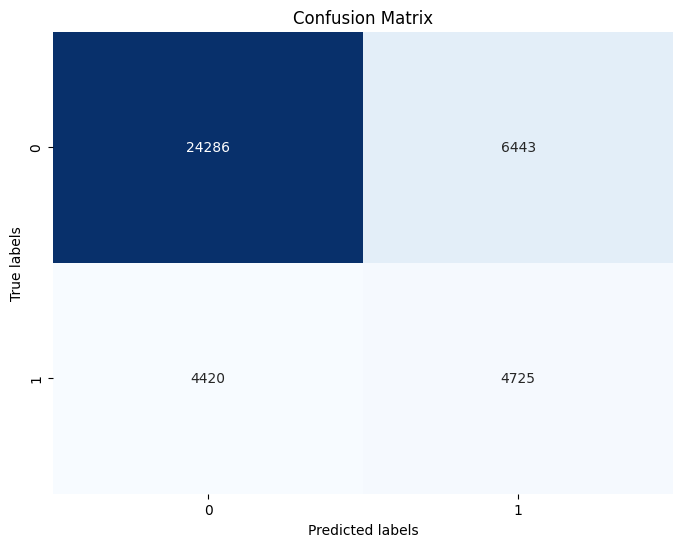

In [ ]:
conf_matrix = confusion_matrix(y_test, y_pred_binary)
cr_error = classification_report(y_test, y_pred_binary)
print(cr_error)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

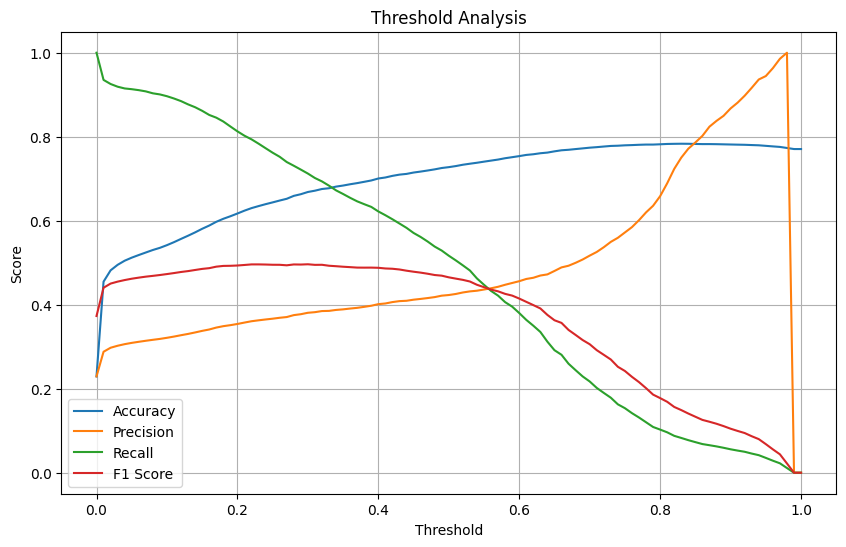

In [ ]:
thresholds = np.linspace(0, 1, 101)  # 100 thresholds from 0 to 1

# Initialize lists to store evaluation metrics
accuracy_scores = []
precision_scores = []
recall_scores = []
f1_scores = []

# Iterate over each threshold
for threshold in thresholds:
    # Convert probabilities to binary predictions based on the threshold
    y_pred_binary = np.where(y_pred > threshold, 1, 0)

    # Evaluate the model using the current threshold
    accuracy = accuracy_score(y_test, y_pred_binary)
    precision = precision_score(y_test, y_pred_binary)
    recall = recall_score(y_test, y_pred_binary)
    f1 = f1_score(y_test, y_pred_binary)

    # Append evaluation metrics to lists
    accuracy_scores.append(accuracy)
    precision_scores.append(precision)
    recall_scores.append(recall)
    f1_scores.append(f1)

# Plot the evaluation metrics against thresholds
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))

plt.plot(thresholds, accuracy_scores, label='Accuracy')
plt.plot(thresholds, precision_scores, label='Precision')
plt.plot(thresholds, recall_scores, label='Recall')
plt.plot(thresholds, f1_scores, label='F1 Score')

plt.xlabel('Threshold')
plt.ylabel('Score')
plt.title('Threshold Analysis')
plt.legend()
plt.grid(True)
plt.show()

### SHAP

## Undersampling ENN (GRU)

In [ ]:
sequences_train = X_train['session'].tolist()
sequences_test = X_test['session'].tolist()
sequences_train = [[int(num) for num in item.strip("[]").split(', ')] for item in sequences_train]
sequences_test = [[int(num) for num in item.strip("[]").split(', ')] for item in sequences_test]

# Pad sequences to a fixed length
max_length = 30  # Choose the maximum length you want
padded_sequences_train = pad_sequences(sequences_train, maxlen= max_length, padding='post', truncating='post')
padded_sequences_test = pad_sequences(sequences_test, maxlen= max_length, padding='post', truncating='post')

# Convert padded sequences to NumPy array
sequences_train = np.array(padded_sequences_train)
labels_train = np.array(y_train)
sequences_test = np.array(padded_sequences_test)
labels_test = np.array(y_test)

In [ ]:
# Split the data into train, validation, and test sets
X_train, X_val, y_train, y_val = train_test_split(sequences_train, labels_train, test_size=0.25, random_state=42)  # 0.25 x 0.8 = 0.2

# Reshape the input data to match the expected input shape of the GRU layer
X_train_reshaped = np.expand_dims(X_train, axis=-1)
X_val_reshaped = np.expand_dims(X_val, axis=-1)

In [ ]:
X_train.shape

(119619, 30)

In [ ]:
y_train.shape

(119619,)

In [ ]:
# Original dataset
print('Original dataset shape:', Counter(y_train))

enn = EditedNearestNeighbours(n_neighbors=5)  # Adjust the n_neighbors parameter as needed
X_res, y_res = enn.fit_resample(X_train, y_train)

# Print the shape of the resampled dataset
print('Resampled dataset shape:', Counter(y_res))

Original dataset shape: Counter({0.0: 92300, 1.0: 27319})
Resampled dataset shape: Counter({0.0: 34893, 1.0: 27319})


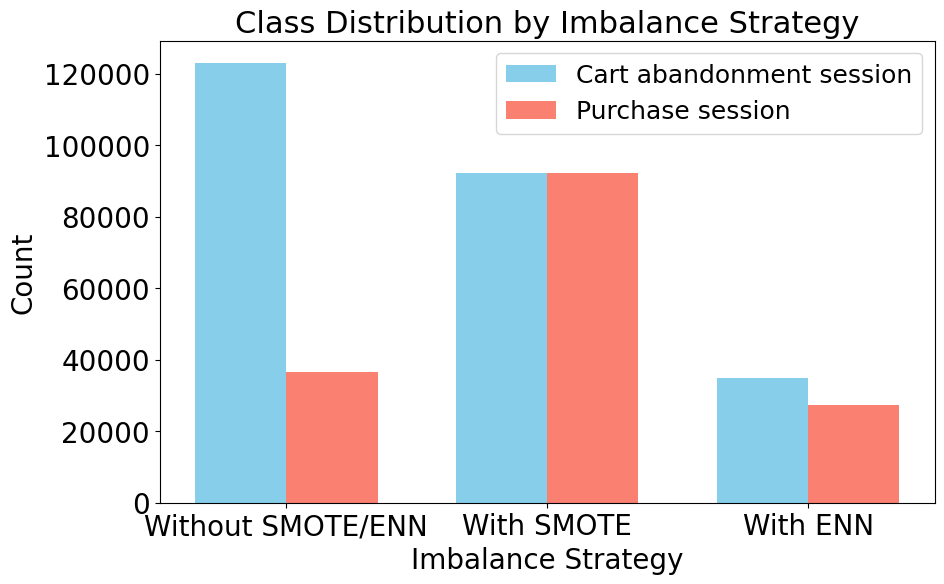

In [ ]:
# Data
strategies = ['Without SMOTE/ENN', 'With SMOTE', 'With ENN']
counts_0 = [123059, 92300, 34893]
counts_1 = [36434, 92300, 27319]

fig, ax = plt.subplots(figsize=(10, 6))
bar_width = 0.35  # width of bars

index = range(len(strategies))

# Plotting
bars1 = ax.bar(index, counts_0, bar_width, label='Cart abandonment session', color='skyblue')
bars2 = ax.bar([p + bar_width for p in index], counts_1, bar_width, label='Purchase session', color='salmon')

# Increase font sizes
ax.set_xlabel('Imbalance Strategy', fontsize=20)  # Increase font size for x-axis label
ax.set_ylabel('Count', fontsize=20)  # Increase font size for y-axis label
ax.set_title('Class Distribution by Imbalance Strategy', fontsize=22)  # Increase font size for title
ax.set_xticks([p + bar_width / 2 for p in index])
ax.set_xticklabels(strategies, fontsize=18)  # Increase font size for x-axis tick labels
ax.legend(fontsize=18)  # Increase font size for legend
ax.tick_params(axis='both', which='major', labelsize=20)

plt.savefig('Class distributions.pdf', format='pdf')
plt.show()

In [ ]:
# n_neighbors = 3
# Resampled dataset shape: Counter({0.0: 65752, 1.0: 36434})
# n_neighbors = 5
# Resampled dataset shape: Counter({0.0: 47289, 1.0: 36434})
# n_neighbors = 7
# Resampled dataset shape: Counter({1.0: 36434, 0.0: 36060})

In [ ]:
# Reshape the input data to match the expected input shape of the GRU layer
X_train_reshaped = np.expand_dims(X_res, axis=-1)
X_val_reshaped = np.expand_dims(X_val, axis=-1)

In [ ]:
model_GRU_uns = Sequential([
    GRU(32, input_shape=(None, 1)),
    Dropout(0.25),
    Dense(32, activation='relu'),
    Dense(1, activation='sigmoid')
])

# Compile the model with Adam optimizer and a lower learning rate
optimizer = Adam(learning_rate=0.001)
model_GRU_uns.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
history = model_GRU_uns.fit(X_train_reshaped, y_res, epochs=10, batch_size=64, validation_data=(X_val_reshaped, y_val))

Epoch 1/10
973/973 [==============================] - 14s 8ms/step - loss: 0.6393 - accuracy: 0.6271 - val_loss: 0.6263 - val_accuracy: 0.6485
Epoch 2/10
973/973 [==============================] - 7s 7ms/step - loss: 0.4352 - accuracy: 0.7798 - val_loss: 0.8151 - val_accuracy: 0.5975
Epoch 3/10
973/973 [==============================] - 8s 8ms/step - loss: 0.3861 - accuracy: 0.8103 - val_loss: 0.7959 - val_accuracy: 0.5989
Epoch 4/10
973/973 [==============================] - 7s 7ms/step - loss: 0.3703 - accuracy: 0.8165 - val_loss: 0.8035 - val_accuracy: 0.6136
Epoch 5/10
973/973 [==============================] - 8s 8ms/step - loss: 0.3606 - accuracy: 0.8207 - val_loss: 0.7114 - val_accuracy: 0.6348
Epoch 6/10
973/973 [==============================] - 8s 8ms/step - loss: 0.3535 - accuracy: 0.8240 - val_loss: 0.7441 - val_accuracy: 0.6374
Epoch 7/10
973/973 [==============================] - 6s 6ms/step - loss: 0.3498 - accuracy: 0.8240 - val_loss: 0.7113 - val_accuracy: 0.6460
Epoch

In [ ]:
model_save_name = 'model_GRU_uns.h5'
path = "/content/drive/MyDrive/Thesis/Models/" + model_save_name
model_GRU_uns.save(path)

In [ ]:
# Load the model from the saved HDF5 file
model_save_name = 'model_GRU_uns.h5'
path = "/content/drive/MyDrive/Thesis/Models/" + model_save_name
model_GRU_uns = load_model(path)

In [ ]:
# Predict labels for the test set
y_pred = model_GRU_uns.predict(X_train_reshaped)
y_pred_binary = (y_pred > 0.58).astype(int)  # Convert probabilities to binary predictions

# Calculate the F1 score
f1 = f1_score(y_res, y_pred_binary)

print("F1 Score:", f1)

1945/1945 [==============================] - 7s 3ms/step
F1 Score: 0.7870512668952201


In [ ]:
# Predict labels for the test set
y_pred = model_GRU_uns.predict(X_val_reshaped)
y_pred_binary = (y_pred > 0.58).astype(int)  # Convert probabilities to binary predictions

# Calculate the F1 score
f1 = f1_score(y_val, y_pred_binary)

print("F1 Score:", f1)

1247/1247 [==============================] - 3s 2ms/step
F1 Score: 0.5134010191776559


In [ ]:
# Predict labels for the test set
y_pred = model_GRU_uns.predict(padded_sequences_test)
y_pred_binary_GRU_uns = (y_pred > 0.58).astype(int)  # Convert probabilities to binary predictions

# Calculate the F1 score
f1 = f1_score(y_test, y_pred_binary_GRU_uns)

print("F1 Score:", f1)

1247/1247 [==============================] - 26s 17ms/step
F1 Score: 0.5210386360081339


In [ ]:
y_pred[:10]

array([[0.50895387],
       [0.00244271],
       [0.8883189 ],
       [0.82357997],
       [0.9142144 ],
       [0.45095834],
       [0.67497915],
       [0.9917505 ],
       [0.5575873 ],
       [0.00451035]], dtype=float32)

Mean Probability: 0.47926339507102966
Standard Deviation: 0.34529387950897217


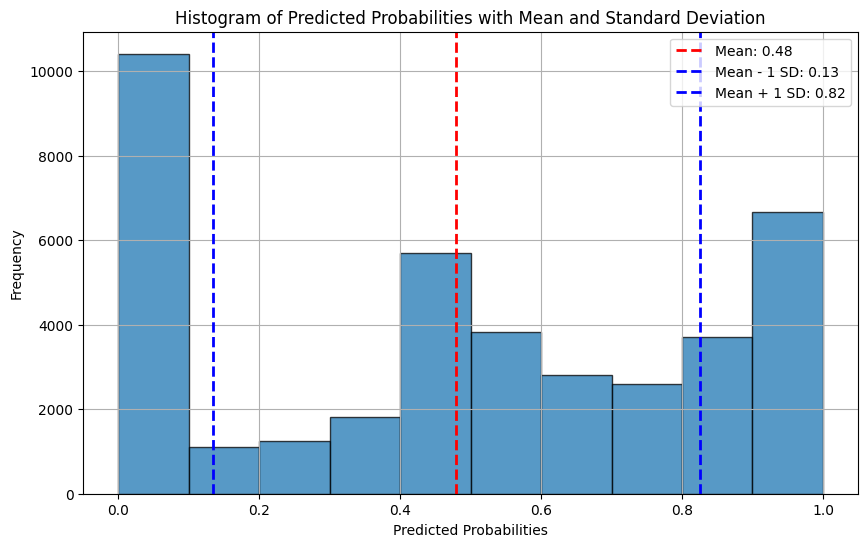

In [ ]:

# Calculate mean and standard deviation
mean_prob = np.mean(y_pred)
std_prob = np.std(y_pred)

print(f"Mean Probability: {mean_prob}")
print(f"Standard Deviation: {std_prob}")

# Plotting the probabilities with mean and standard deviation
plt.figure(figsize=(10, 6))
plt.hist(y_pred, bins=10, alpha=0.75, edgecolor='black')
plt.axvline(mean_prob, color='red', linestyle='dashed', linewidth=2, label=f'Mean: {mean_prob:.2f}')
plt.axvline(mean_prob - std_prob, color='blue', linestyle='dashed', linewidth=2, label=f'Mean - 1 SD: {mean_prob - std_prob:.2f}')
plt.axvline(mean_prob + std_prob, color='blue', linestyle='dashed', linewidth=2, label=f'Mean + 1 SD: {mean_prob + std_prob:.2f}')
plt.xlabel('Predicted Probabilities')
plt.ylabel('Frequency')
plt.title('Histogram of Predicted Probabilities with Mean and Standard Deviation')
plt.legend()
plt.grid(True)
plt.show()

#### Error Analysis

Brier Score: 0.25087619078274415


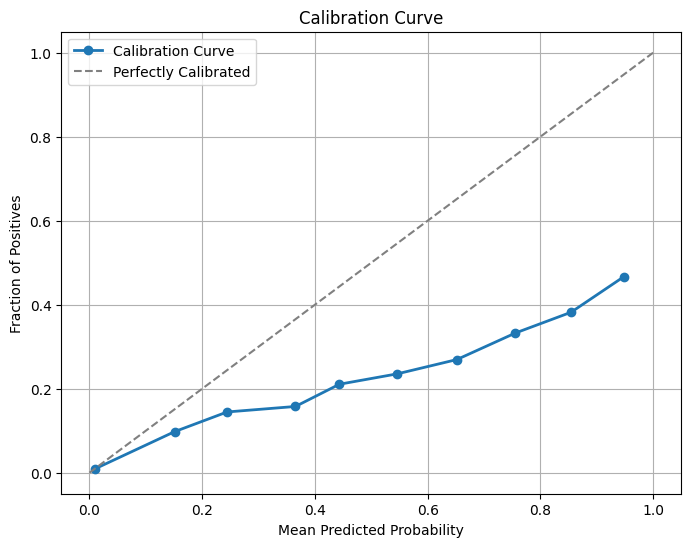

In [ ]:
prob_true, prob_pred = calibration_curve(y_test, y_pred, n_bins=10, strategy='uniform')

# Compute Brier score
brier_score = brier_score_loss(y_test, y_pred)
print("Brier Score:", brier_score)

# Plot calibration curve
plt.figure(figsize=(8, 6))
plt.plot(prob_pred, prob_true, marker='o', linewidth=2, label='Calibration Curve')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Perfectly Calibrated')
plt.xlabel('Mean Predicted Probability')
plt.ylabel('Fraction of Positives')
plt.title('Calibration Curve')
plt.legend()
plt.grid(True)
plt.show()

              precision    recall  f1-score   support

         0.0       0.89      0.68      0.77     30729
         1.0       0.41      0.73      0.52      9145

    accuracy                           0.69     39874
   macro avg       0.65      0.71      0.65     39874
weighted avg       0.78      0.69      0.72     39874



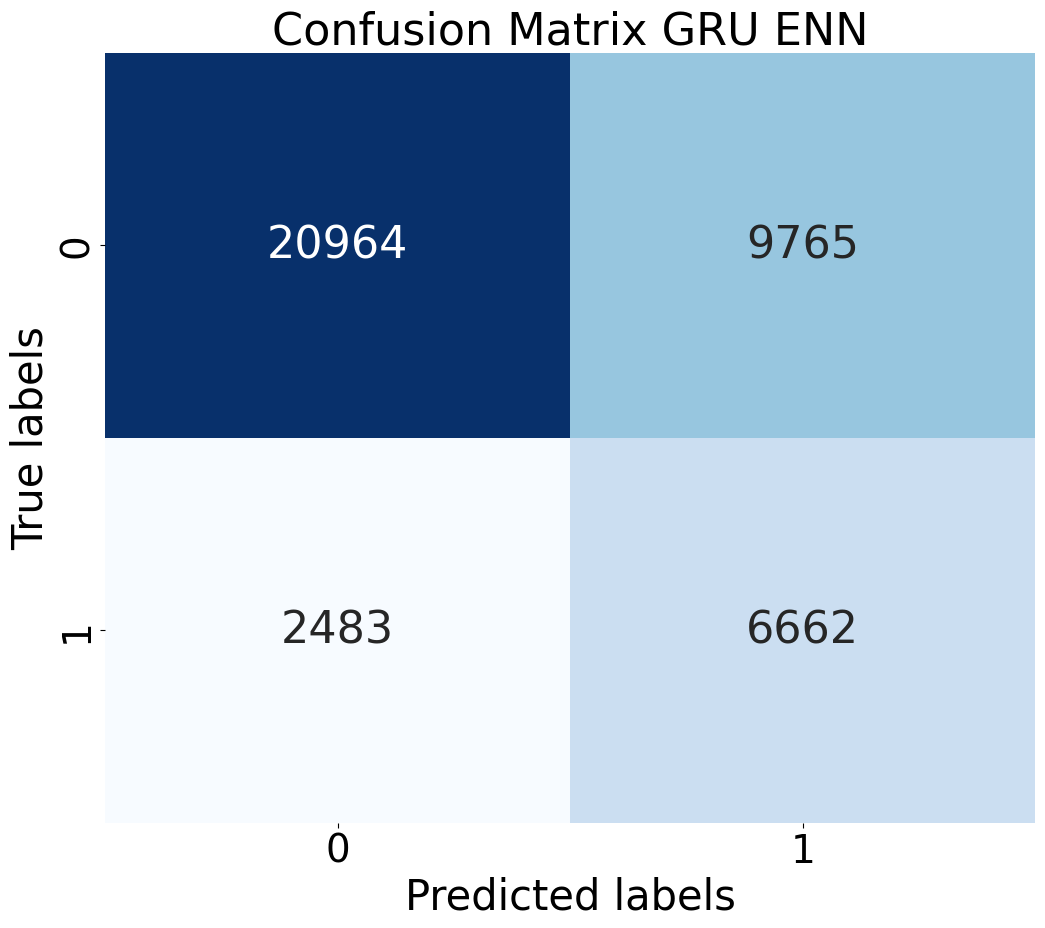

In [ ]:
# Compute confusion matrix and classification report for GRU ENN
conf_matrix = confusion_matrix(y_test, y_pred_binary_GRU_uns)
cr_error = classification_report(y_test, y_pred_binary_GRU_uns)
print(cr_error)

# Plot confusion matrix
plt.figure(figsize=(12, 10))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False, annot_kws={"size": 32})
plt.xlabel('Predicted labels', fontsize=30)
plt.ylabel('True labels', fontsize=30)
plt.title('Confusion Matrix GRU ENN', fontsize=32)
plt.xticks(fontsize=28)
plt.yticks(fontsize=28)
plt.savefig("Confusion_Matrix_GRU_ENN.pdf", format='pdf')
plt.show()

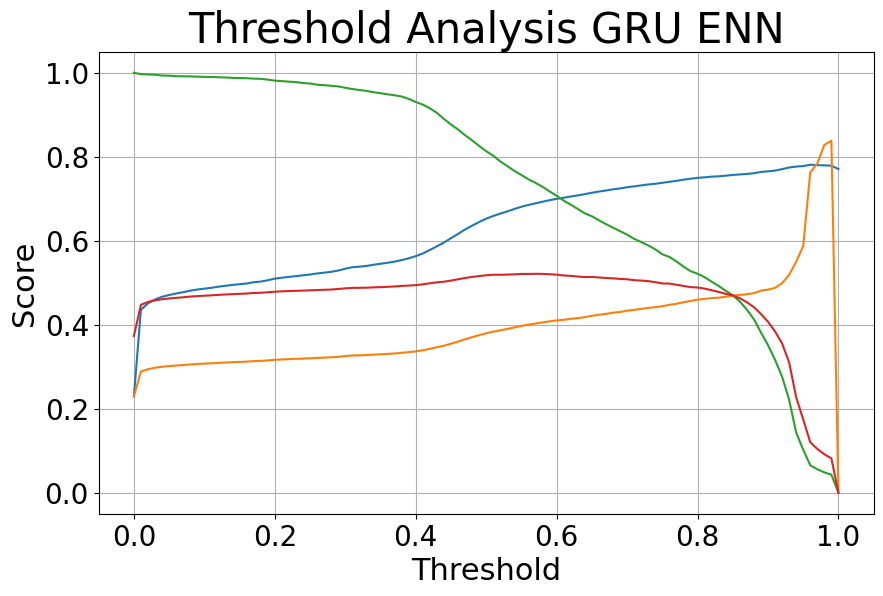

In [ ]:
thresholds = np.linspace(0, 1, 101)  # 100 thresholds from 0 to 1

# Initialize lists to store evaluation metrics
accuracy_scores = []
precision_scores = []
recall_scores = []
f1_scores = []

# Iterate over each threshold
for threshold in thresholds:
    # Convert probabilities to binary predictions based on the threshold
    y_pred_binary_GRU_uns = np.where(y_pred > threshold, 1, 0)

    # Evaluate the model using the current threshold
    accuracy = accuracy_score(y_test, y_pred_binary_GRU_uns)
    precision = precision_score(y_test, y_pred_binary_GRU_uns)
    recall = recall_score(y_test, y_pred_binary_GRU_uns)
    f1 = f1_score(y_test, y_pred_binary_GRU_uns)

    # Append evaluation metrics to lists
    accuracy_scores.append(accuracy)
    precision_scores.append(precision)
    recall_scores.append(recall)
    f1_scores.append(f1)

plt.figure(figsize=(10, 6))

plt.plot(thresholds, accuracy_scores, label='Accuracy')
plt.plot(thresholds, precision_scores, label='Precision')
plt.plot(thresholds, recall_scores, label='Recall')
plt.plot(thresholds, f1_scores, label='F1 Score')

plt.xlabel('Threshold', fontsize=22)
plt.ylabel('Score', fontsize=22)
plt.title('Threshold Analysis GRU ENN', fontsize=30)
# plt.legend(fontsize=22)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.grid(True)

plt.savefig('Threshold_Analysis_GRU_ENN.pdf')
plt.show()

In [ ]:
# Train the model
history = model_GRU_uns.fit(X_train_reshaped, y_res, epochs=10, batch_size=64, validation_data=(X_val_reshaped, y_val))

Epoch 1/10
973/973 [==============================] - 8s 7ms/step - loss: 0.3400 - accuracy: 0.8305 - val_loss: 0.6799 - val_accuracy: 0.6661
Epoch 2/10
973/973 [==============================] - 8s 8ms/step - loss: 0.3383 - accuracy: 0.8312 - val_loss: 0.7318 - val_accuracy: 0.6298
Epoch 3/10
973/973 [==============================] - 6s 7ms/step - loss: 0.3370 - accuracy: 0.8315 - val_loss: 0.7848 - val_accuracy: 0.6287
Epoch 4/10
973/973 [==============================] - 8s 9ms/step - loss: 0.3350 - accuracy: 0.8311 - val_loss: 0.7906 - val_accuracy: 0.6173
Epoch 5/10
973/973 [==============================] - 7s 7ms/step - loss: 0.3349 - accuracy: 0.8331 - val_loss: 0.7802 - val_accuracy: 0.6267
Epoch 6/10
973/973 [==============================] - 9s 9ms/step - loss: 0.3339 - accuracy: 0.8328 - val_loss: 0.7419 - val_accuracy: 0.6199
Epoch 7/10
973/973 [==============================] - 6s 7ms/step - loss: 0.3324 - accuracy: 0.8343 - val_loss: 0.7435 - val_accuracy: 0.6334
Epoch 

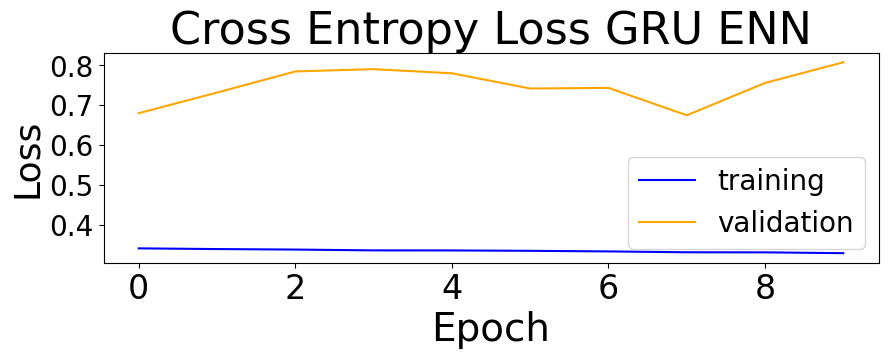

In [ ]:
# Plot Cross Entropy Loss for GRU ENN
plt.figure(figsize=(10, 6))
plt.subplot(211)
plt.title('Cross Entropy Loss GRU ENN', fontsize=32)
plt.plot(history.history['loss'], color='blue', label='train')
plt.plot(history.history['val_loss'], color='orange', label='test')
plt.legend(['training', 'validation'], fontsize=20)
plt.xlabel('Epoch', fontsize=28)
plt.ylabel('Loss', fontsize=26)
plt.xticks(fontsize=24)
plt.yticks(fontsize=20)
plt.savefig('Cross_Entropy_Loss_GRU_ENN.pdf', format='pdf')
plt.show()

In [ ]:
# Predict labels for the test set
y_pred_LSTM_ovs = model_LSTM_ovs.predict(padded_sequences_test)
y_pred_GRU_ovs = model_GRU_ovs.predict(padded_sequences_test)
y_pred_LSTM_uns = model_LSTM_uns.predict(padded_sequences_test)
y_pred_GRU_uns = model_GRU_uns.predict(padded_sequences_test)

1247/1247 [==============================] - 3s 2ms/step


In [ ]:
def predict_df(df):
    predictions = []
    for index, row in df.iterrows():
        sequence = row['session']
        purchase_probability = markov_model.predict_purchase_probability(sequence)
        predictions.append(purchase_probability)
    return predictions

data = {'session': X_test["session"], 'conversion': y_test}
X_test = pd.DataFrame(data)

# Make predictions on the dataframe
y_pred_markov = predict_df(X_test)

In [ ]:
y_pred_markov = y_pred_markov[:39874]

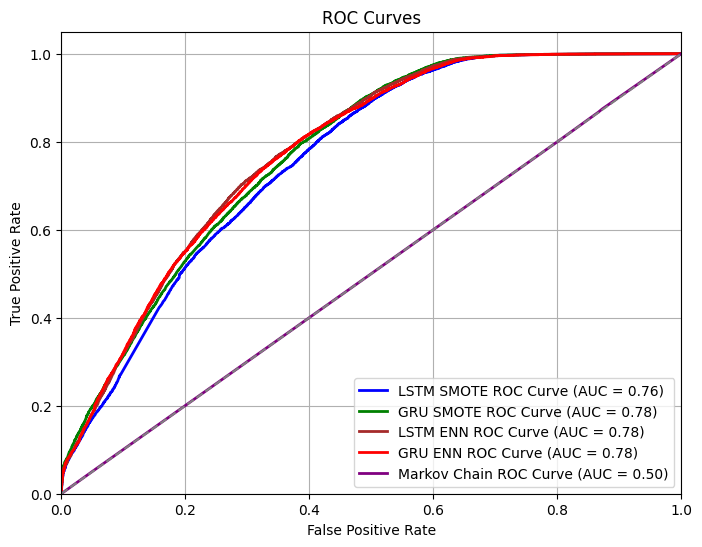

In [ ]:
# Compute ROC curve for LSTM
fpr_lstm_ovs, tpr_lstm_ovs, thresholds_lstm_ovs = roc_curve(y_test, y_pred_LSTM_ovs)
roc_auc_lstm_ovs = auc(fpr_lstm_ovs, tpr_lstm_ovs)

# Compute ROC curve for GRU
fpr_gru_ovs, tpr_gru_ovs, thresholds_gru_ovs = roc_curve(y_test, y_pred_GRU_ovs)
roc_auc_gru_ovs = auc(fpr_gru_ovs, tpr_gru_ovs)

# Compute ROC curve for Oracle
fpr_lstm_uns, tpr_lstm_uns, thresholds_LSTM_uns = roc_curve(y_test, y_pred_LSTM_uns)
roc_auc_LSTM_uns = auc(fpr_lstm_uns, tpr_lstm_uns)

# Compute ROC curve for Oracle
fpr_GRU_uns, tpr_GRU_uns, thresholds_GRU_uns = roc_curve(y_test, y_pred_GRU_uns)
roc_auc_GRU_uns = auc(fpr_GRU_uns, tpr_GRU_uns)

# Compute ROC curve for Markov Chain
fpr_markov, tpr_markov, thresholds_markov = roc_curve(y_test, y_pred_markov)  # Adjusted true_labels to y_test
roc_auc_markov = auc(fpr_markov, tpr_markov)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr_lstm_ovs, tpr_lstm_ovs, color='blue', lw=2, label=f'LSTM SMOTE ROC Curve (AUC = {roc_auc_lstm_ovs:.2f})')
plt.plot(fpr_gru_ovs, tpr_gru_ovs, color='green', lw=2, label=f'GRU SMOTE ROC Curve (AUC = {roc_auc_gru_ovs:.2f})')
plt.plot(fpr_lstm_uns, tpr_lstm_uns, color='brown', lw=2, label=f'LSTM ENN ROC Curve (AUC = {roc_auc_LSTM_uns:.2f})')
plt.plot(fpr_GRU_uns, tpr_GRU_uns, color='red', lw=2, label=f'GRU ENN ROC Curve (AUC = {roc_auc_GRU_uns:.2f})')
plt.plot(fpr_markov, tpr_markov, color='purple', lw=2, label=f'Markov Chain ROC Curve (AUC = {roc_auc_markov:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves')
plt.legend(loc="lower right")
plt.grid(True)
plt.savefig('ROC_Curves_imb.pdf', format='pdf')
plt.show()

#### SHAP

In [ ]:
# Set a fixed random seed
np.random.seed(42)

sample_size = 100
sample_indices = np.random.choice(len(padded_sequences_test), size=sample_size, replace=False)
subset_X_test_reshaped = padded_sequences_test[sample_indices]

In [ ]:
# Summarize the background data using k-means
background_summary = shap.kmeans(subset_X_test_reshaped, 5)  # You can adjust the number of clusters (K) as needed

# Create an explainer using the Kernel SHAP method with the summarized background data
kernel_explainer = shap.KernelExplainer(model_GRU_uns.predict, background_summary)

# Compute SHAP values for the test data
shap_values_test_kernel = kernel_explainer.shap_values(subset_X_test_reshaped)

1/1 [==============================] - 1s 752ms/step


  0%|          | 0/100 [00:00<?, ?it/s]

330/330 [==============================] - 2s 7ms/step


In [ ]:
# Define feature names based on the time steps in the sequence
# TS = Time Step
feature_names = [f"TS {i+1}" for i in range(subset_X_test_reshaped.shape[1])]

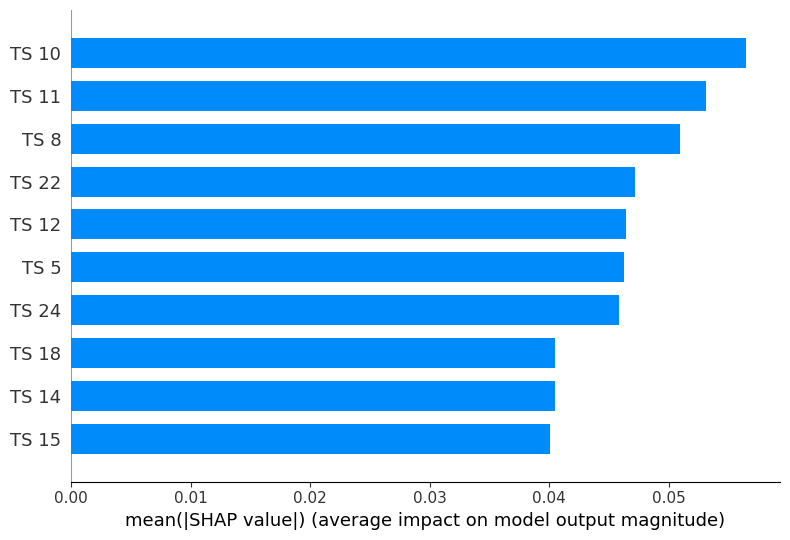

In [ ]:
# Reshape the SHAP values matrix to match the shape of the features matrix
shap_values_test_kernel_reshaped = shap_values_test_kernel.reshape(shap_values_test_kernel.shape[0], shap_values_test_kernel.shape[1], -1)

# Aggregate SHAP values across all features
shap_values_aggregated = np.mean(shap_values_test_kernel, axis=2)

# Get the mean absolute SHAP values for each feature
mean_abs_shap_values = np.mean(np.abs(shap_values_aggregated), axis=0)

# Sort the features based on their mean absolute SHAP values
sorted_indices = np.argsort(mean_abs_shap_values)[::-1]

# Select only the top ten features
top_ten_indices = sorted_indices[:10]
top_ten_features = subset_X_test_reshaped[:, top_ten_indices]
top_ten_feature_names = [feature_names[i] for i in top_ten_indices]

# Plot the aggregated SHAP values for the top ten features
shap.summary_plot(shap_values_aggregated[:, top_ten_indices], features=top_ten_features, feature_names=top_ten_feature_names , plot_type='bar')

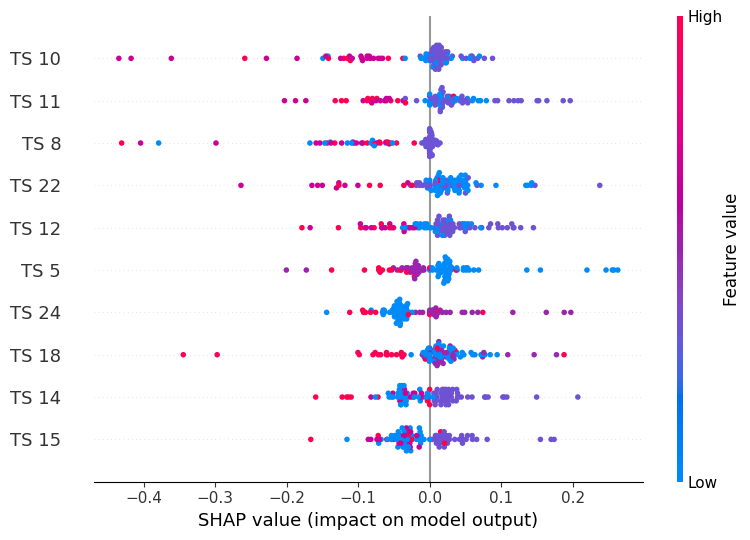

In [ ]:
shap.summary_plot(shap_values_aggregated[:, top_ten_indices], features=top_ten_features, feature_names=top_ten_feature_names)

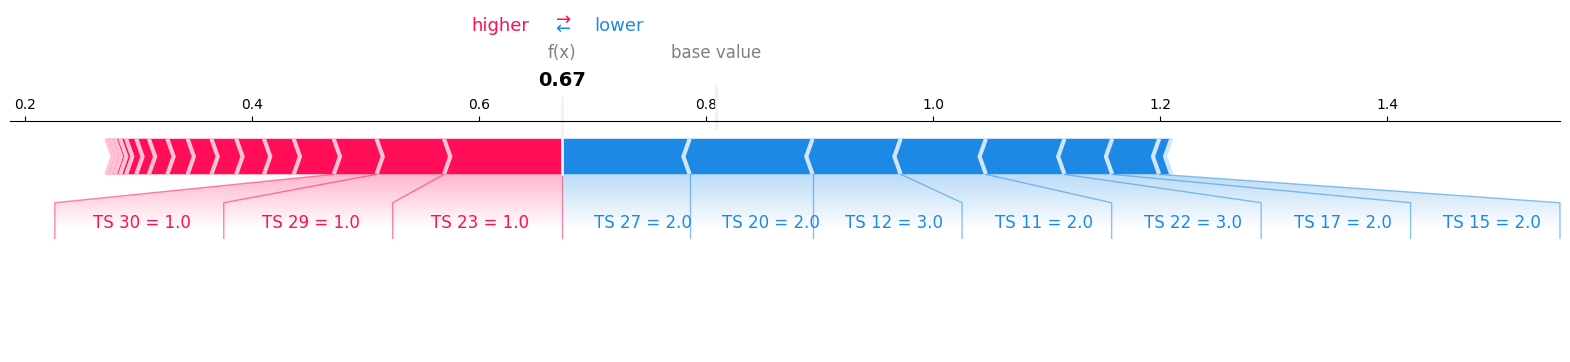

In [ ]:
# Choose an instance to explain (e.g., the first instance)
instance_index = 5

# Generate force plot for the chosen instance
shap.force_plot(kernel_explainer.expected_value, shap_values_test_kernel[instance_index][:, 0], subset_X_test_reshaped[instance_index], matplotlib=True, feature_names= feature_names)

### Random Undersampling

In [ ]:
from imblearn.under_sampling import RandomUnderSampler

# Original dataset
print('Original dataset shape:', Counter(y_train))

rus = RandomUnderSampler(random_state=42)  # You can adjust the random_state parameter as needed
X_res, y_res = rus.fit_resample(X_train, y_train)

# Print the shape of the resampled dataset
print('Resampled dataset shape:', Counter(y_res))

Original dataset shape: Counter({0.0: 92300, 1.0: 27319})
Resampled dataset shape: Counter({0.0: 27319, 1.0: 27319})


In [ ]:
# Reshape the input data to match the expected input shape of the GRU layer
X_train_reshaped = np.expand_dims(X_res, axis=-1)
X_val_reshaped = np.expand_dims(X_val, axis=-1)

In [ ]:
model_GRU_uns = Sequential([
    GRU(64, input_shape=(None, 1)),
    Dropout(0.5),
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(64, activation='relu'),
    Dense(1, activation='sigmoid')
])

# Compile the model with Adam optimizer and a lower learning rate
optimizer = Adam(learning_rate=0.001)
model_GRU_uns.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
history = model_GRU_uns.fit(X_train_reshaped, y_res, epochs=10, batch_size=64, validation_data=(X_val_reshaped, y_val))

Epoch 1/10
854/854 [==============================] - 13s 10ms/step - loss: 0.6903 - accuracy: 0.5169 - val_loss: 0.6992 - val_accuracy: 0.2290
Epoch 2/10
854/854 [==============================] - 11s 13ms/step - loss: 0.6810 - accuracy: 0.5333 - val_loss: 0.6860 - val_accuracy: 0.7542
Epoch 3/10
854/854 [==============================] - 14s 17ms/step - loss: 0.6790 - accuracy: 0.5340 - val_loss: 0.6608 - val_accuracy: 0.7558
Epoch 4/10
854/854 [==============================] - 15s 18ms/step - loss: 0.6737 - accuracy: 0.5485 - val_loss: 0.5896 - val_accuracy: 0.6910
Epoch 5/10
854/854 [==============================] - 10s 11ms/step - loss: 0.5843 - accuracy: 0.6602 - val_loss: 0.5602 - val_accuracy: 0.5932
Epoch 6/10
854/854 [==============================] - 7s 9ms/step - loss: 0.5590 - accuracy: 0.6820 - val_loss: 0.5141 - val_accuracy: 0.6687
Epoch 7/10
854/854 [==============================] - 6s 7ms/step - loss: 0.5503 - accuracy: 0.6903 - val_loss: 0.5296 - val_accuracy: 0.6

In [ ]:
# Predict labels for the test set
y_pred = model_GRU_uns.predict(padded_sequences_test)
y_pred_binary = (y_pred > 0.54).astype(int)  # Convert probabilities to binary predictions

# Calculate the F1 score
f1 = f1_score(y_test, y_pred_binary)

print("F1 Score:", f1)

1247/1247 [==============================] - 3s 2ms/step
F1 Score: 0.5215227668574273


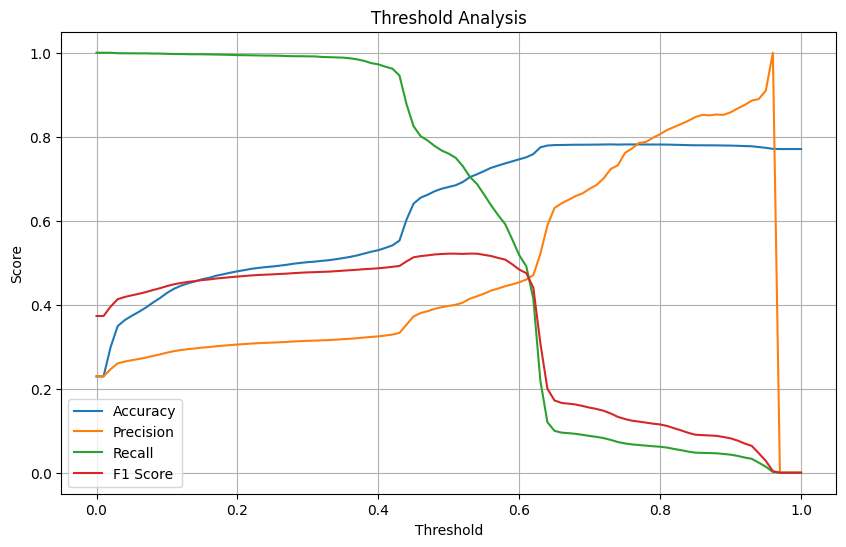

In [ ]:
thresholds = np.linspace(0, 1, 101)  # 100 thresholds from 0 to 1

# Initialize lists to store evaluation metrics
accuracy_scores = []
precision_scores = []
recall_scores = []
f1_scores = []

# Iterate over each threshold
for threshold in thresholds:
    # Convert probabilities to binary predictions based on the threshold
    y_pred_binary = np.where(y_pred > threshold, 1, 0)

    # Evaluate the model using the current threshold
    accuracy = accuracy_score(y_test, y_pred_binary)
    precision = precision_score(y_test, y_pred_binary)
    recall = recall_score(y_test, y_pred_binary)
    f1 = f1_score(y_test, y_pred_binary)

    # Append evaluation metrics to lists
    accuracy_scores.append(accuracy)
    precision_scores.append(precision)
    recall_scores.append(recall)
    f1_scores.append(f1)

# Plot the evaluation metrics against thresholds
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))

plt.plot(thresholds, accuracy_scores, label='Accuracy')
plt.plot(thresholds, precision_scores, label='Precision')
plt.plot(thresholds, recall_scores, label='Recall')
plt.plot(thresholds, f1_scores, label='F1 Score')

plt.xlabel('Threshold')
plt.ylabel('Score')
plt.title('Threshold Analysis')
plt.legend()
plt.grid(True)
plt.show()

## Undersampling ENN (LSTM)

In [ ]:
sequences_train = X_train['session'].tolist()
sequences_test = X_test['session'].tolist()
sequences_train = [[int(num) for num in item.strip("[]").split(', ')] for item in sequences_train]
sequences_test = [[int(num) for num in item.strip("[]").split(', ')] for item in sequences_test]

# Pad sequences to a fixed length
max_length = 30  # Choose the maximum length you want
padded_sequences_train = pad_sequences(sequences_train, maxlen= max_length, padding='post', truncating='post')
padded_sequences_test = pad_sequences(sequences_test, maxlen= max_length, padding='post', truncating='post')

# Convert padded sequences to NumPy array
sequences_train = np.array(padded_sequences_train)
labels_train = np.array(y_train)
sequences_test = np.array(padded_sequences_test)
labels_test = np.array(y_test)

In [ ]:
# Split the data into train, validation, and test sets
X_train, X_val, y_train, y_val = train_test_split(sequences_train, labels_train, test_size=0.25, random_state=42)  # 0.25 x 0.8 = 0.2

# Reshape the input data to match the expected input shape of the GRU layer
X_train_reshaped = np.expand_dims(X_train, axis=-1)
X_val_reshaped = np.expand_dims(X_val, axis=-1)

In [ ]:
X_train.shape

(119619, 30)

In [ ]:
y_train.shape

(119619,)

In [ ]:
# Original dataset
print('Original dataset shape:', Counter(y_train))

enn = EditedNearestNeighbours(n_neighbors=5)  # Adjust the n_neighbors parameter as needed
X_res, y_res = enn.fit_resample(X_train, y_train)

# Print the shape of the resampled dataset
print('Resampled dataset shape:', Counter(y_res))

Original dataset shape: Counter({0.0: 92300, 1.0: 27319})
Resampled dataset shape: Counter({0.0: 34899, 1.0: 27319})


In [ ]:
X_train_reshaped = np.expand_dims(X_res, axis=-1)
X_val_reshaped = np.expand_dims(X_val, axis=-1)

In [ ]:
model_LSTM_uns = Sequential([
    LSTM(32, input_shape=(None, 1)),
    Dropout(0.25),
    Dense(32, activation='relu'),
    Dense(1, activation='sigmoid')
])

# Compile the model with Adam optimizer and a lower learning rate
optimizer = Adam(learning_rate=0.01)
model_LSTM_uns.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
history = model_LSTM_uns.fit(X_train_reshaped, y_res, epochs=10, batch_size=64, validation_data=(X_val_reshaped, y_val))

Epoch 1/10
973/973 [==============================] - 14s 8ms/step - loss: 0.5227 - accuracy: 0.7131 - val_loss: 0.7466 - val_accuracy: 0.5466
Epoch 2/10
973/973 [==============================] - 9s 9ms/step - loss: 0.3726 - accuracy: 0.8129 - val_loss: 0.7317 - val_accuracy: 0.6192
Epoch 3/10
973/973 [==============================] - 8s 9ms/step - loss: 0.3610 - accuracy: 0.8194 - val_loss: 0.6343 - val_accuracy: 0.6546
Epoch 4/10
973/973 [==============================] - 7s 7ms/step - loss: 0.3549 - accuracy: 0.8226 - val_loss: 0.6782 - val_accuracy: 0.6761
Epoch 5/10
973/973 [==============================] - 8s 8ms/step - loss: 0.3471 - accuracy: 0.8254 - val_loss: 0.7561 - val_accuracy: 0.6013
Epoch 6/10
973/973 [==============================] - 7s 7ms/step - loss: 0.3459 - accuracy: 0.8266 - val_loss: 0.7020 - val_accuracy: 0.6452
Epoch 7/10
973/973 [==============================] - 9s 9ms/step - loss: 0.3425 - accuracy: 0.8267 - val_loss: 0.6871 - val_accuracy: 0.6305
Epoch

In [ ]:
model_save_name = 'model_LSTM_uns.h5'
path = "/content/drive/MyDrive/Thesis/Models/" + model_save_name
model_LSTM_uns.save(path)

In [ ]:
# Load the model from the saved HDF5 file
model_save_name = 'model_LSTM_uns.h5'
path = "/content/drive/MyDrive/Thesis/Models/" + model_save_name
model_LSTM_uns = load_model(path)

In [ ]:
# Predict labels for the test set
y_pred = model_LSTM_uns.predict(X_train_reshaped)
y_pred_binary = (y_pred > 0.68).astype(int)  # Convert probabilities to binary predictions

# Calculate the F1 score
f1 = f1_score(y_res, y_pred_binary)

print("F1 Score:", f1)

1945/1945 [==============================] - 9s 4ms/step
F1 Score: 0.7722913400256561


In [ ]:
# Predict labels for the test set
y_pred = model_LSTM_uns.predict(X_val_reshaped)
y_pred_binary = (y_pred > 0.68).astype(int)  # Convert probabilities to binary predictions

# Calculate the F1 score
f1 = f1_score(y_val, y_pred_binary)

print("F1 Score:", f1)

1247/1247 [==============================] - 6s 5ms/step
F1 Score: 0.5161263747580014


In [ ]:
# Predict labels for the test set
y_pred = model_LSTM_uns.predict(padded_sequences_test)
y_pred_binary_LSTM_uns = (y_pred > 0.68).astype(int)  # Convert probabilities to binary predictions

# Calculate the F1 score
f1 = f1_score(y_test, y_pred_binary_LSTM_uns)

print("F1 Score:", f1)

1247/1247 [==============================] - 3s 2ms/step
F1 Score: 0.5227168997137048


### Error Analysis

Brier Score: 0.25087619078274415


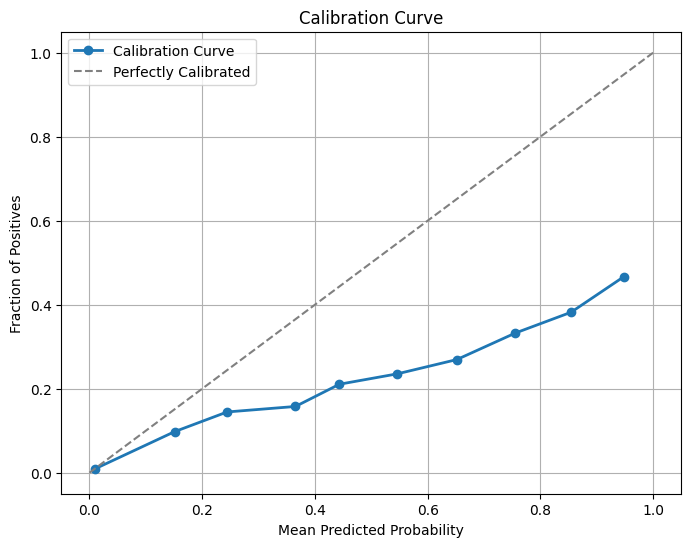

In [ ]:
prob_true, prob_pred = calibration_curve(y_test, y_pred, n_bins=10, strategy='uniform')

# Compute Brier score
brier_score = brier_score_loss(y_test, y_pred)
print("Brier Score:", brier_score)

# Plot calibration curve
plt.figure(figsize=(8, 6))
plt.plot(prob_pred, prob_true, marker='o', linewidth=2, label='Calibration Curve')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Perfectly Calibrated')
plt.xlabel('Mean Predicted Probability')
plt.ylabel('Fraction of Positives')
plt.title('Calibration Curve')
plt.legend()
plt.grid(True)
plt.show()

              precision    recall  f1-score   support

         0.0       0.89      0.72      0.79     30729
         1.0       0.42      0.69      0.52      9145

    accuracy                           0.71     39874
   macro avg       0.65      0.70      0.66     39874
weighted avg       0.78      0.71      0.73     39874



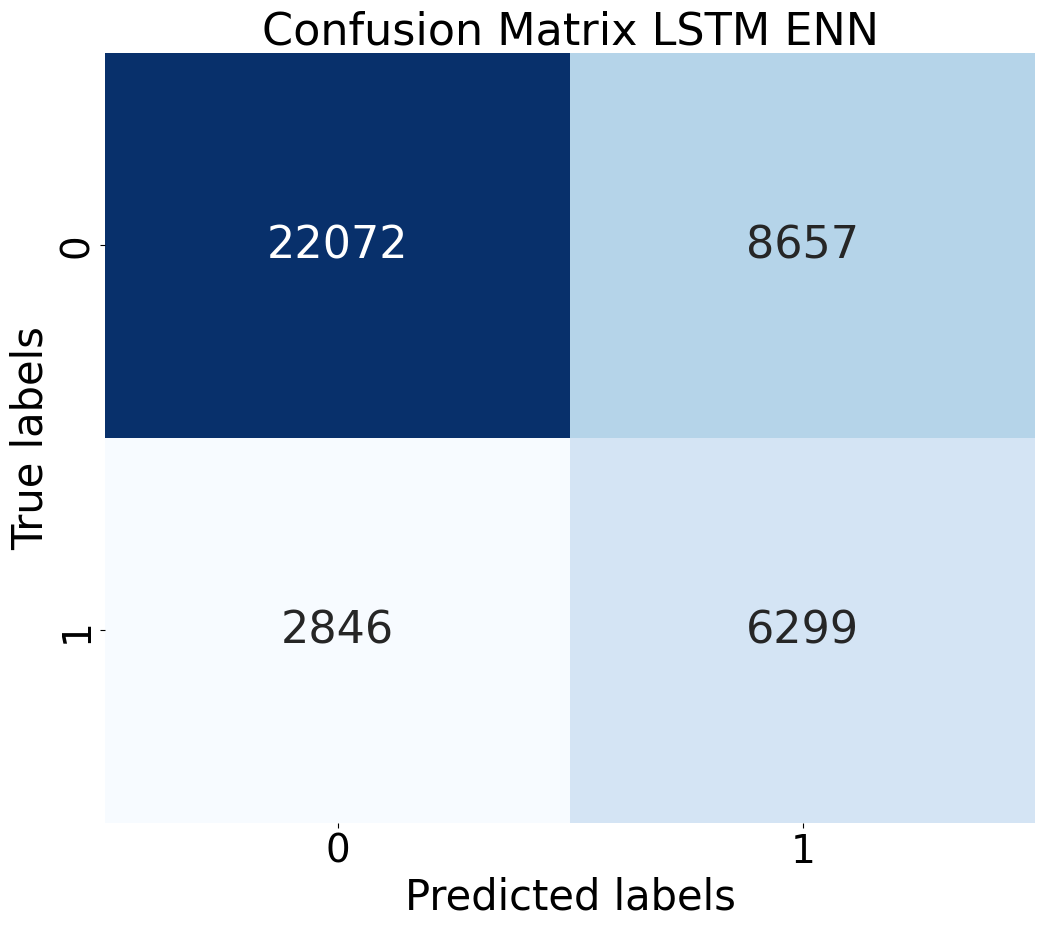

In [ ]:
# Compute confusion matrix and classification report for LSTM ENN
conf_matrix = confusion_matrix(y_test, y_pred_binary_LSTM_uns)
cr_error = classification_report(y_test, y_pred_binary_LSTM_uns)
print(cr_error)

# Plot confusion matrix
plt.figure(figsize=(12, 10))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False, annot_kws={"size": 32})
plt.xlabel('Predicted labels', fontsize=30)
plt.ylabel('True labels', fontsize=30)
plt.title('Confusion Matrix LSTM ENN', fontsize=32)
plt.xticks(fontsize=28)
plt.yticks(fontsize=28)
plt.savefig('Confusion_Matrix_LSTM_ENN.pdf', format='pdf')
plt.show()

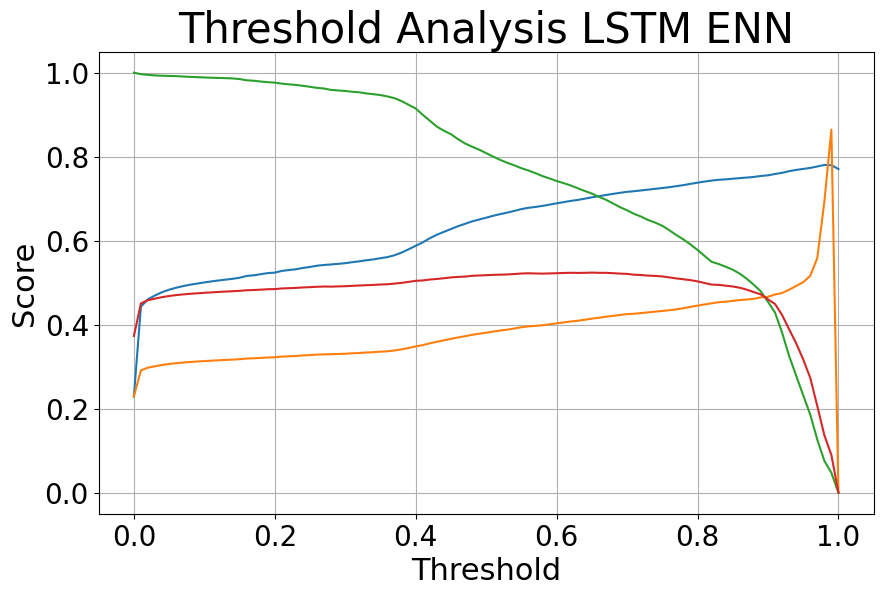

In [ ]:
thresholds = np.linspace(0, 1, 101)  # 100 thresholds from 0 to 1

# Initialize lists to store evaluation metrics
accuracy_scores = []
precision_scores = []
recall_scores = []
f1_scores = []

# Iterate over each threshold
for threshold in thresholds:
    # Convert probabilities to binary predictions based on the threshold
    y_pred_binary_LSTM_uns = np.where(y_pred > threshold, 1, 0)

    # Evaluate the model using the current threshold
    accuracy = accuracy_score(y_test, y_pred_binary_LSTM_uns)
    precision = precision_score(y_test, y_pred_binary_LSTM_uns)
    recall = recall_score(y_test, y_pred_binary_LSTM_uns)
    f1 = f1_score(y_test, y_pred_binary_LSTM_uns)

    # Append evaluation metrics to lists
    accuracy_scores.append(accuracy)
    precision_scores.append(precision)
    recall_scores.append(recall)
    f1_scores.append(f1)

plt.figure(figsize=(10, 6))

plt.plot(thresholds, accuracy_scores, label='Accuracy')
plt.plot(thresholds, precision_scores, label='Precision')
plt.plot(thresholds, recall_scores, label='Recall')
plt.plot(thresholds, f1_scores, label='F1 Score')

plt.xlabel('Threshold', fontsize=22)
plt.ylabel('Score', fontsize=22)
plt.title('Threshold Analysis LSTM ENN', fontsize=30)
# plt.legend(fontsize=22)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.grid(True)

plt.savefig("Threshold_Analysis_LSTM_ENN.pdf")
plt.show()


In [ ]:
# Train the model
history = model_LSTM_uns.fit(X_train_reshaped, y_res, epochs=10, batch_size=64, validation_data=(X_val_reshaped, y_val))

Epoch 1/10
973/973 [==============================] - 9s 8ms/step - loss: 0.3322 - accuracy: 0.8320 - val_loss: 0.7836 - val_accuracy: 0.6363
Epoch 2/10
973/973 [==============================] - 8s 8ms/step - loss: 0.3308 - accuracy: 0.8359 - val_loss: 0.7055 - val_accuracy: 0.6635
Epoch 3/10
973/973 [==============================] - 6s 7ms/step - loss: 0.3288 - accuracy: 0.8364 - val_loss: 0.6536 - val_accuracy: 0.6437
Epoch 4/10
973/973 [==============================] - 9s 9ms/step - loss: 0.3333 - accuracy: 0.8345 - val_loss: 0.7845 - val_accuracy: 0.6295
Epoch 5/10
973/973 [==============================] - 6s 7ms/step - loss: 0.3255 - accuracy: 0.8381 - val_loss: 0.7272 - val_accuracy: 0.6370
Epoch 6/10
973/973 [==============================] - 9s 9ms/step - loss: 0.3267 - accuracy: 0.8386 - val_loss: 0.8390 - val_accuracy: 0.6240
Epoch 7/10
973/973 [==============================] - 7s 8ms/step - loss: 0.3221 - accuracy: 0.8419 - val_loss: 0.7667 - val_accuracy: 0.6294
Epoch 

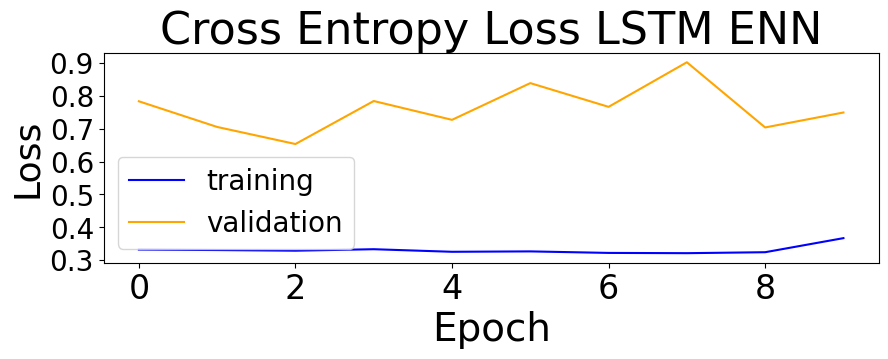

In [ ]:
# Plot Cross Entropy Loss for LSTM ENN
plt.figure(figsize=(10, 6))
plt.subplot(211)
plt.title('Cross Entropy Loss LSTM ENN', fontsize=32)
plt.plot(history.history['loss'], color='blue', label='train')
plt.plot(history.history['val_loss'], color='orange', label='test')
plt.legend(['training', 'validation'], fontsize=20)
plt.xlabel('Epoch', fontsize=28)
plt.ylabel('Loss', fontsize=26)
plt.xticks(fontsize=24)
plt.yticks(fontsize=20)
plt.savefig('Cross_Entropy_Loss_LSTM_ENN.pdf', format='pdf')
plt.show()

In [ ]:
predicted_labels_mv = predicted_labels_mv[:39874]
predicted_labels_mv_ovs = predicted_labels_mv_ovs[:39874]

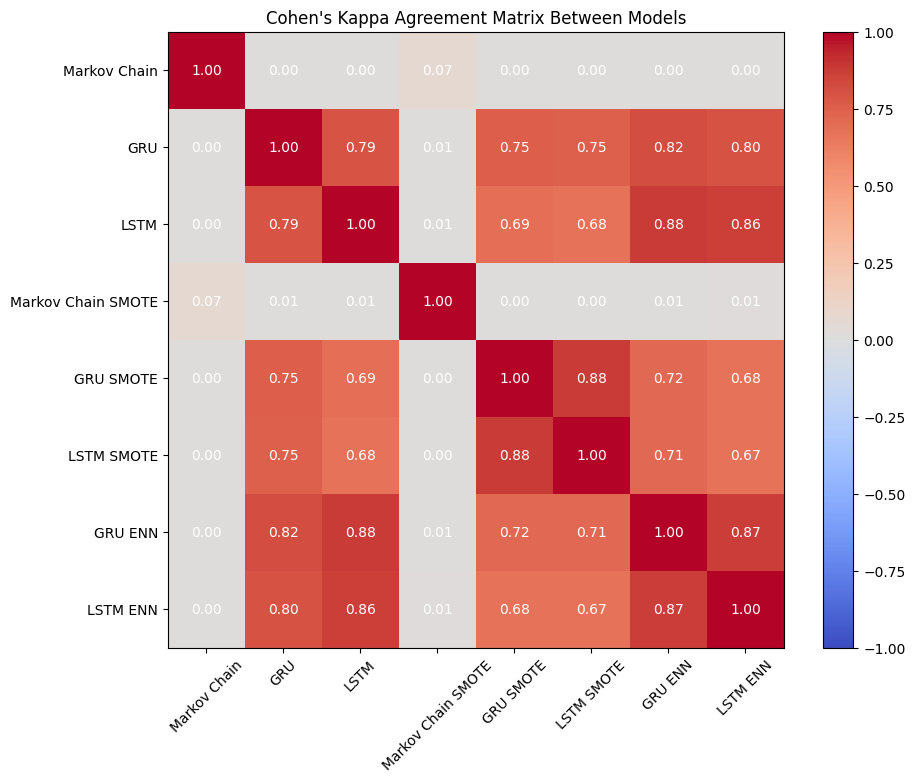

In [ ]:
# Dictionary of predictions - this part remains the same
predictions = {
    'Markov Chain': predicted_labels_mv,
    'GRU': y_pred_binary_GRU,
    'LSTM': y_pred_binary_LSTM,
    'Markov Chain SMOTE': predicted_labels_mv_ovs,
    'GRU SMOTE': y_pred_binary_GRU_ovs,
    'LSTM SMOTE': y_pred_binary_LSTM_ovs,
    'GRU ENN': y_pred_binary_GRU_uns,
    'LSTM ENN': y_pred_binary_LSTM_uns
}

# Initializing an empty matrix to store the Cohen's Kappa scores
kappa_matrix = np.zeros((len(predictions), len(predictions)))

# List of model names for labeling purposes
model_names = list(predictions.keys())

# Calculating Cohen's Kappa for each pair of models
for i, model_i in enumerate(model_names):
    for j, model_j in enumerate(model_names):
        kappa_matrix[i, j] = cohen_kappa_score(predictions[model_i], predictions[model_j])

# Plotting the Cohen's Kappa matrix
plt.figure(figsize=(10, 8))
im = plt.imshow(kappa_matrix, interpolation='nearest', cmap='coolwarm', vmin=-1, vmax=1)
plt.colorbar(im)
plt.xticks(ticks=np.arange(len(model_names)), labels=model_names, rotation=45)
plt.yticks(ticks=np.arange(len(model_names)), labels=model_names)
plt.title('Cohen\'s Kappa Agreement Matrix Between Models')

# Adding text annotations to each cell
for i in range(len(model_names)):
    for j in range(len(model_names)):
        text = plt.text(j, i, f"{kappa_matrix[i, j]:.2f}",
                       ha="center", va="center", color="w")

plt.grid(False)
plt.savefig('Cohens Kappa all models.pdf', format='pdf')
plt.show()

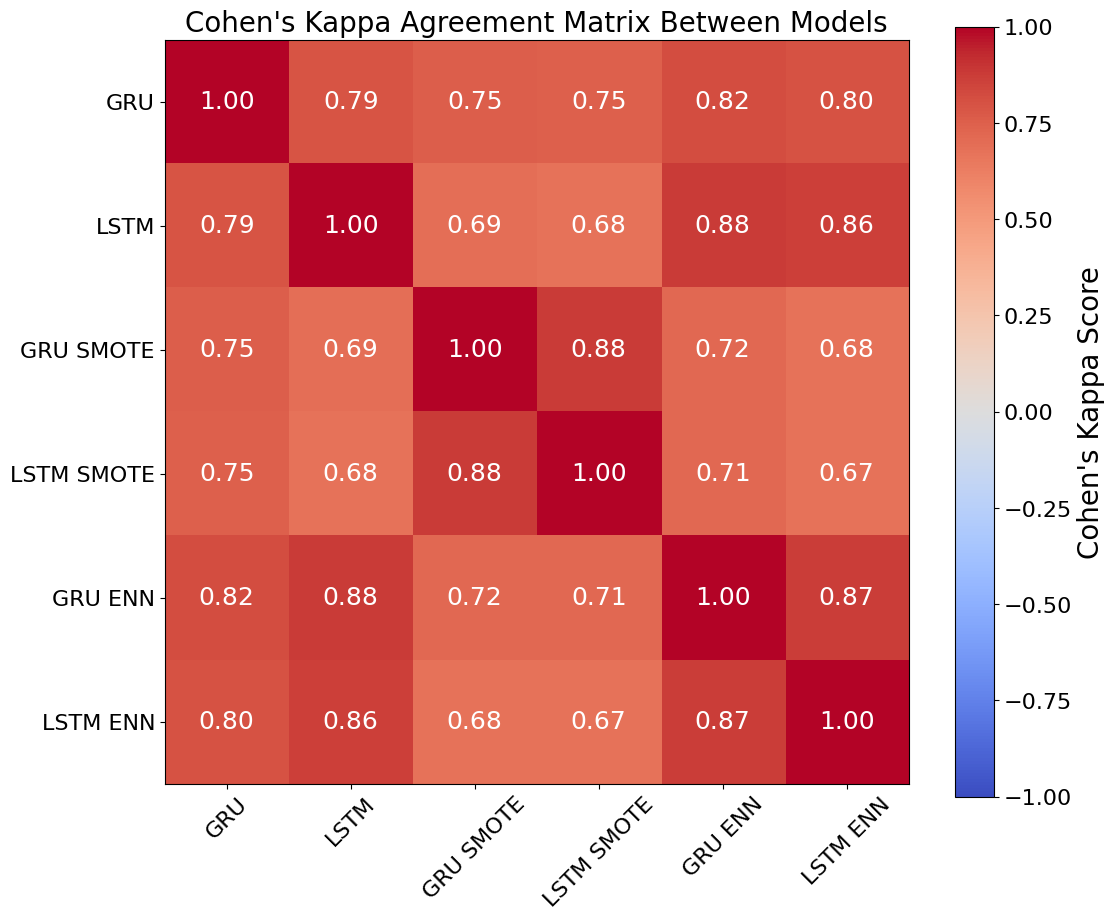

In [ ]:
# Dictionary of predictions
predictions = {
    'GRU': y_pred_binary_GRU,
    'LSTM': y_pred_binary_LSTM,
    'GRU SMOTE': y_pred_binary_GRU_ovs,
    'LSTM SMOTE': y_pred_binary_LSTM_ovs,
    'GRU ENN': y_pred_binary_GRU_uns,
    'LSTM ENN': y_pred_binary_LSTM_uns
}

# Initializing an empty matrix to store the Cohen's Kappa scores
kappa_matrix = np.zeros((len(predictions), len(predictions)))

# List of model names for labeling purposes
model_names = list(predictions.keys())

# Calculating Cohen's Kappa for each pair of models
for i, model_i in enumerate(model_names):
    for j, model_j in enumerate(model_names):
        kappa_matrix[i, j] = cohen_kappa_score(predictions[model_i], predictions[model_j])

# Plotting the Cohen's Kappa matrix
plt.figure(figsize=(12, 10))
im = plt.imshow(kappa_matrix, interpolation='nearest', cmap='coolwarm', vmin=-1, vmax=1)
cbar = plt.colorbar(im)
cbar.ax.tick_params(labelsize=16)
cbar.set_label('Cohen\'s Kappa Score', fontsize=20)

plt.xticks(ticks=np.arange(len(model_names)), labels=model_names, rotation=45, fontsize=16)
plt.yticks(ticks=np.arange(len(model_names)), labels=model_names, fontsize=16)
plt.title('Cohen\'s Kappa Agreement Matrix Between Models', fontsize=20)

# Adding text annotations to each cell
for i in range(len(model_names)):
    for j in range(len(model_names)):
        text = plt.text(j, i, f"{kappa_matrix[i, j]:.2f}",
                       ha="center", va="center", color="w", fontsize=18)

plt.grid(False)
plt.savefig('Cohens_Kappa_GRU_LSTM.pdf', format='pdf')
plt.show()